# TODO

- [ ] Plug inflation in housing stock
- [ ] Add other autonomous expenditure

In [1]:
#!pip install pysolve3

Time checking:

In [2]:
from datetime import datetime
t1 = datetime.now()

# Introduction

Jupyter notebook for the simplest model scratch. By convention, all exogenous variables are presented with a overline line (*e.g.* $\overline a$) and the parameters are represented by greek letters (*e.g.* $\alpha$). The code in this document is executable and is strongly recommend to do the follow to ensure that the output is corrected and updated:

Run time > Restart and run all...

# Changes

In this version, the autonomous growth rate is endogenized as a function of housing own interest rates:

$$
g_Z = \phi_0  -\phi_1\cdot \left(\frac{1+r_{mo}}{1+\dot p_h}-1\right)
$$
which

- $\phi_0$ and $\phi_1$ are parameters
- $\dot p_h$ is housing inflation and equals 0 in this version

$$
\dot p_h = \frac{\Delta p_h}{p_{h_{-1}}}
$$

## General Equations

$$
Y = C + I
$$

$$
I = I_f + I_h
$$

$$
\omega = \overline \omega
$$

$$
W = \omega \cdot  Y
$$

$$
Y_K = \frac{K_f}{\overline v}
$$

$$
u = \frac{Y}{Y_K}
$$

$$
g_k = \frac{h\cdot u}{v}
$$

$$
Z = I_h
$$

$$
K = K_f + K_{HD}
$$

## Households

$$
YD = W + FD + \overline r_{m-1}\cdot M_{-1} - \overline r_{mo-1}\cdot MO - r_l\cdot{L_h}
$$


$$
S_h = YD - C = \Delta M
$$

$$
C = \alpha\cdot W
$$


$$
\Delta MO = I_h
$$

$$
V_h = M + K_H - MO
$$

$$
NFW_h = S_h - I_h
$$

$$
\text{Residual} = \Delta M - \Delta L_f 
$$

## Firms

$$
\Delta L_f = I_f - FU
$$

$$
FT = Y - W = FU+ FD
$$

$$
FU = \gamma_F\cdot (FT - r_{L_{-1}}\cdot L_{f_{-1}})
$$


$$
FD = (1 - \gamma_F)\cdot (FT - r_{L_{-1}}\cdot L_{f_{-1}})
$$

$$
I_f = h\cdot Y
$$

$$
\Delta K_f = I_f
$$

$$
\Delta h = 
h_{-1}\cdot \gamma_u\cdot (u - \overline u_n)
$$

$$
V_f = K_f  - L_f
$$

$$
NFW_f = FU - I_f
$$

## Banks

$$
L = L_f
$$

$$
\Delta M = \Delta L + \Delta MO
$$

$$
NFW_b = rl_{-1}\cdot L_{-1} + rmo_{-1}\cdot MO_{-1} - rm_{-1}\cdot M_{-1}
$$

$$
r_l = r_m + spread_l (=0)
$$

$$
r_{mo} = r_m + spread_{mo} (=0)
$$

$$
V_b = L + MO - M
$$

## Residential Investment


$$
K_{HS} = K_{HD}
$$

$$
I_h^S = I_h
$$

$$
\Delta K_{HD} = I_h
$$

$$
I_h = (1+g_Z)\cdot I_{h_{-1}}
$$


$$
k = \frac{K_h*p_h}{K}
$$

$$
g_Z = phi_0 - phi_1\cdot own
$$

$$
own = \left(\frac{1+r_{mo}}{1+\dot p}\right) -1
$$

# Simulation setup

## Loading libraries

In [3]:
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import networkx as nx
import sympy as sp
from sympy import pprint, cse

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from scipy.stats import yeojohnson

plt.style.use('seaborn-white')

from pysolve3.model import Model
from pysolve3.utils import SolveSFC, ShockModel, SummaryShock, SFCTable

import pandas_datareader.data as web
start = datetime(1987, 1, 1)
end = datetime(2018, 12, 31)

/home/gpetrini/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


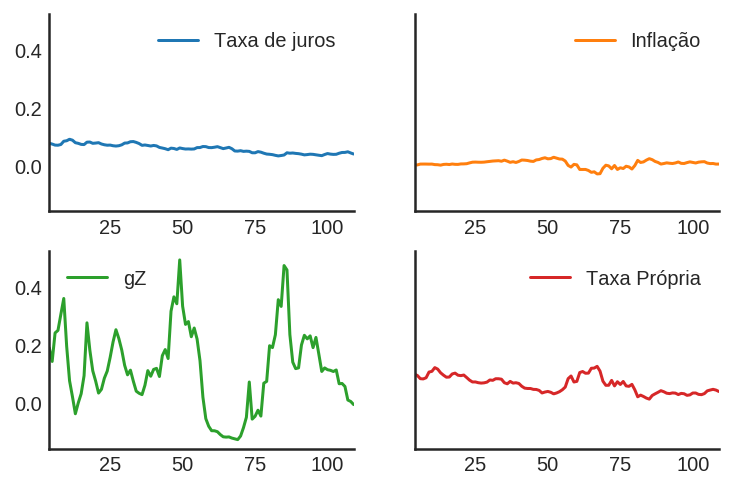

In [4]:
data = pd.read_csv('../SeriesTemporais/Dados_yeojohnson.csv')

data = data[[
    "Taxa de juros", 
    "Inflação", 
    "gZ", 
    "Crise", 
    "Taxa Própria",
]]
        
data = data.dropna()

fig, ax = plt.subplots()

data.drop('Crise', axis='columns').plot(ax=ax, subplots=True, layout=(2,2), sharex=False, sharey=True)
ax.axhline(y=0, ls='--', color='black')
sns.despine()
plt.show()
fig.savefig('YeoJohnson.png', dpi=300, bbox_inches = 'tight',)

# Creating model function

In [5]:
def model(
    alpha = 0.7, # 1
    gamma_F = 0.4,
    gamma_u = 0.01,
    g_Z = 0.05,
    omega = 0.5,
    rm = 0.02,
    spread_l = 0,
    spread_mo = 0,
    un = 0.8,
    v = 2.5,
    phi_0 = 0.04,
    phi_1 = 0.02,
    infla = 0.0,
    phparam=1.0
):
  """
  phparam: 1.0 means no inflation
  """
  model = Model()
  model.set_var_default(0) 
  model.var('C', desc='Consumption')
  model.var('FD', desc='Distributed profits')
  model.var('Fn', desc='Net profits')
  model.var('FT', desc='Total Profits')
  model.var('FU', desc='Retained profits')
  model.var('gk', desc='Capital growth rate', default=0.01)
  model.var('g_Z', desc='Autonomous grouth rate', default=g_Z)
  model.var('h', desc='Marginal propensity to invest (non-residential)', default=0.30)
  model.var('I_t', desc='Investment', default = 100) # 200
  model.var('I_f', desc='Non-residential investment') # 100
  model.var('I_h', desc='Residential investment', default = 100) # 100
  model.var('Is', desc='Residential investment (Supply)', default = 100) # 100
  model.var('K_HS', desc='Houses supply', default=500) # 500
  model.var('K_HD', desc='Houses demand', default=500) # 500
  model.var('K_f', desc='Non-residential capital', default = 1000) # 10000
  model.var('Knom', desc='Nominal Capital', default=1500)
  model.var('K', desc='Real Capital', default=1500)
  model.var('K_k', desc="% of Kf in total")
  model.var('L', desc='Total Loans') # 100
  model.var('Lf', desc='Firms Loans') # 100
  model.var('M', desc='Money deposits', default = 305) # 300
  model.var('MO', desc='Mortgages', default = 305) # 200
  model.var('NFW_h', desc='Households Net Financial Wealth')
  model.var('NFW_f', desc='Firms Net Financial Wealth')
  model.var('NFW_b', desc='Banks Net Financial Wealth')
  model.var('own', desc='Own interest rate', default = 0.02)
  model.var('ph', desc='House price', default = 1)
  model.var('rl', desc='Interests rates on loans')
  model.var('rmo', desc='Interests rates on mortgages')
  model.var('S_h', desc='Households savings', default = 100)
  model.var('u', desc='Capacity utilization ratio', default=0.7)
  model.var('V_h', desc='Household net nominal wealth', default = 500)
  model.var('V_hr', desc='Household net real wealth', default = 500)
  model.var('V_f', desc='Firms net wealth', default = 1000)
  model.var('V_b', desc='Banks net wealth')
  model.var('W', desc='Wages')
  model.var('Y', desc='GDP')
  model.var('Yk', desc='Capacity')
  model.var('YD', desc='Household disposable income')
  model.var('Z', desc='Autonomous expenditures')
  model.var('Residual', desc='Unecessarily equation. Should be zero')
  #model.var('Zn', desc='Other autonomous expecture', default=300)
  
  model.param('alpha', desc='Propensity to consume out of wages', default=alpha) # 0.7
  model.param('gamma_F', desc='% of undistributed profits', default=gamma_F) # 0.4
  model.param('gamma_u', desc='Adjustment parameter for the marginal propensity to invest', default=gamma_u) # 0.01
  model.param('omega', desc='Wage-share', default = omega)
  model.param('rm', desc='Interest rates on money deposits', default=rm) # 0.02
  model.param('spread_l', desc='Spread for loans', default=spread_l) # 0.01
  model.param('spread_mo', desc='Spread for mortgages', default=spread_mo) # 0.005
  model.param('un', desc='Normal capacity utilization ratio', default=un) # 0.8
  model.param('v', desc='Capitl-Output ratio', default=v) # 2.5
  model.param('phi_0', desc='Autonomous housing investment component',default = phi_0)
  model.param('phi_1', desc='Housing investment sensitivity to own interest rate', default = phi_1)
  model.param('phparam', desc='ph parameter', default = phparam)
  model.param('infla', desc='infla value', default = infla)
  model.param('gZn', desc='Growth rate new autonomous expenditure', 
              default=phi_0 - phi_1*data['Taxa Própria'].iloc[-1])
  
  
  # General equations
  model.add('Y = C + I_t') # Eq1
  model.add('I_t = I_f + I_h') # Eq2
  model.add('Yk = K_f(-1)/v') # Eq 4
  model.add('u = Y/Yk') # Eq 5
  model.add('W = omega*Y') # Eq 6
  model.add('gk = h*u/v') # Eq 7
  model.add('Knom = K_HD*ph + K_f') # Eq 8 ################################### Changes #################################################
  model.add('K = K_HD + K_f') # Eq 8 ################################### Changes #################################################
  model.add('Z = I_h') # Eq 9
  
  # Household equations
  model.add('YD = W + FD + rm*M(-1) - rmo*MO(-1)') # Eq 10
  #model.add('Zn = (1+gZn)*Zn(-1)') ################ Changes ###
  model.add('S_h = YD - C') # Eq 11
  model.add('d(MO) = I_h') # Eq 12
  #model.add('C = alpha*W + Zn') # Eq 14
  model.add('C = alpha*W') # Eq 14
  model.add('V_h =  M  + K_HD*ph - MO') # Eq 15 ################################### Changes #################################################
  model.add('V_hr =  M  + K_HD - MO') # Eq 15 ################################### Changes #################################################
  model.add('NFW_h = S_h - I_h') # Eq 16
  
  # Firms
  model.add('d(Lf) = I_f - FU') # Eq 15
  model.add('FT = (1-omega)*Y') # Eq 16
  model.add('Fn = FT -rl*Lf(-1)')
  model.add('FU = gamma_F*(Fn)') # Eq 17
  model.add('FD = (1 - gamma_F)*(Fn)') # Eq 18
  model.add('I_f = h*Y') # Eq 19
  model.add('d(K_f) = I_f') # 20
  model.add('h = h(-1)*gamma_u*(u-un) + h(-1)') # Eq 21 # Version without corridor
  model.add('V_f = K_f - Lf') # Eq 22
  model.add('NFW_f = FU - I_f') # Eq 23
  
  # Banks
  model.add('L = Lf')
  model.add('d(M) = d(L) + d(MO)') # Eq 24
  model.add('rmo = rm + spread_mo') # Eq 25
  model.add('rl = rm + spread_l') # Eq 26
  model.add('V_b = L + MO - M') # Eq 27
  model.add('NFW_b = rl*L(-1) + rmo*MO(-1) - rm*M(-1)') # Eq 28
  
  # Residential investment
  model.add('K_HS = K_HD') # Eq 29
  model.add('Is = I_h')
  model.add('d(K_HD) = I_h') # Eq 30
  model.add('I_h = (1+g_Z)*I_h(-1)') # Eq 31
  model.add('K_k = K_HD/K') #################### Changes #################################################
  model.add('ph =(1+infla)*ph(-1)')########################### Changes #############################################
  model.add(
        'own = ((1+rmo)/(1+infla)) -1'
    )  ################################### Changes ############################
  model.add('g_Z = phi_0 - phi_1*own') ################################### Changes ################################
  
  model.add('Residual = d(M) - S_h')
  return model

t_check = 100
print('Evaluating consistenty at time = {}'.format(t_check))

test = model()
SolveSFC(test, time=t_check, table = False)
evaldf = pd.DataFrame({
    'Households' : test.evaluate('M - MO + K_HD*ph - V_h'), ############################# Changes ######################
    'Firms' : test.evaluate('K_f - Lf - V_f'),
    'Banks' : test.evaluate('L + MO - M - V_b'),
    'Mortgages' : test.evaluate('MO(-1) - MO(-2) - I_h(-1)'),
    'Financial assets' : test.evaluate('d(MO) + d(L) - d(M)'),
    '[Total Wealth - K]' : test.evaluate('V_f + V_h + V_b - K'),
    "Firm's Funds" : test.evaluate('Lf(-1) - Lf(-2) - I_f(-1) + FU(-1)'),
    "Housing" : test.evaluate('K_HD - K_HS'),
    "Flow check" : test.evaluate('NFW_h + NFW_f + NFW_b'),
    "Investment" : test.evaluate('I_t - I_h - I_f'),
    "Profits" : test.evaluate('FT(-1) - rl*Lf(-2) - FU(-1) - FD(-1)'),
    "Wages" : test.evaluate('W - omega*Y'),
    "Residual" : test.evaluate('Residual')
}, index = ['Sum'])
evaldf = evaldf.transpose()
evaldf.round(5)

Evaluating consistenty at time = 100


Sum
Households          0.00000
Firms               0.00000
Banks               0.00000
Mortgages           0.00000
Financial assets    0.00000
[Total Wealth - K]  0.00004
Firm's Funds       -0.00000
Housing             0.00000
Flow check         -0.00018
Investment         -0.00004
Profits            -0.00000
Wages               0.00000
Residual            0.00018

# Solving

In [6]:
base = model()
df = SolveSFC(base, time=1000)
df.transpose()

0           1           2           3           4           5     \
C           0.0  103.908174  107.937945  112.095155  116.386133  120.817185   
FD          0.0   89.064149   92.162600   95.354668   98.645643  102.040772   
Fn          0.0  148.440248  153.604333  158.924447  164.409405  170.067954   
FT          0.0  148.440248  154.197064  160.135936  166.265905  172.595978   
FU          0.0   59.376099   61.441733   63.569779   65.763762   68.027182   
...         ...         ...         ...         ...         ...         ...   
_h__1       0.3    0.300000    0.299827    0.299551    0.299184    0.298738   
_L__1       0.0    0.000000   29.636537   60.574440   92.824993  126.401201   
_K_HD__1  500.0  500.000000  603.960000  712.036816  824.393474  941.199455   
_I_h__1   100.0  100.000000  103.960000  108.076816  112.356658  116.805982   
_ph__1      1.0    1.000000    1.000000    1.000000    1.000000    1.000000   

                 6            7            8            9     ...  \
C          125.394681   130.125090   135.015007   140.071173  ...   
FD         105.545344   109.164712   112.904325   116.769743  ...   
Fn         175.908907   181.941187   188.173875   194.616239  ...   
FT         179.135258   185.892986   192.878582   200.101676  ...   
FU          70.363563    72.776475    75.269550    77.846495  ...   
...               ...          ...          ...          ...  ...   
_h__1        0.298221     0.297641     0.297004     0.296316  ...   
_L__1      161.317571   197.589938   235.235330   274.271847  ...   
_K_HD__1  1062.630954  1188.871140  1320.110437  1456.546810  ...   
_I_h__1    121.431498   126.240186   131.239297   136.436373  ...   
_ph__1       1.000000     1.000000     1.000000     1.000000  ...   

                  991           992           993           994   \
C         3.446287e+18  3.582759e+18  3.724637e+18  3.872132e+18   
FD        3.239065e+18  3.367332e+18  3.500679e+18  3.639306e+18   
Fn        5.398442e+18  5.612220e+18  5.834464e+18  6.065509e+18   
FT        4.923267e+18  5.118228e+18  5.320909e+18  5.531617e+18   
FU        2.159377e+18  2.244888e+18  2.333786e+18  2.426204e+18   
...                ...           ...           ...           ...   
_h__1     1.237513e-01  1.237513e-01  1.237513e-01  1.237513e-01   
_L__1    -2.375878e+19 -2.469963e+19 -2.567775e+19 -2.669459e+19   
_K_HD__1  1.308517e+20  1.360334e+20  1.414203e+20  1.470205e+20   
_I_h__1   4.984345e+18  5.181725e+18  5.386922e+18  5.600244e+18   
_ph__1    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                  995           996           997           998   \
C         4.025468e+18  4.184877e+18  4.350598e+18  4.522881e+18   
FD        3.783422e+18  3.933246e+18  4.089002e+18  4.250927e+18   
Fn        6.305703e+18  6.555409e+18  6.815003e+18  7.084878e+18   
FT        5.750669e+18  5.978396e+18  6.215140e+18  6.461259e+18   
FU        2.522281e+18  2.622164e+18  2.726001e+18  2.833951e+18   
...                ...           ...           ...           ...   
_h__1     1.237512e-01  1.237512e-01  1.237512e-01  1.237512e-01   
_L__1    -2.775171e+19 -2.885069e+19 -2.999318e+19 -3.118092e+19   
_K_HD__1  1.528426e+20  1.588951e+20  1.651874e+20  1.717288e+20   
_I_h__1   5.822013e+18  6.052565e+18  6.292247e+18  6.541420e+18   
_ph__1    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                  999           1000  
C         4.701987e+18  4.888186e+18  
FD        4.419263e+18  4.594266e+18  
Fn        7.365439e+18  7.657110e+18  
FT        6.717125e+18  6.983123e+18  
FU        2.946175e+18  3.062844e+18  
...                ...           ...  
_h__1     1.237512e-01  1.237512e-01  
_L__1    -3.241570e+19 -3.369937e+19  
_K_HD__1  1.785292e+20  1.855990e+20  
_I_h__1   6.800460e+18  7.069758e+18  
_ph__1    1.000000e+00  1.000000e+00  

[64 rows x 1001 columns]

# Baseline Plots

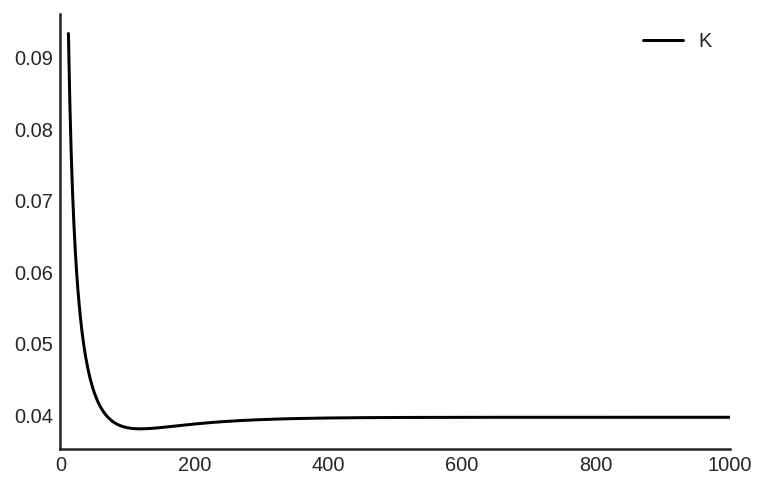

In [7]:
fig, ax = plt.subplots()

df[["K"]].pct_change().rolling(12).mean().plot(ax=ax, color='black')
sns.despine()
plt.show()

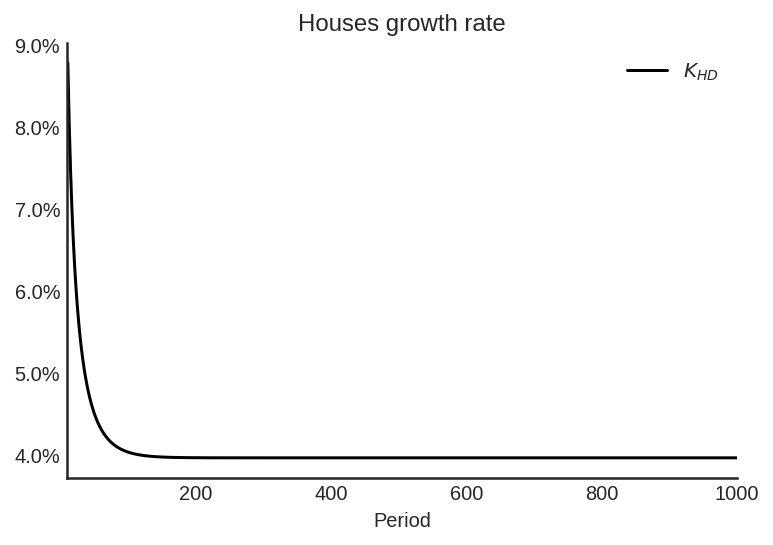

In [8]:
ax = df['K_HD'][10:].pct_change().plot(color="black",
                                       title="Houses growth rate",
                                       label="$K_{HD}$",
                                       legend=True)
ax.set_yticklabels(['{:,.1%}'.format(x) for x in ax.get_yticks()])
plt.xlabel("Period")
sns.despine()
plt.show()

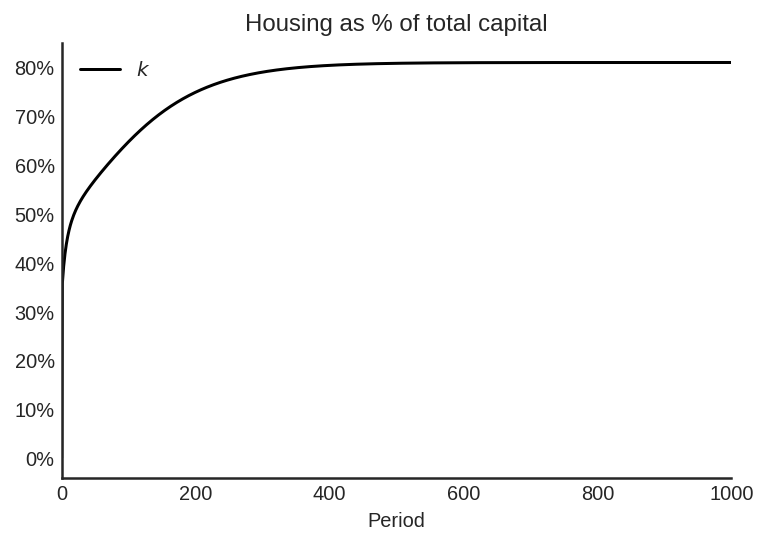

In [9]:
ax = df['K_k'].plot(color = "black", title = "Housing as % of total capital", label = "$k$", legend = True)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
plt.xlabel("Period")
sns.despine()
plt.show()

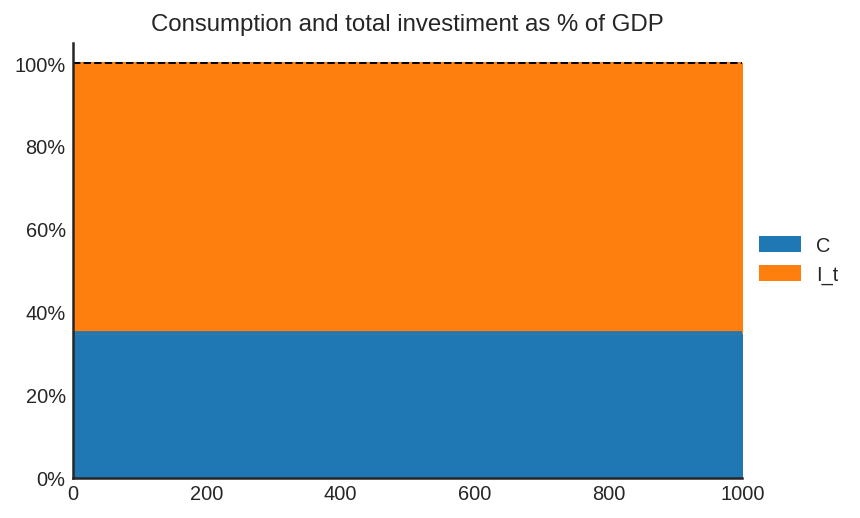

In [10]:
ax = df[['C', 'I_t']].apply(lambda x: x/df['Y']).plot(kind = 'area', stacked = True, legend = True, title = "Consumption and total investiment as % of GDP")
ax.axhline(y=1, color = "black", ls = "--", lw=1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
sns.despine()
plt.show()

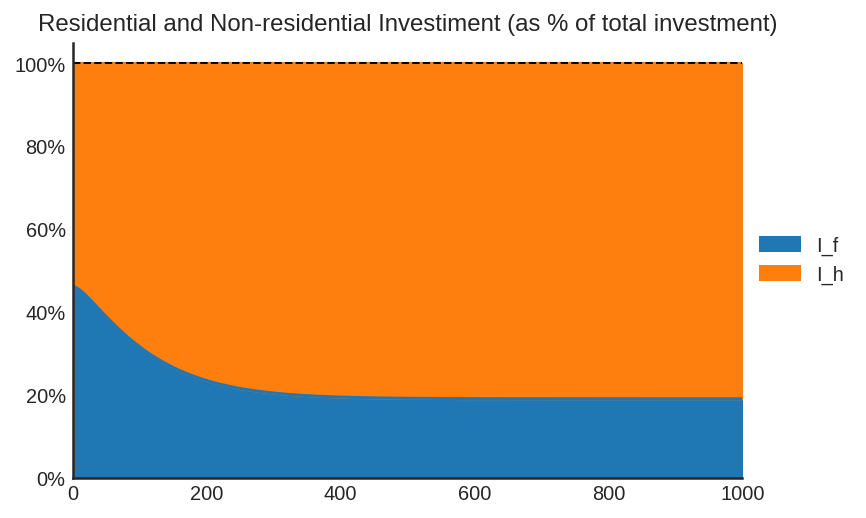

In [11]:
ax = df[['I_f', 'I_h']].apply(lambda x: x/df['I_t']).plot(kind = 'area', stacked = True, legend = True, title = "Residential and Non-residential Investiment (as % of total investment)")
ax.axhline(y=1, color = "black", ls = "--", lw=1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
sns.despine()
plt.show()

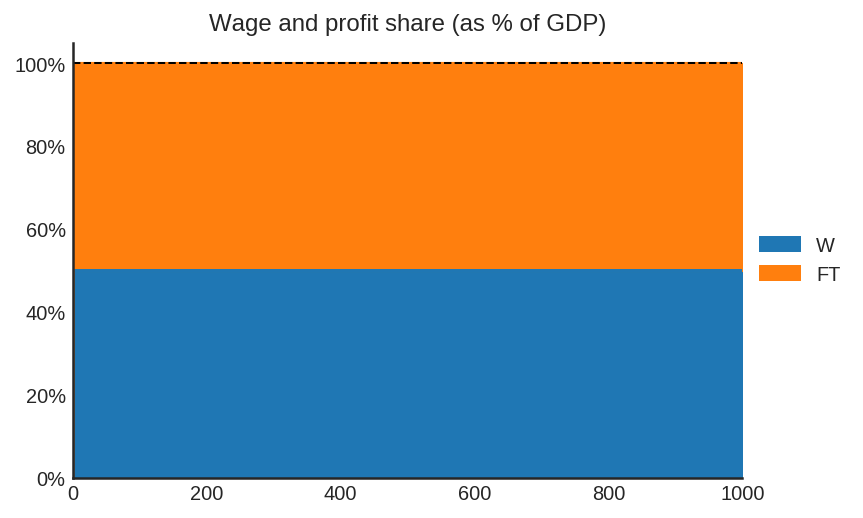

In [12]:
ax = df[['W', 'FT']].apply(lambda x: x/df['Y']).plot(kind = 'area', stacked = True, legend = True, title = "Wage and profit share (as % of GDP)")
ax.axhline(y=1, color = "black", ls = "--", lw=1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
sns.despine()
plt.show()

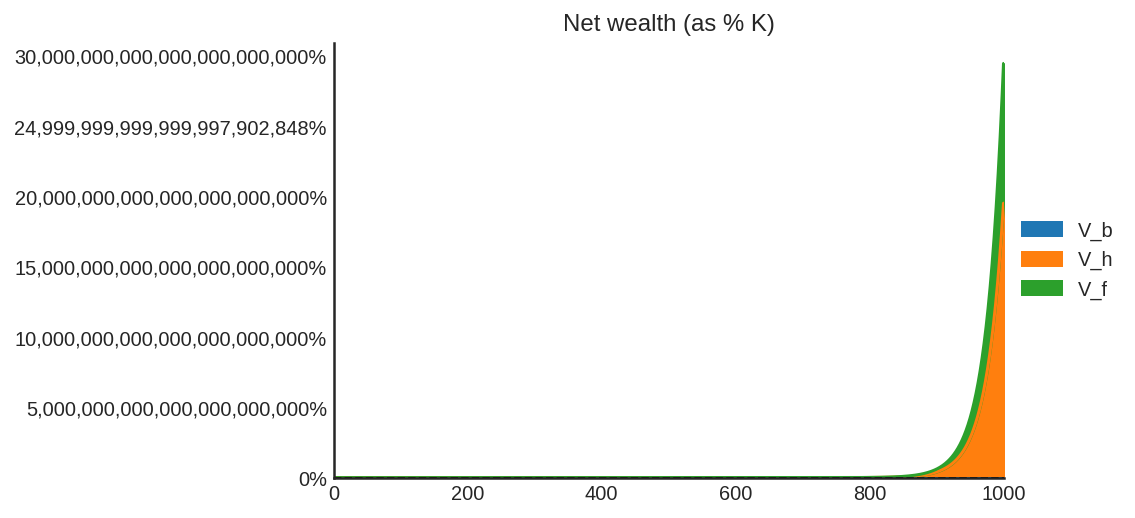

In [13]:
ax = df[['V_b', 'V_h', 'V_f']].apply(lambda x: np.abs(x)/df['K_k']).plot(kind = 'area', stacked = True, title = "Net wealth (as % K)")
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
ax.axhline(y=1, color = "black", ls = "--", lw=1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()
plt.show()

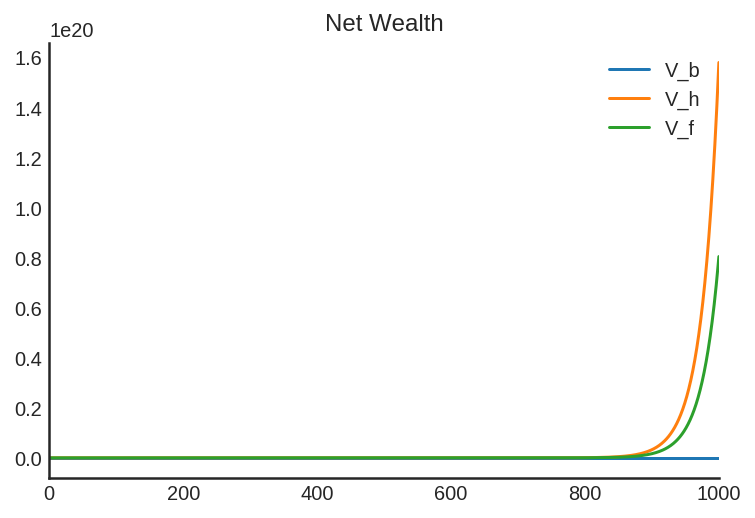

In [14]:
df[["V_b", "V_h", "V_f"]].plot(title = "Net Wealth")
sns.despine()
plt.show()

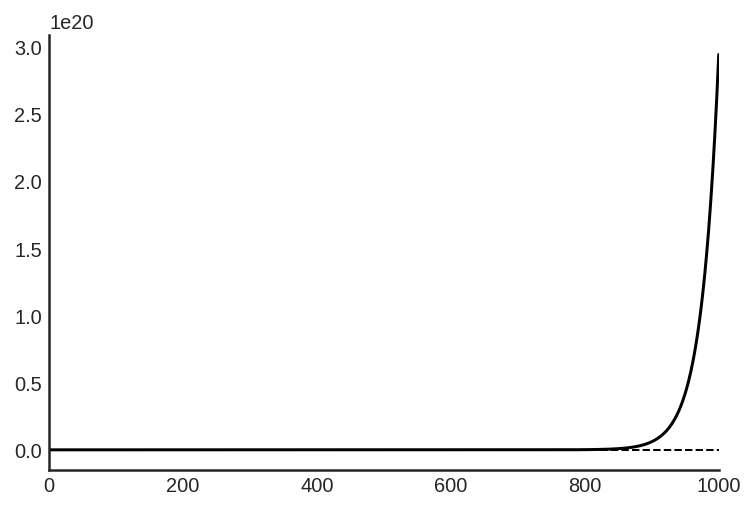

In [15]:
ax = ((df['V_b'] + df['V_f'] + df['V_h'] - df['K_k'])/df['K_k']).plot(label='Consistensy check', color='black')
ax.axhline(y=0, color = "black", ls = "--", lw=1)
sns.despine()
plt.show()

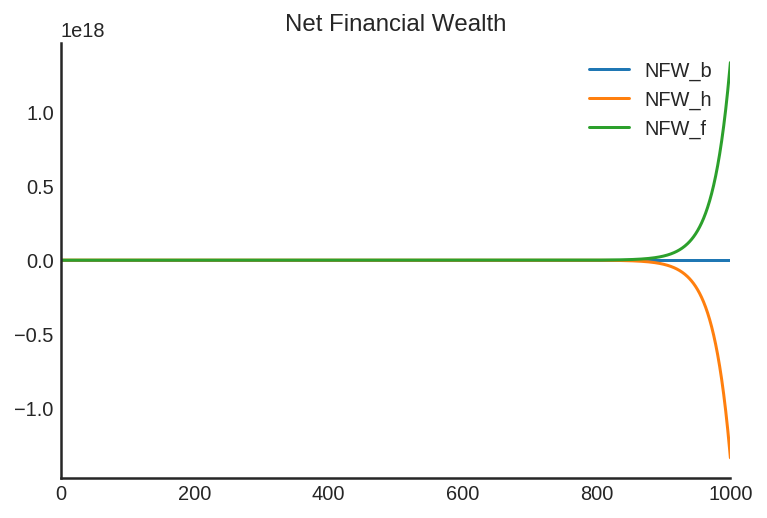

In [16]:
df[["NFW_b", "NFW_h", "NFW_f"]].plot(title = "Net Financial Wealth")
sns.despine()
plt.show()

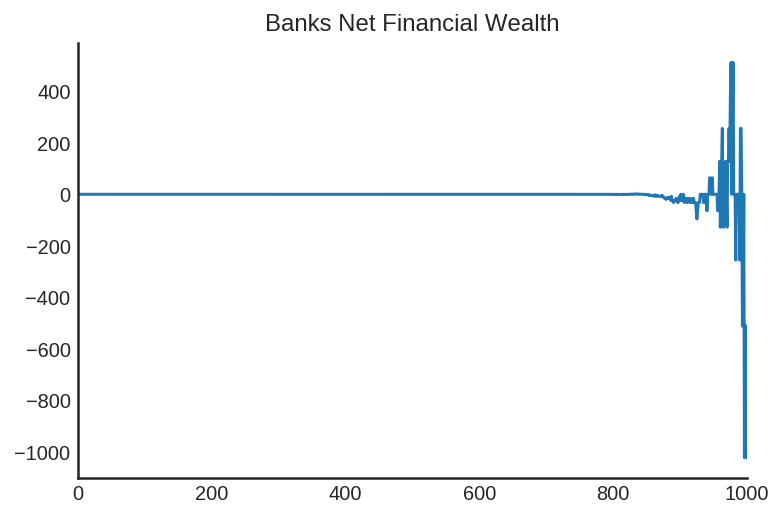

In [17]:
df['NFW_b'].plot(title = "Banks Net Financial Wealth")
sns.despine()
plt.show()

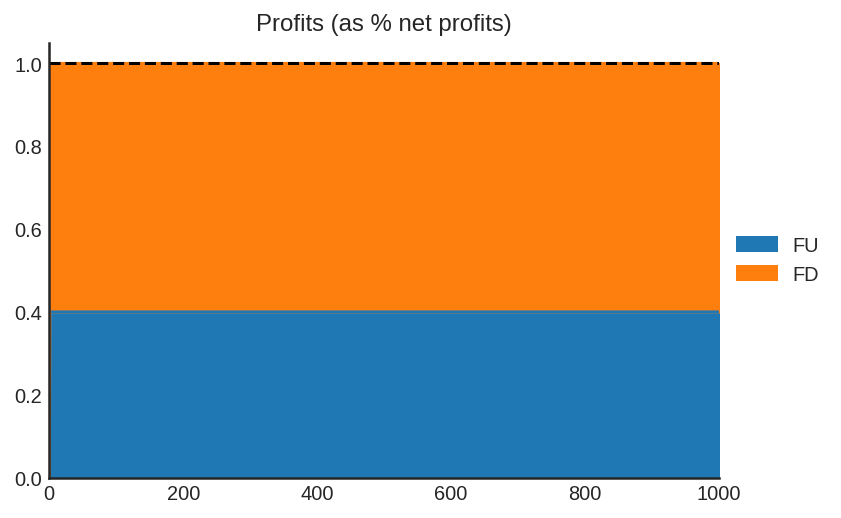

In [18]:
ax = df[["FU", "FD"]].apply(lambda x: x/df["Fn"]).plot(kind = "area", stacked = True, title = "Profits (as % net profits)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.axhline(y = 1, color = "black", ls = "--")
sns.despine()
plt.show()

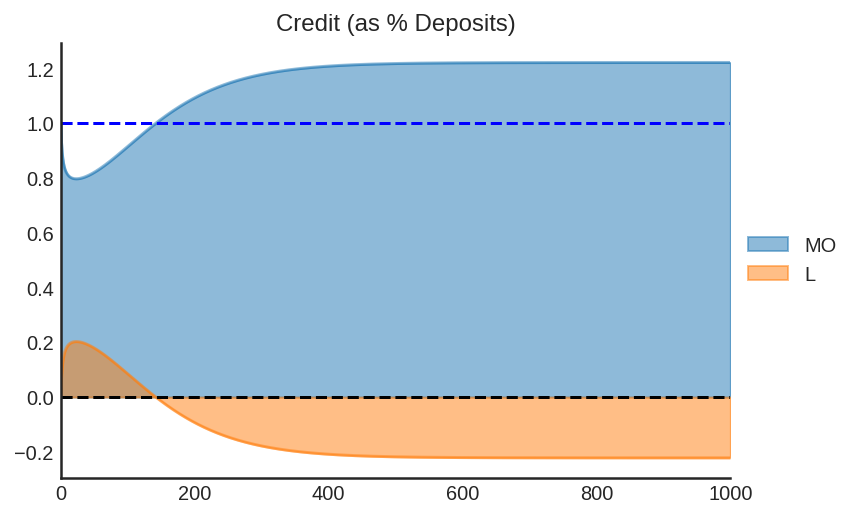

In [19]:
ax = df[["MO", "L"]].apply(lambda x: x/df["M"]).plot(kind = "area",stacked = False ,title = "Credit (as % Deposits)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.axhline(y = 1, color = "blue", ls = "--")
ax.axhline(y = 0, color = "black", ls = "--")
sns.despine()
plt.show()

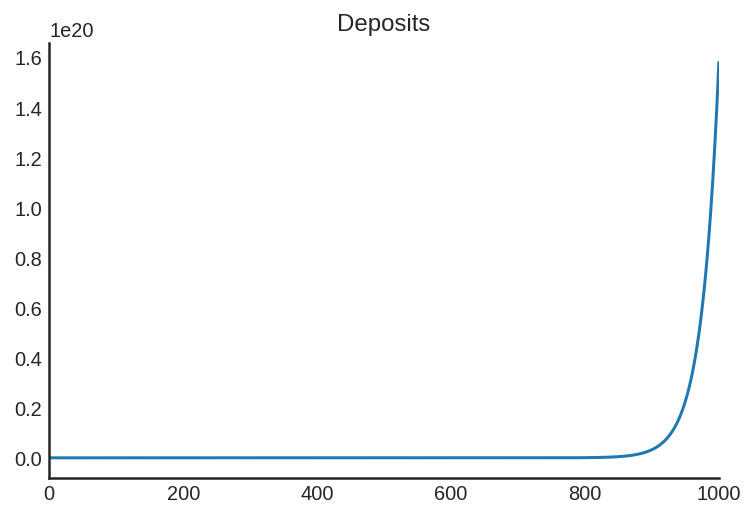

In [20]:
df["M"].plot(title = "Deposits")
sns.despine()
plt.show()

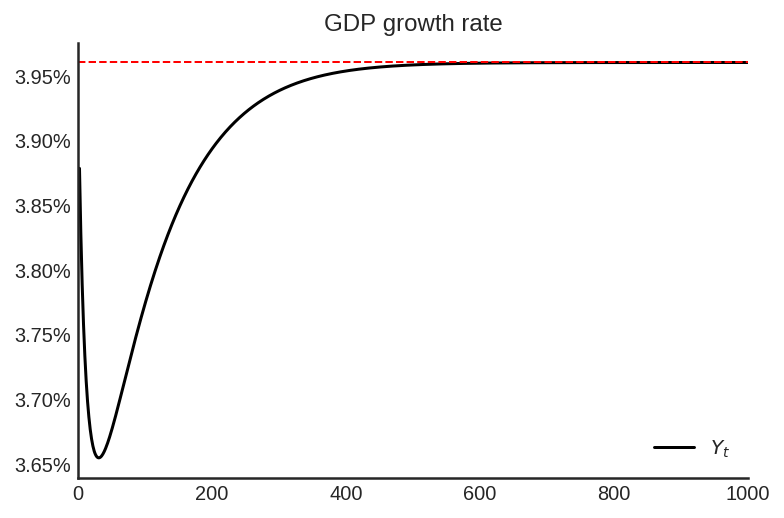

In [21]:
ax = df['Y'].pct_change().plot(color = "black", title = "GDP growth rate", label = "$Y_t$", legend = True)
ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
ax.axhline(y=df["g_Z"].iloc[-1], color = "red", ls = "--", lw=1, label = "Autonomous growth rate")
sns.despine()
plt.show()

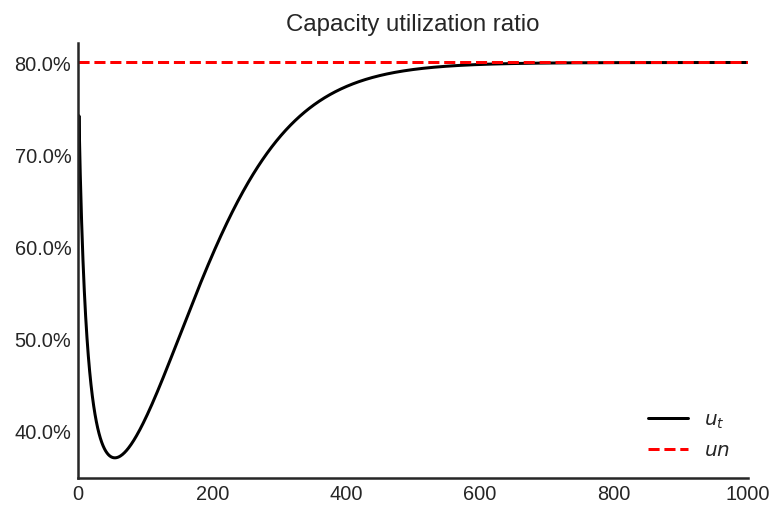

In [22]:
ax = df['u'].plot(color = "black", title = "Capacity utilization ratio", label = "$u_t$", legend = True)
ax.set_yticklabels(['{:,.1%}'.format(x) for x in ax.get_yticks()])
ax = df['un'].plot(color = "red", ls="--",  title = "Capacity utilization ratio", label = "$un$", legend = True)
ax.set_yticklabels(['{:,.1%}'.format(x) for x in ax.get_yticks()])
sns.despine()
plt.show()

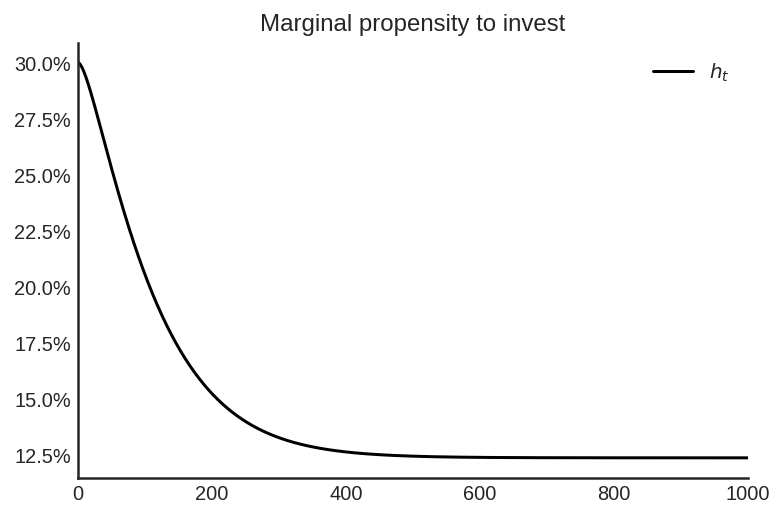

In [23]:
ax = df['h'].plot(color = "black", ls="-",  title = "Marginal propensity to invest", label = "$h_t$", legend = True)
ax.set_yticklabels(['{:,.1%}'.format(x) for x in ax.get_yticks()])
sns.despine()
plt.show()

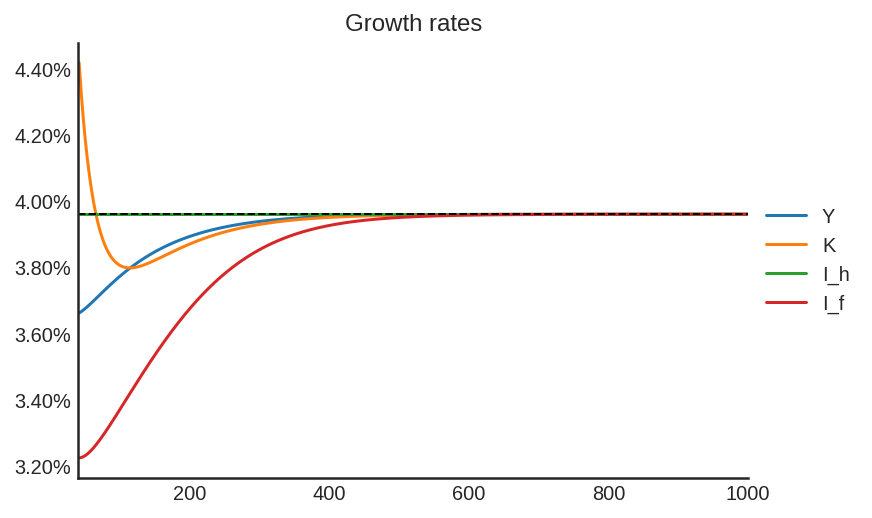

In [24]:
ax = df[["Y", "K", "I_h", "I_f"]][40:].pct_change().plot(title = "Growth rates")
ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
ax.axhline(y=df["g_Z"].iloc[-1], color = "black", ls = "--", lw=1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()
plt.show()

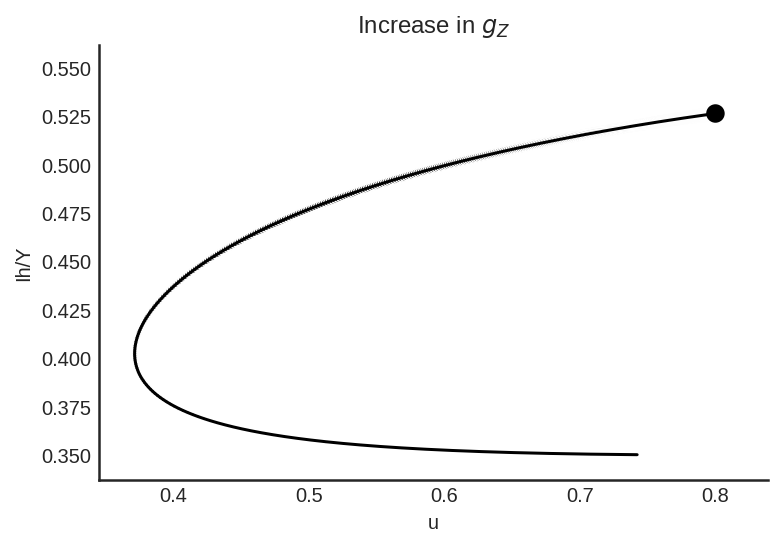

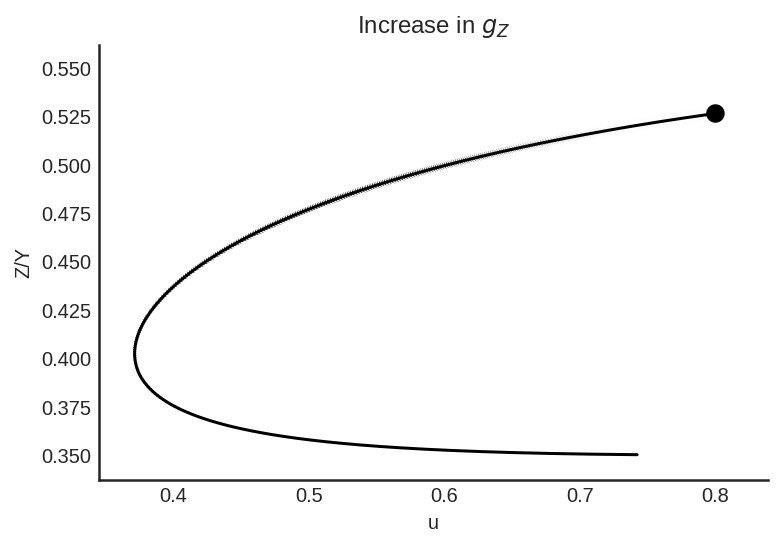

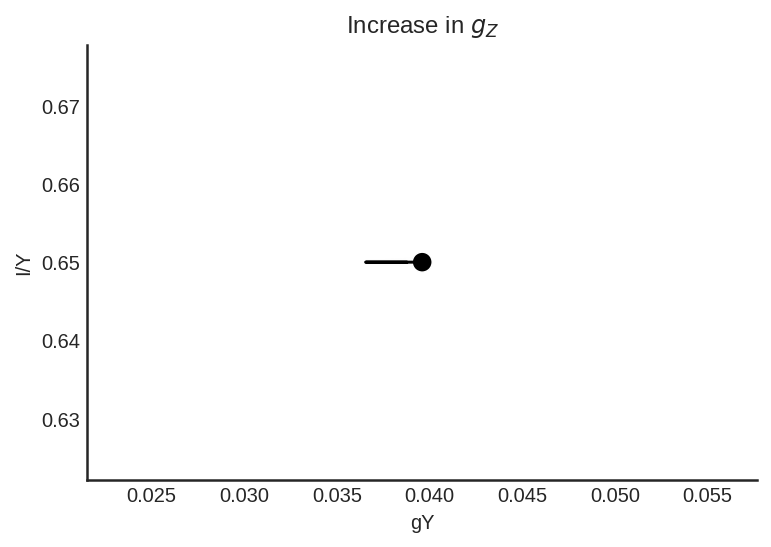

In [25]:
df["TIME"] = [i+1 for i in range(len(df.index))]
df["Ih/Y"] = df["I_h"]/df["Y"]
df["I/Y"] = df["I_t"]/df["Y"]
df["Z/Y"] = df["Z"]/df["Y"]
df["gY"] = df["Y"].pct_change()

sns.scatterplot(y = 'Ih/Y', x='u', data=df, size="TIME", sizes = (1,100), color = 'black', legend=False)
sns.lineplot(y = 'Ih/Y', x='u', data=df, sort=False, color = 'black')
plt.title('Increase in $g_Z$')
sns.despine()
plt.show()

sns.scatterplot(y = 'Z/Y', x='u', data=df, size="TIME", sizes = (1,100), color = 'black', legend=False)
sns.lineplot(y = 'Z/Y', x='u', data=df, sort=False, color = 'black')
plt.title('Increase in $g_Z$')
sns.despine()
plt.show()

sns.scatterplot(y = 'I/Y', x='gY', data=df, size="TIME", sizes = (1,100), color = 'black', legend=False)
sns.lineplot(y = 'I/Y', x='gY', data=df, sort=False, color = 'black')
plt.title('Increase in $g_Z$')
sns.despine()
plt.show()

# Shocks

In [26]:
def clock_plots(shock, filename, variable):
    shock["TIME"] = [i+1 for i in range(len(shock.index))]
    shock["Ih/Y"] = shock["I_h"]/shock["Y"]
    shock["I/Y"] = shock["I_t"]/shock["Y"]
    shock["Z/Y"] = shock["Z"]/shock["Y"]
    shock["gY"] = shock["Y"].pct_change()
    
    sns.set_context('talk')
    fig, ax = plt.subplots(1,3,figsize=(24,4)
                          )
    
    sns.scatterplot(y = 'Ih/Y', x='u', data=shock, size="TIME", sizes = (1,100), color = 'black', legend=False, ax=ax[0])
    sns.lineplot(y = 'Ih/Y', x='u', data=shock, sort=False, color = 'black', ax=ax[0])
    
    sns.scatterplot(y = 'Z/Y', x='u', data=shock, size="TIME", sizes = (1,100), color = 'black', legend=False, ax=ax[1])
    sns.lineplot(y = 'Z/Y', x='u', data=shock, sort=False, color = 'black', ax=ax[1])
    
    sns.scatterplot(y = 'I/Y', x='gY', data=shock, size="TIME", sizes = (1,100), color = 'black', legend=False, ax=ax[2])
    sns.lineplot(y = 'I/Y', x='gY', data=shock, sort=False, color = 'black', ax=ax[1])
    
    
    sns.despine()
    plt.show()
    
    fig.savefig(filename, dpi = 300)

In [27]:
def plot_shock(filename, shock):
    """
    This function plots some selected variables
    
    filename: name to save the plot (str)
    shock: df returned by ShockModel function
    """
    sns.set_context('talk')
    fig, ax = plt.subplots(2,2, figsize=(16,10))

    shock[["Y"]].pct_change().plot(title = "Growth rates", ax = ax[0,0], 
                                                      ls = ('--'), lw=3,
                                                      )
    shock[["K"]].pct_change().plot(title = "Growth rates", ax = ax[0,0], 
                                                      ls = (':'), lw=3
                                                      )
    shock[["I_h"]].pct_change().plot(title = "Growth rates", ax = ax[0,0], 
                                                      ls = ('-'), lw=3,
                                                      )
    shock[["I_f"]].pct_change().plot(title = "Growth rates", ax = ax[0,0], 
                                                      ls = ('-.'), lw=3,
                                                      )
    ax[0,0].axhline(y=shock["g_Z"].iloc[-1], color = "black", ls = "--", lw=2.5)
    #ax[0,0].set_yticklabels(['{:,.1%}'.format(x) for x in ax[0,0].get_yticks()])
    ax[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.06),
                   labels = ["$Y$", "$K$", "$I_h$", "$I_f$"],
              fancybox=True, shadow=True, ncol=2)
    ax[0,0].ticklabel_format(useOffset=False)

    ((shock["Z"]/shock['Y'])).plot(title = "Autonomous expenditure to income", ax = ax[0,1], ls = ('-'), lw=3, color='darkred')
    
    ax[0,1].set_ylim(auto=True)
    ax[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
                   labels=['$Z/Y$'],
              fancybox=True, shadow=True, ncol=2)

    shock['u'].plot(title = 'Capacity utilization ratio', ax=ax[1,0], legend = False, color = "darkred", lw = 3, )
    ax[1,0].axhline(y = shock['un'].iloc[-1], ls ='--', color = "gray")
    #ax[1,0].set_yticklabels(['{:,.2%}'.format(x) for x in ax[1,0].get_yticks()])
    ax[1,0].ticklabel_format(useOffset=False)

    shock['h'].plot(title = 'Marginal propensity to invest', ax=ax[1,1], legend = False, color = "darkred", lw = 3, )
    ax[1,1].axhline(y = df['h'].iloc[-1], ls ='--', color = "gray")
    ax[1,1].ticklabel_format(useOffset=False)
    
    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    fig.savefig(filename, dpi = 300)

In [28]:
def plot_norms(filename, shock):
    """
    This function plots some selected variables
    
    filename: name to save the plot (str)
    shock: df returned by ShockModel function
    """
    sns.set_context('talk')
    fig, ax = plt.subplots(2,2, figsize=(16,10))

    (shock["YD"]/shock['V_h']).plot(title = "Flow/Stock", ax = ax[0,0], ls = (':'), lw=3)
    (shock["YD"]/shock['V_hr']).plot(title = "Flow/Stock", ax = ax[0,0], ls = ('-'), lw=3)
    (shock["FU"]/shock['V_f']).plot(ax = ax[0,0], ls = ('-'), lw=3)
    
    ax[0,0].set_yticklabels(['{:,.1%}'.format(x) for x in ax[0,0].get_yticks()])
    ax[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
                   labels = [
                       "$YD/V_h$",
                       "$YD/V_hr$",
                       "$FU/V_f$",
                            ],
              fancybox=True, shadow=True, ncol=2)
    #ax[0,0].ticklabel_format(useOffset=False)
    
    shock['K_k'].plot(color = "darkred", title = "Houses \nas % of Total capital", label = "$\k$", legend = False, ax = ax[0,1], lw = 3, )
    ax[0,1].axhline(y = df['K_k'].iloc[-1], ls ='--', color = "gray")
    ax[0,1].ticklabel_format(useOffset=False)
    
    (shock["MO"]*shock["rmo"][1:]/shock['YD'][1:]).plot(title="Mortgage payment share", ax = ax[1,0], ls = ('-'), lw=3)
    (shock["MO"]*shock["rmo"][1:]/shock['W'][1:]).plot( ax = ax[1,0], ls = ('-'), lw=3)
    ax[1,0].set_yticklabels(['{:,.1%}'.format(x) for x in ax[1,0].get_yticks()])
    ax[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                   labels = [
                       '$MO_{-1}\cdot rmo/YD$',
                       '$MO_{-1}\cdot rmo/W$',
                            ],
              fancybox=True, shadow=True, ncol=2)
    
    shock[['I_f', 'I_h']].apply(lambda x: x/shock['I_t']).plot(kind = 'area', stacked = True, legend = True, title = "Residential and Non-residential Investiment (as % of total investment)", ax=ax[1,1])
    ax[1,1].axhline(y=1, color = "black", ls = "--", lw=1)
    ax[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
                   labels = [
                       "$I_f$",
                       "$I_h$"
                            ],
              fancybox=True, shadow=True, ncol=2)

    
    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    fig.savefig(filename, dpi = 300)

In [29]:
def other_plots(shock):

    (shock['MO']/(shock['M'])).plot(title="Mortgage as % of deposits")
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots()
    (shock['FT']/shock['K_f']).plot(ax=ax, label='Gross profit rate')
    (shock['Fn']/shock['K_f']).plot(ax=ax, label='Net profit rate')
    ax.legend()
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots()
    (shock['YD']/shock['K_HD']).plot(ax=ax, label='Real', title="Disposible income as % of Housing")
    (shock['YD']/(shock['K_HD']*shock['ph'])).plot(ax=ax, label='Nominal')
    ax.legend()
    sns.despine()
    plt.show()
    
    
    fig, ax = plt.subplots(2,2, figsize=(16,10))
    (shock['W'][1:]/shock['K_HD']).plot(ax=ax[0,0], label='Real', title="Wages (t) as % of Housing (t-1)")
    (shock['W'][1:]/(shock['K_HD']*shock['ph'])).plot(ax=ax[0,0], label='Nominal', title="Wages as % of Housing")
    ax[0,0].legend()
    
    shock['omega'][1:].plot(ax=ax[1,0], label='Wage share', legend=True, color='black',)
    ax[1,0].legend()
    (shock['Y'][1:]/shock['Z'][1:]).plot(ax=ax[0,1], label='1/multiplier', color='black',)
    ax[0,1].legend()
    shock['g_Z'][1:].plot(ax=ax[1,1], label='$g_Z$', color='black',)
    ax[1,1].legend()
    
    sns.despine()
    plt.show()

## Increase in autonomous growth rate ($g_z$)

In [30]:
base = model()
df = SolveSFC(base, time=900)
shock = ShockModel(base_model=base, create_function=model(), variable='phi_0', increase=0.01, time = 1200)
shock.transpose()

0             1             2             3     \
C         1.005827e+17  1.045657e+17  1.087065e+17  1.130113e+17   
FD        9.453423e+16  9.827778e+16  1.021696e+17  1.062155e+17   
Fn        1.575570e+17  1.637963e+17  1.702826e+17  1.770258e+17   
FT        1.436895e+17  1.493796e+17  1.552950e+17  1.614447e+17   
FU        6.302282e+16  6.551852e+16  6.811306e+16  7.081033e+16   
...                ...           ...           ...           ...   
_h__1     1.237542e-01  1.237542e-01  1.237542e-01  1.237541e-01   
_L__1    -7.208345e+17 -7.208345e+17 -7.493803e+17 -7.790566e+17   
_K_HD__1  3.970222e+18  3.970222e+18  4.127443e+18  4.290890e+18   
_I_h__1   1.512320e+17  1.512320e+17  1.572208e+17  1.634467e+17   
_ph__1    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                  4             5             6             7     \
C         1.174865e+17  1.221390e+17  1.269757e+17  1.320039e+17   
FD        1.104216e+17  1.147943e+17  1.193402e+17  1.240661e+17   
Fn        1.840361e+17  1.913239e+17  1.989003e+17  2.067768e+17   
FT        1.678379e+17  1.744843e+17  1.813938e+17  1.885770e+17   
FU        7.361442e+16  7.652955e+16  7.956012e+16  8.271070e+16   
...                ...           ...           ...           ...   
_h__1     1.237541e-01  1.237540e-01  1.237539e-01  1.237539e-01   
_L__1    -8.099080e+17 -8.419812e+17 -8.753245e+17 -9.099883e+17   
_K_HD__1  4.460809e+18  4.637457e+18  4.821101e+18  5.012016e+18   
_I_h__1   1.699192e+17  1.766480e+17  1.836433e+17  1.909156e+17   
_ph__1    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                  8             9     ...          1241          1242  \
C         1.372312e+17  1.426656e+17  ...  8.161916e+42  8.566747e+42   
FD        1.289791e+17  1.340866e+17  ...  7.298637e+42  7.660649e+42   
Fn        2.149651e+17  2.234777e+17  ...  1.216439e+43  1.276775e+43   
FT        1.960446e+17  2.038080e+17  ...  1.165988e+43  1.223821e+43   
FU        8.598605e+16  8.939110e+16  ...  4.865758e+42  5.107100e+42   
...                ...           ...  ...           ...           ...   
_h__1     1.237538e-01  1.237538e-01  ...  1.549999e-01  1.549999e-01   
_L__1    -9.460247e+17 -9.834882e+17  ... -2.522576e+43 -2.647695e+43   
_K_HD__1  5.210492e+18  5.416827e+18  ...  2.327275e+44  2.442708e+44   
_I_h__1   1.984758e+17  2.063355e+17  ...  1.099779e+43  1.154328e+43   
_ph__1    1.000000e+00  1.000000e+00  ...  1.000000e+00  1.000000e+00   

                  1243          1244          1245          1246  \
C         8.991657e+42  9.437644e+42  9.905751e+42  1.039708e+43   
FD        8.040617e+42  8.439432e+42  8.858028e+42  9.297386e+42   
Fn        1.340103e+43  1.406572e+43  1.476338e+43  1.549564e+43   
FT        1.284522e+43  1.348235e+43  1.415107e+43  1.485297e+43   
FU        5.360412e+42  5.626288e+42  5.905352e+42  6.198257e+42   
...                ...           ...           ...           ...   
_h__1     1.549999e-01  1.549999e-01  1.549999e-01  1.549999e-01   
_L__1    -2.779021e+43 -2.916860e+43 -3.061537e+43 -3.213389e+43   
_K_HD__1  2.563866e+44  2.691034e+44  2.824509e+44  2.964604e+44   
_I_h__1   1.211583e+43  1.271677e+43  1.334753e+43  1.400956e+43   
_ph__1    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                  1247          1248          1249          1250  
C         1.091277e+43  1.145404e+43  1.202217e+43  1.261846e+43  
FD        9.758536e+42  1.024256e+43  1.075059e+43  1.128382e+43  
Fn        1.626423e+43  1.707093e+43  1.791765e+43  1.880637e+43  
FT        1.558967e+43  1.636292e+43  1.717452e+43  1.802638e+43  
FU        6.505691e+42  6.828373e+42  7.167061e+42  7.522547e+42  
...                ...           ...           ...           ...  
_h__1     1.549999e-01  1.549999e-01  1.549999e-01  1.549999e-01  
_L__1    -3.372773e+43 -3.540062e+43 -3.715649e+43 -3.899945e+43  
_K_HD__1  3.111649e+44  3.265987e+44  3.427980e+44  3.598007e+44  
_I_h__1   1.470444e+

In [31]:
summary = SummaryShock(shock)
summary

0         Shock             1             2  \
C         7.011889e+17  7.359812e+17  7.725134e+17  8.108730e+17   
FD        6.590261e+17  6.911452e+17  7.248647e+17  7.602647e+17   
Fn        1.098377e+18  1.151909e+18  1.208108e+18  1.267108e+18   
FT        1.001698e+18  1.051402e+18  1.103591e+18  1.158390e+18   
FU        4.393507e+17  4.607634e+17  4.832431e+17  5.068432e+17   
...                ...           ...           ...           ...   
_h__1     1.237522e-01  1.237522e-01  1.237617e-01  1.237805e-01   
_L__1    -4.833919e+18 -5.025345e+18 -5.225861e+18 -5.435899e+18   
_K_HD__1  2.662331e+19  2.767760e+19  2.878417e+19  2.994563e+19   
_I_h__1   1.014124e+18  1.054283e+18  1.106576e+18  1.161462e+18   
_ph__1    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                     3           t-1             t    difference  
C         8.511514e+17  1.202217e+43  1.261846e+43  5.962994e+41  
FD        7.974292e+17  1.075059e+43  1.128382e+43  5.332293e+41  
Fn        1.329049e+18  1.791765e+43  1.880637e+43  8.887155e+41  
FT        1.215931e+18  1.717452e+43  1.802638e+43  8.518563e+41  
FU        5.316195e+17  7.167061e+42  7.522547e+42  3.554862e+41  
...                ...           ...           ...           ...  
_h__1     1.238083e-01  1.549999e-01  1.549999e-01  7.668560e-10  
_L__1    -5.655905e+18 -3.715649e+43 -3.899945e+43 -1.842961e+42  
_K_HD__1  3.116470e+19  3.427980e+44  3.598007e+44  1.700278e+43  
_I_h__1   1.219070e+18  1.619929e+43  1.700278e+43  8.034850e+41  
_ph__1    1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00  

[64 rows x 8 columns]

In [32]:
shock1 = shock.round(decimals = 5).tail(1).transpose().loc['alpha':,:]
shock1.columns = ['$\Delta \phi_0$']
shock1

$\Delta \phi_0$
alpha         7.000000e-01
gamma_F       4.000000e-01
gamma_u       1.000000e-02
omega         5.000000e-01
rm            2.000000e-02
spread_l      0.000000e+00
spread_mo     0.000000e+00
un            8.000000e-01
v             2.500000e+00
phi_0         5.000000e-02
phi_1         2.000000e-02
phparam       1.000000e+00
infla         0.000000e+00
gZn           3.922000e-02
_K_f__1       1.126648e+44
_M__1         3.208013e+44
_MO__1        3.598007e+44
_Lf__1       -3.899945e+43
_h__1         1.550000e-01
_L__1        -3.899945e+43
_K_HD__1      3.598007e+44
_I_h__1       1.700278e+43
_ph__1        1.000000e+00

### Plots

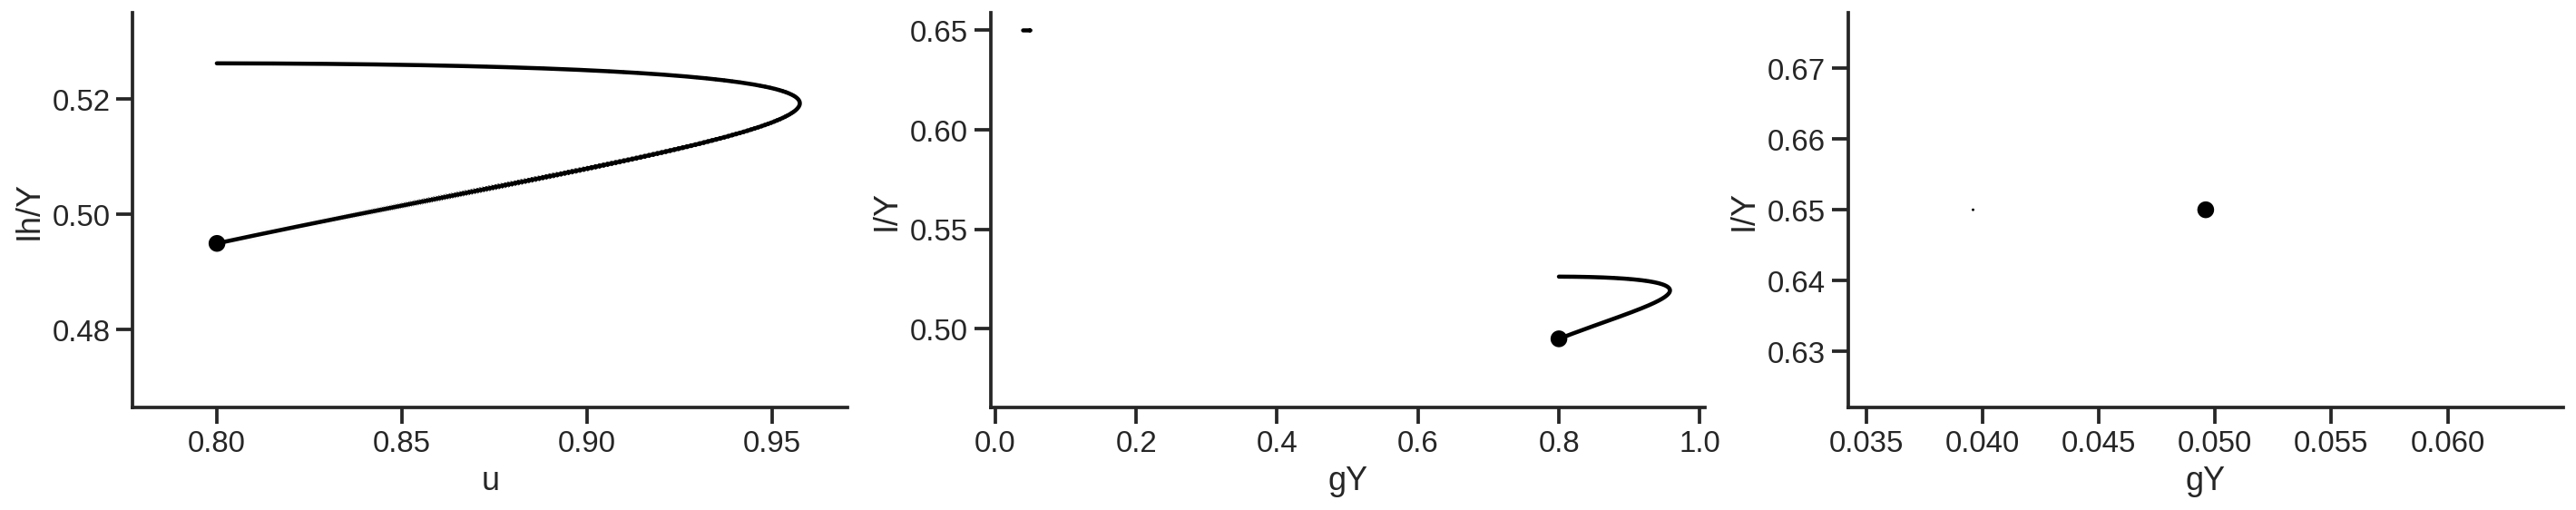

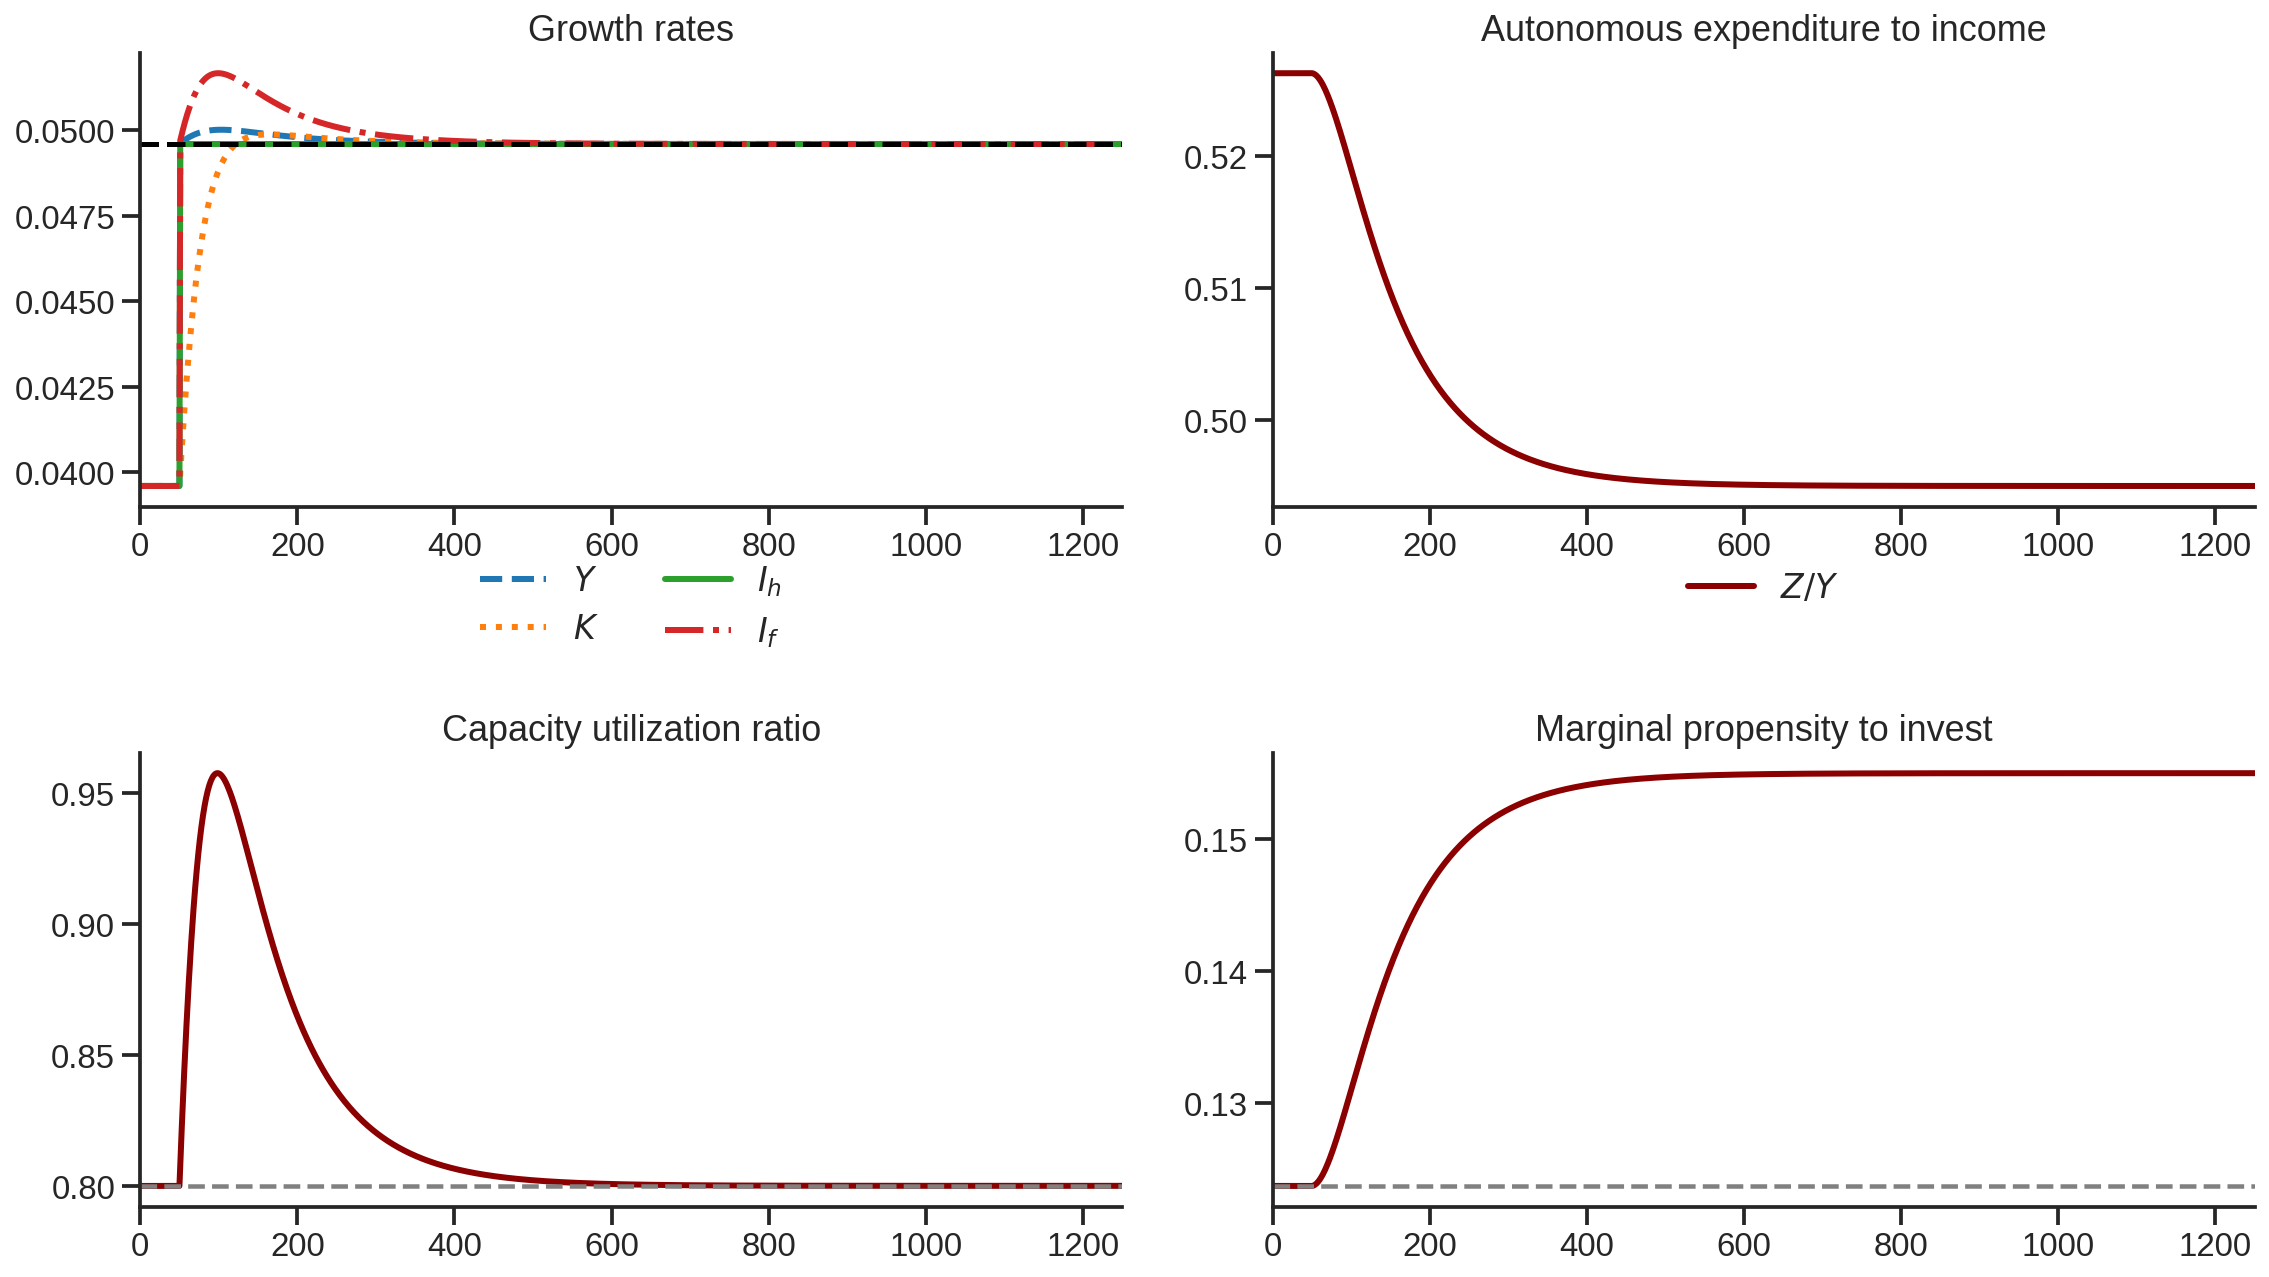

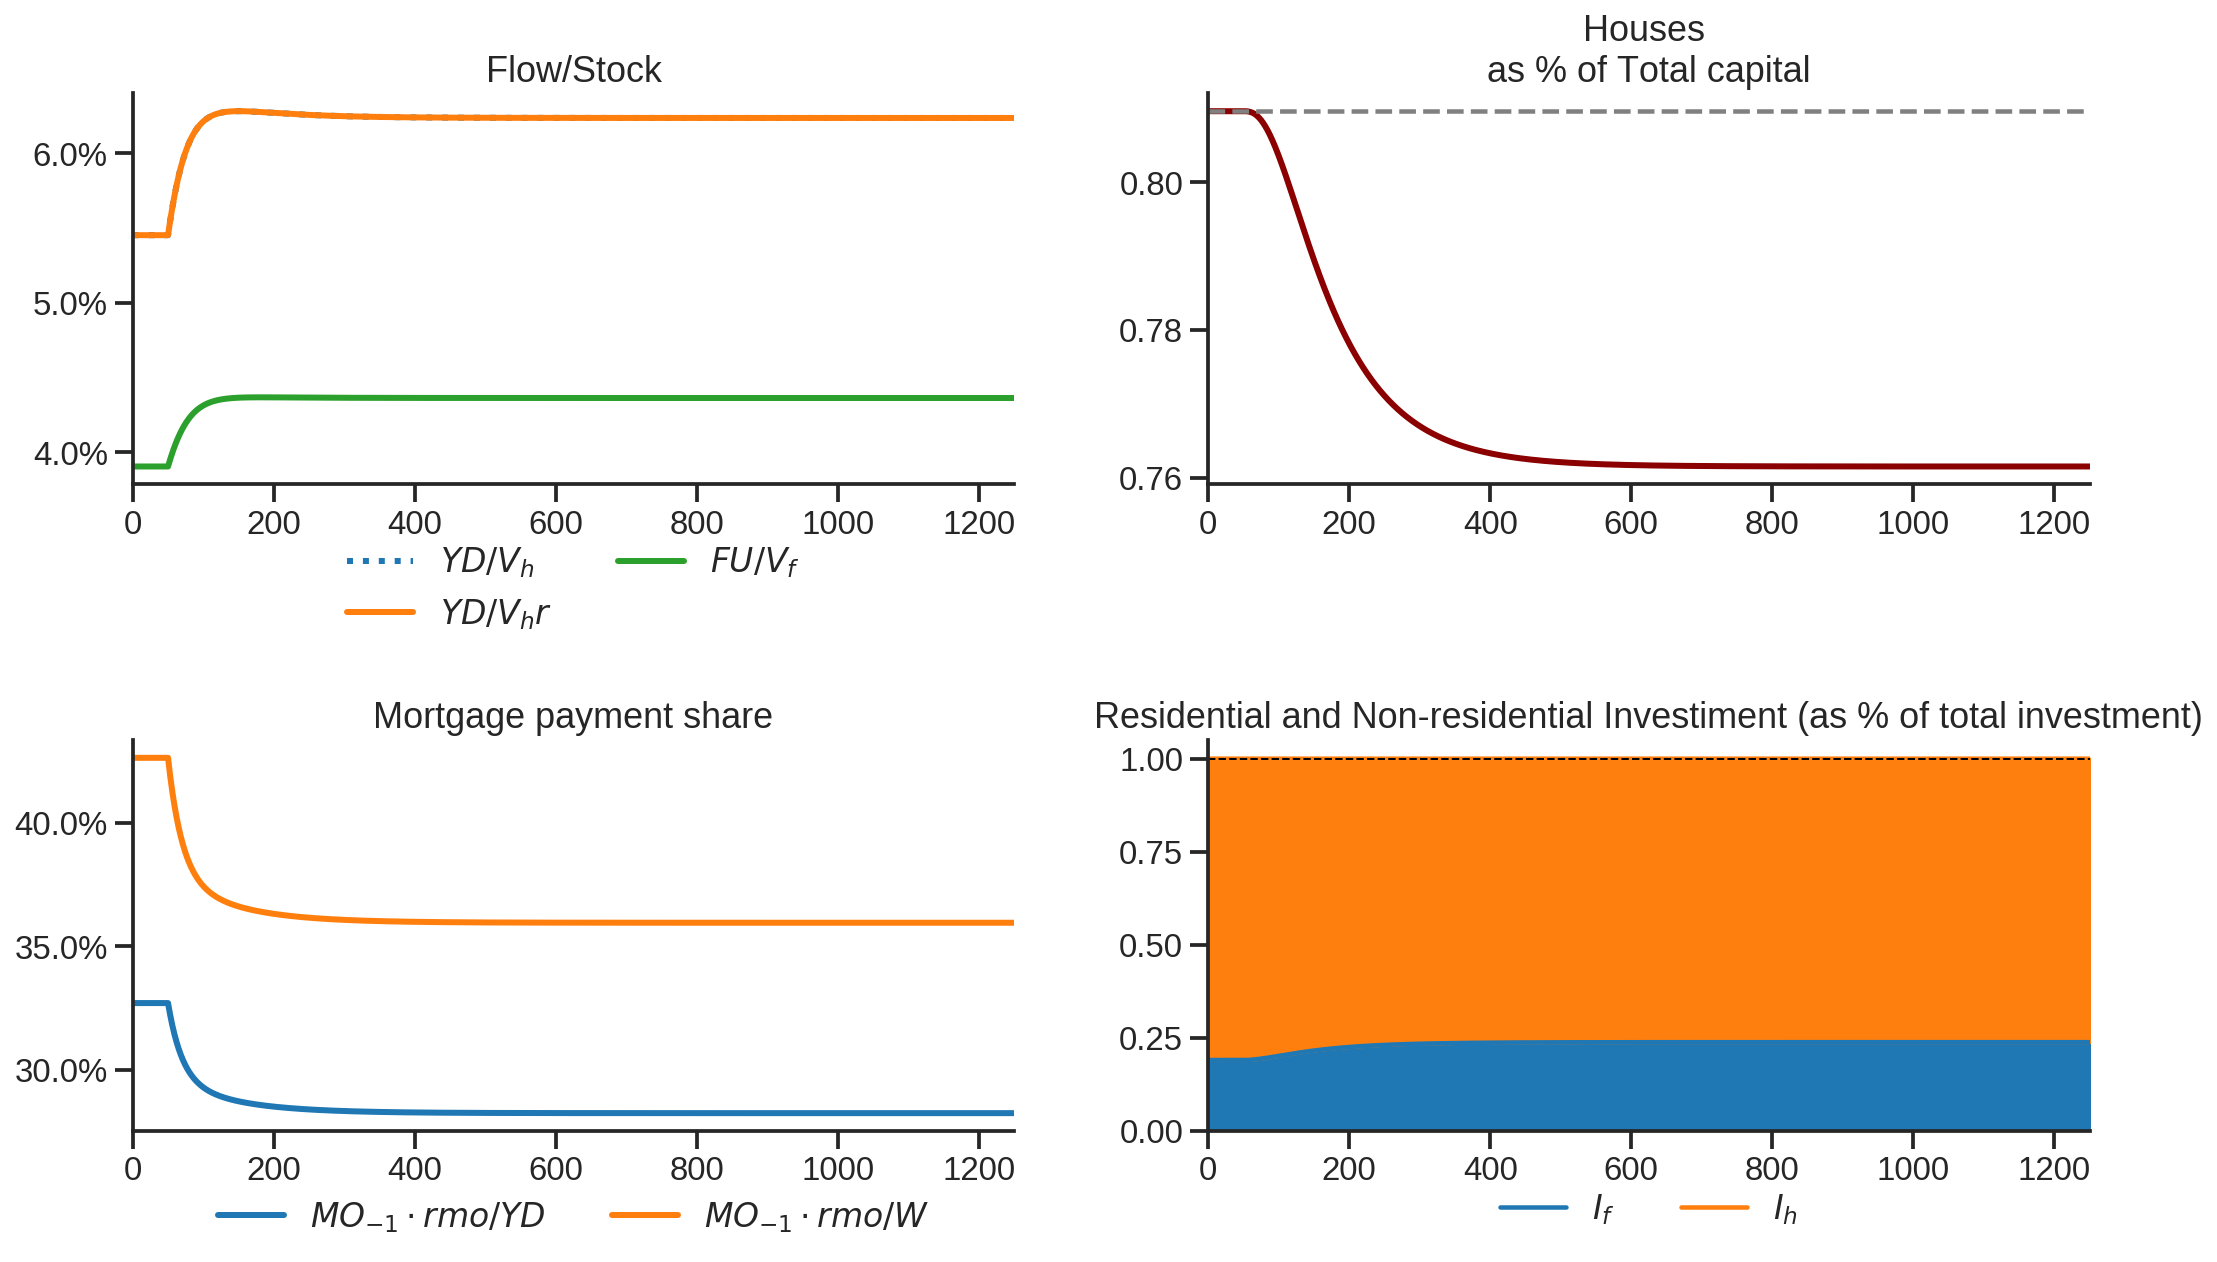

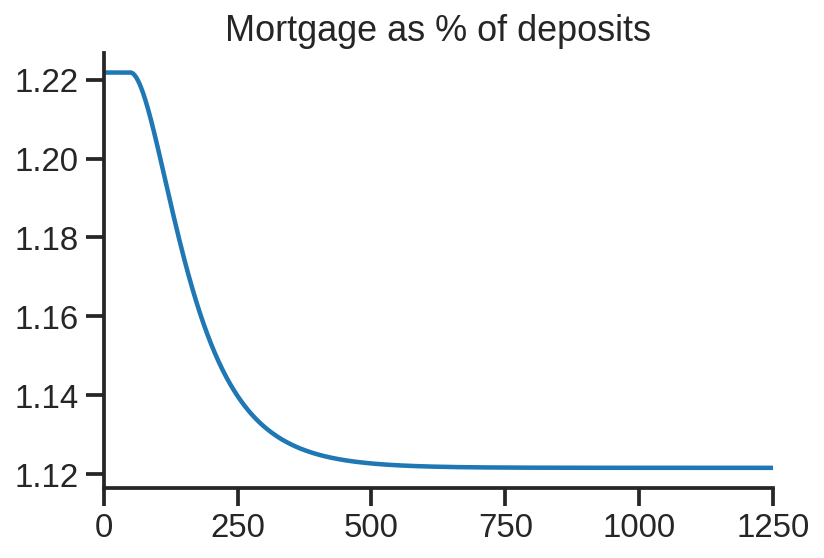

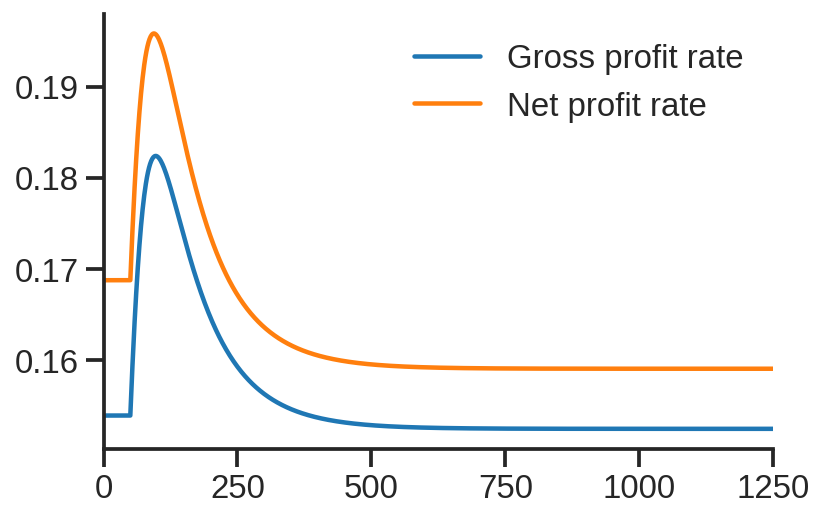

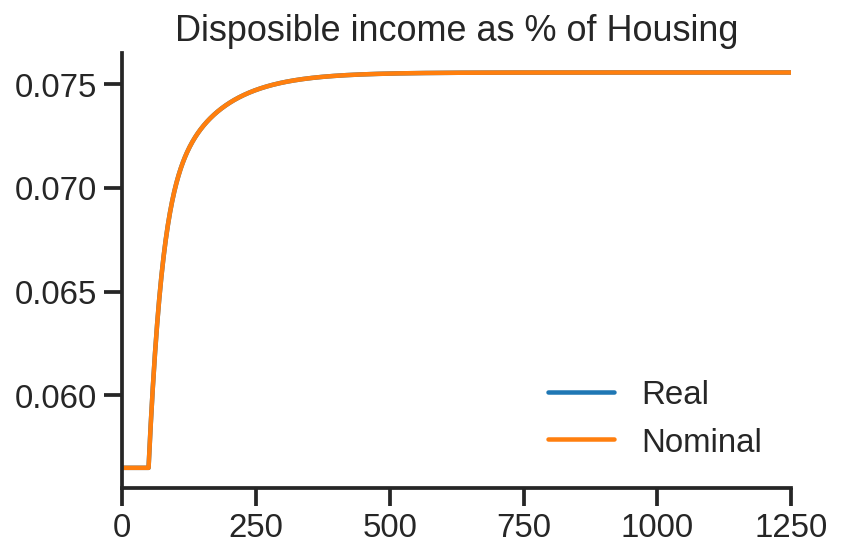

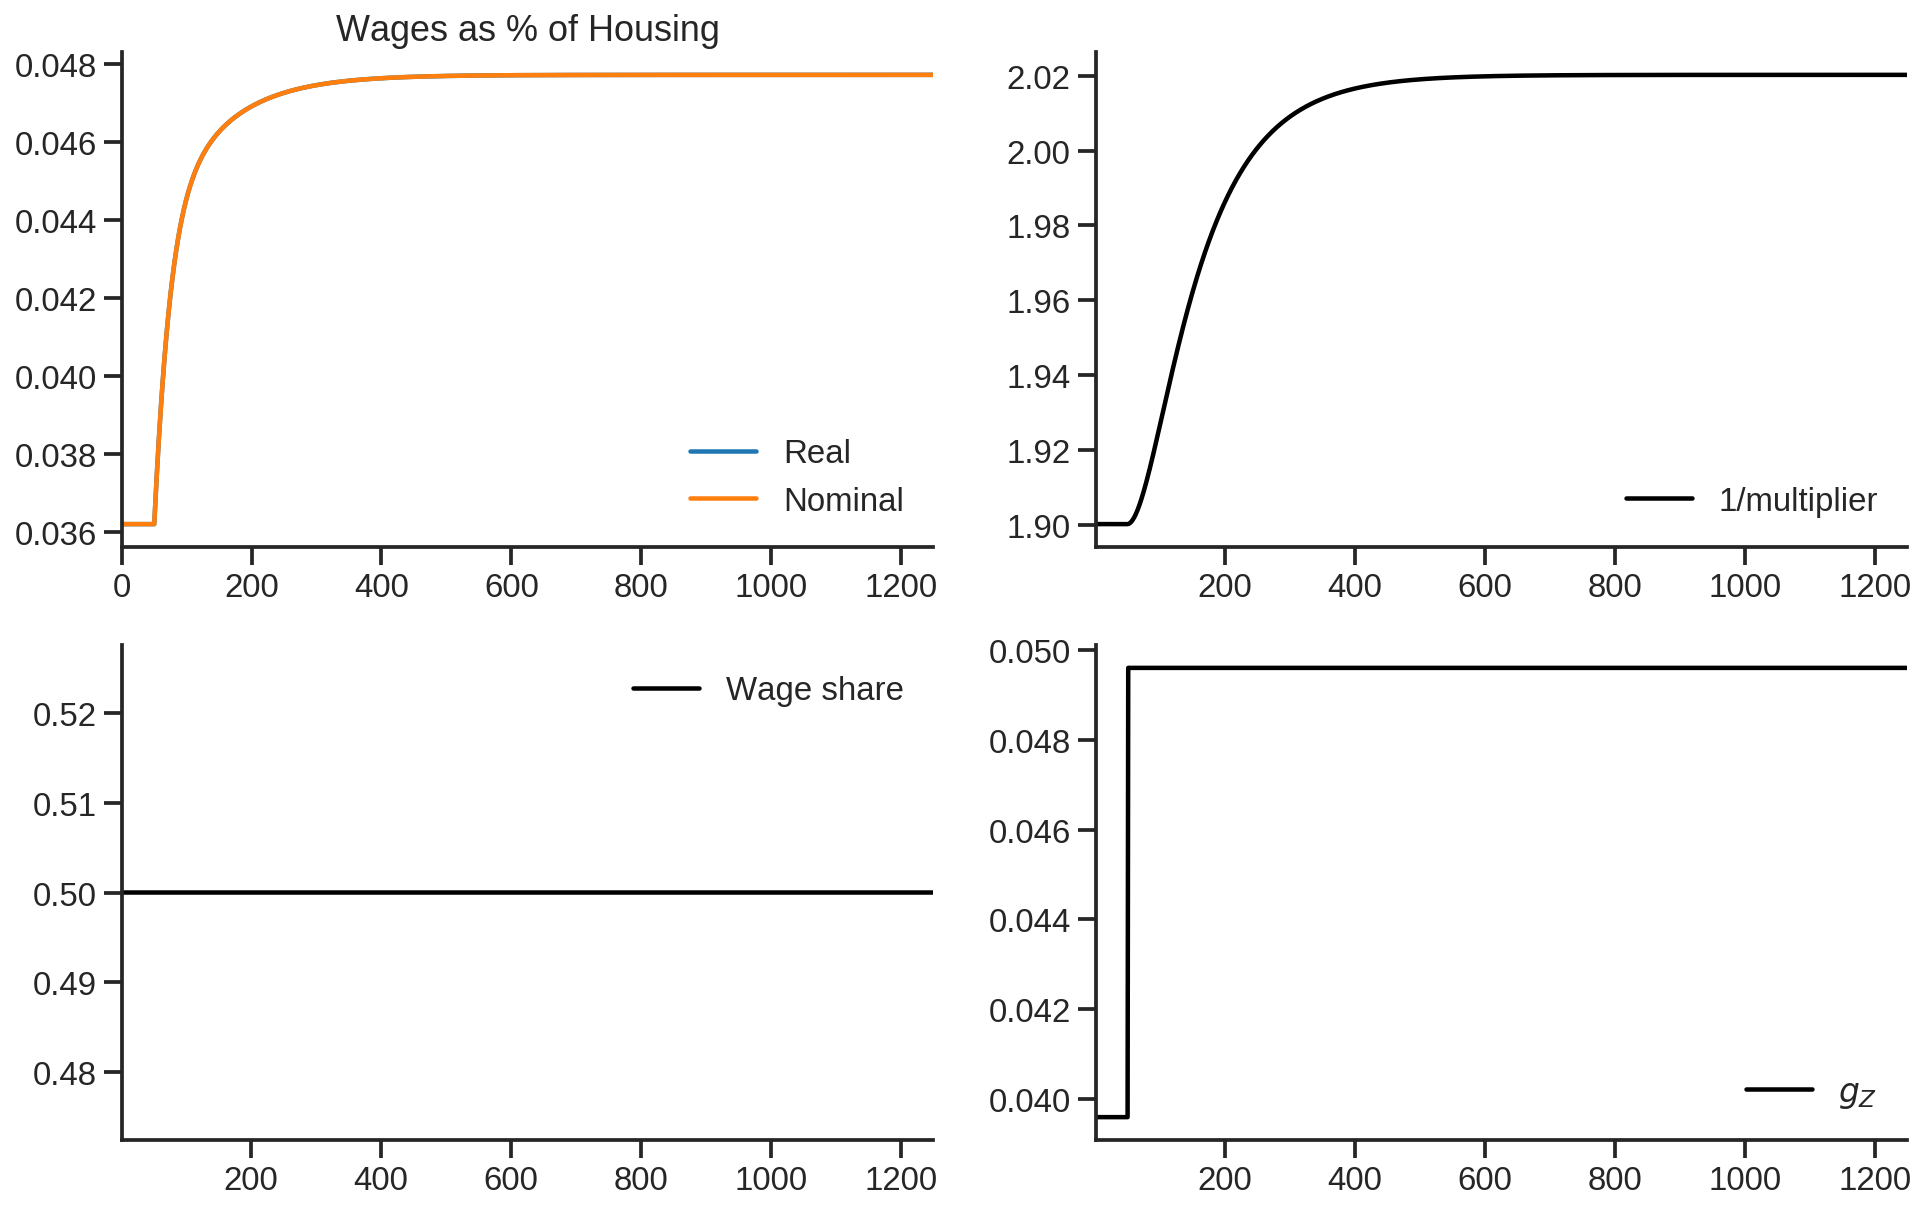

In [33]:
clock_plots(shock = shock, filename = 'Clock_1.png', variable='g_Z')
plot_shock(shock = shock, filename = 'Shock_1.png')
plot_norms(shock = shock, filename = 'Shock_1Norms.png')
other_plots(shock)

## Decrease in wage-share ($\omega$)

In [34]:
base = model()
df = SolveSFC(base, time=700)
shock = ShockModel(base_model=base, create_function=model(), variable='omega', increase=-0.05, time = 900)
shock.transpose()

0             1             2             3    \
C         4.259042e+13  4.427693e+13  4.603024e+13  4.785297e+13   
FD        4.002538e+13  4.161039e+13  4.325816e+13  4.497118e+13   
Fn        6.670897e+13  6.935064e+13  7.209693e+13  7.495197e+13   
FT        6.084345e+13  6.325276e+13  6.575748e+13  6.836139e+13   
FU        2.668359e+13  2.774026e+13  2.883877e+13  2.998079e+13   
...                ...           ...           ...           ...   
_h__1     1.238062e-01  1.238062e-01  1.238054e-01  1.238047e-01   
_L__1    -3.048940e+14 -3.048940e+14 -3.169722e+14 -3.295288e+14   
_K_HD__1  1.680973e+15  1.680973e+15  1.747539e+15  1.816742e+15   
_I_h__1   6.403090e+13  6.403090e+13  6.656652e+13  6.920255e+13   
_ph__1    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                   4             5             6             7    \
C         4.974788e+13  5.171783e+13  5.376579e+13  5.589485e+13   
FD        4.675204e+13  4.860342e+13  5.052811e+13  5.252902e+13   
Fn        7.792006e+13  8.100569e+13  8.421352e+13  8.754837e+13   
FT        7.106841e+13  7.388262e+13  7.680827e+13  7.984978e+13   
FU        3.116802e+13  3.240228e+13  3.368541e+13  3.501935e+13   
...                ...           ...           ...           ...   
_h__1     1.238040e-01  1.238033e-01  1.238027e-01  1.238020e-01   
_L__1    -3.425827e+14 -3.561537e+14 -3.702623e+14 -3.849297e+14   
_K_HD__1  1.888685e+15  1.963477e+15  2.041230e+15  2.122063e+15   
_I_h__1   7.194297e+13  7.479192e+13  7.775368e+13  8.083272e+13   
_ph__1    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                   8             9    ...           941           942  \
C         5.810821e+13  6.040922e+13  ...  2.671189e+29  2.776968e+29   
FD        5.460917e+13  5.677169e+13  ...  3.108337e+29  3.231427e+29   
Fn        9.101529e+13  9.461949e+13  ...  5.180561e+29  5.385711e+29   
FT        8.301173e+13  8.629888e+13  ...  4.663980e+29  4.848674e+29   
FU        3.640611e+13  3.784780e+13  ...  2.072224e+29  2.154285e+29   
...                ...           ...  ...           ...           ...   
_h__1     1.238013e-01  1.238006e-01  ...  1.237499e-01  1.237499e-01   
_L__1    -4.001780e+14 -4.160303e+14  ... -2.582903e+30 -2.685186e+30   
_K_HD__1  2.206097e+15  2.293458e+15  ...  1.201864e+31  1.249458e+31   
_I_h__1   8.403370e+13  8.736143e+13  ...  4.578088e+29  4.759381e+29   
_ph__1    1.000000e+00  1.000000e+00  ...  1.000000e+00  1.000000e+00   

                   943           944           945           946  \
C         2.886936e+29  3.001258e+29  3.120108e+29  3.243665e+29   
FD        3.359391e+29  3.492423e+29  3.630723e+29  3.774500e+29   
Fn        5.598985e+29  5.820705e+29  6.051205e+29  6.290833e+29   
FT        5.040682e+29  5.240293e+29  5.447808e+29  5.663541e+29   
FU        2.239594e+29  2.328282e+29  2.420482e+29  2.516333e+29   
...                ...           ...           ...           ...   
_h__1     1.237499e-01  1.237499e-01  1.237499e-01  1.237499e-01   
_L__1    -2.791519e+30 -2.902064e+30 -3.016985e+30 -3.136458e+30   
_K_HD__1  1.298936e+31  1.350374e+31  1.403849e+31  1.459441e+31   
_I_h__1   4.947852e+29  5.143787e+29  5.347481e+29  5.559241e+29   
_ph__1    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                   947           948           949           950  
C         3.372114e+29  3.505649e+29  3.644473e+29  3.788794e+29  
FD        3.923970e+29  4.079359e+29  4.240902e+29  4.408841e+29  
Fn        6.539950e+29  6.798932e+29  7.068170e+29  7.348069e+29  
FT        5.887818e+29  6.120975e+29  6.363366e+29  6.615355e+29  
FU        2.615980e+29  2.719573e+29  2.827268e+29  2.939228e+29  
...                ...           ...           ...           ...  
_h__1     1.237499e-01  1.237499e-01  1.237499e-01  1.237499e-01  
_L__1    -3.260662e+30 -3.389784e+30 -3.524019e+30 -3.663570e+30  
_K_HD__1  1.517235e+31  1.577318e+31  1.639779e+31  1.704715e+31  
_I_h__1   5.779387e+2

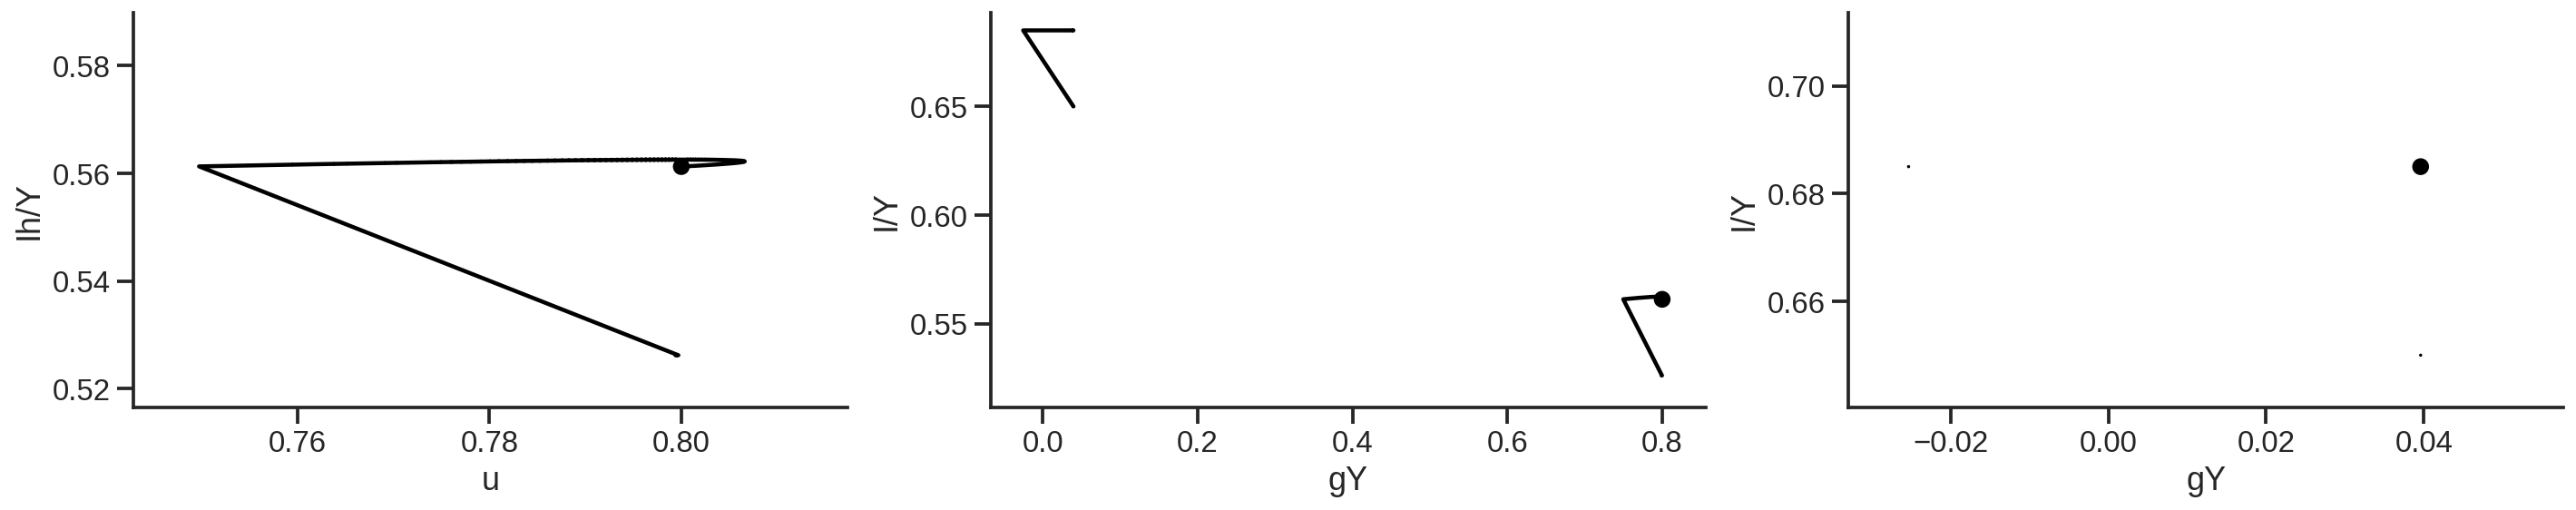

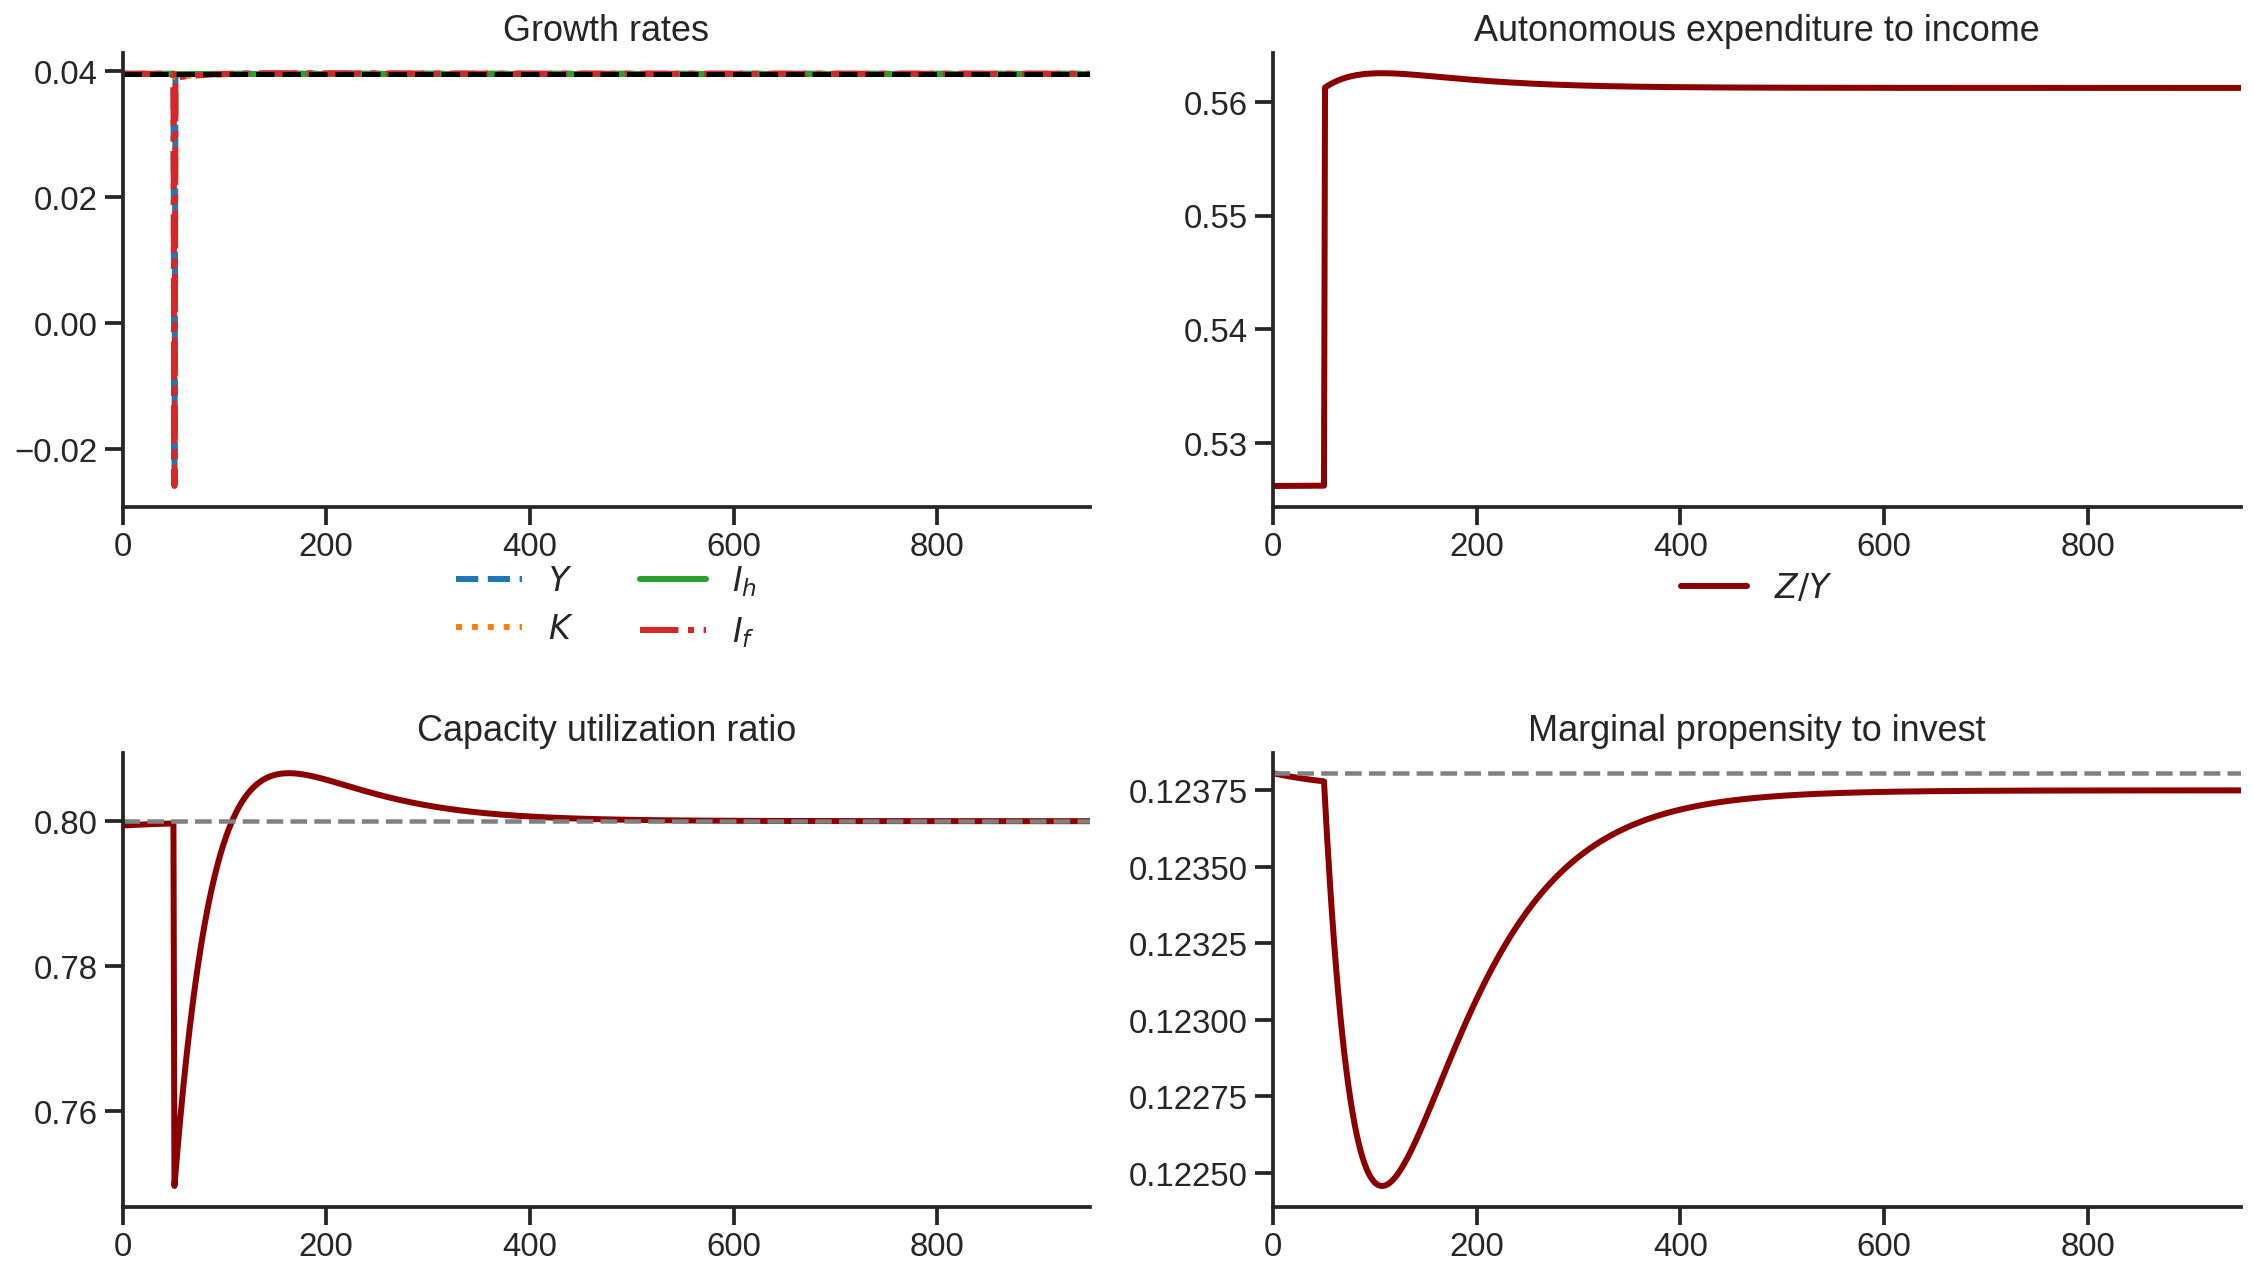

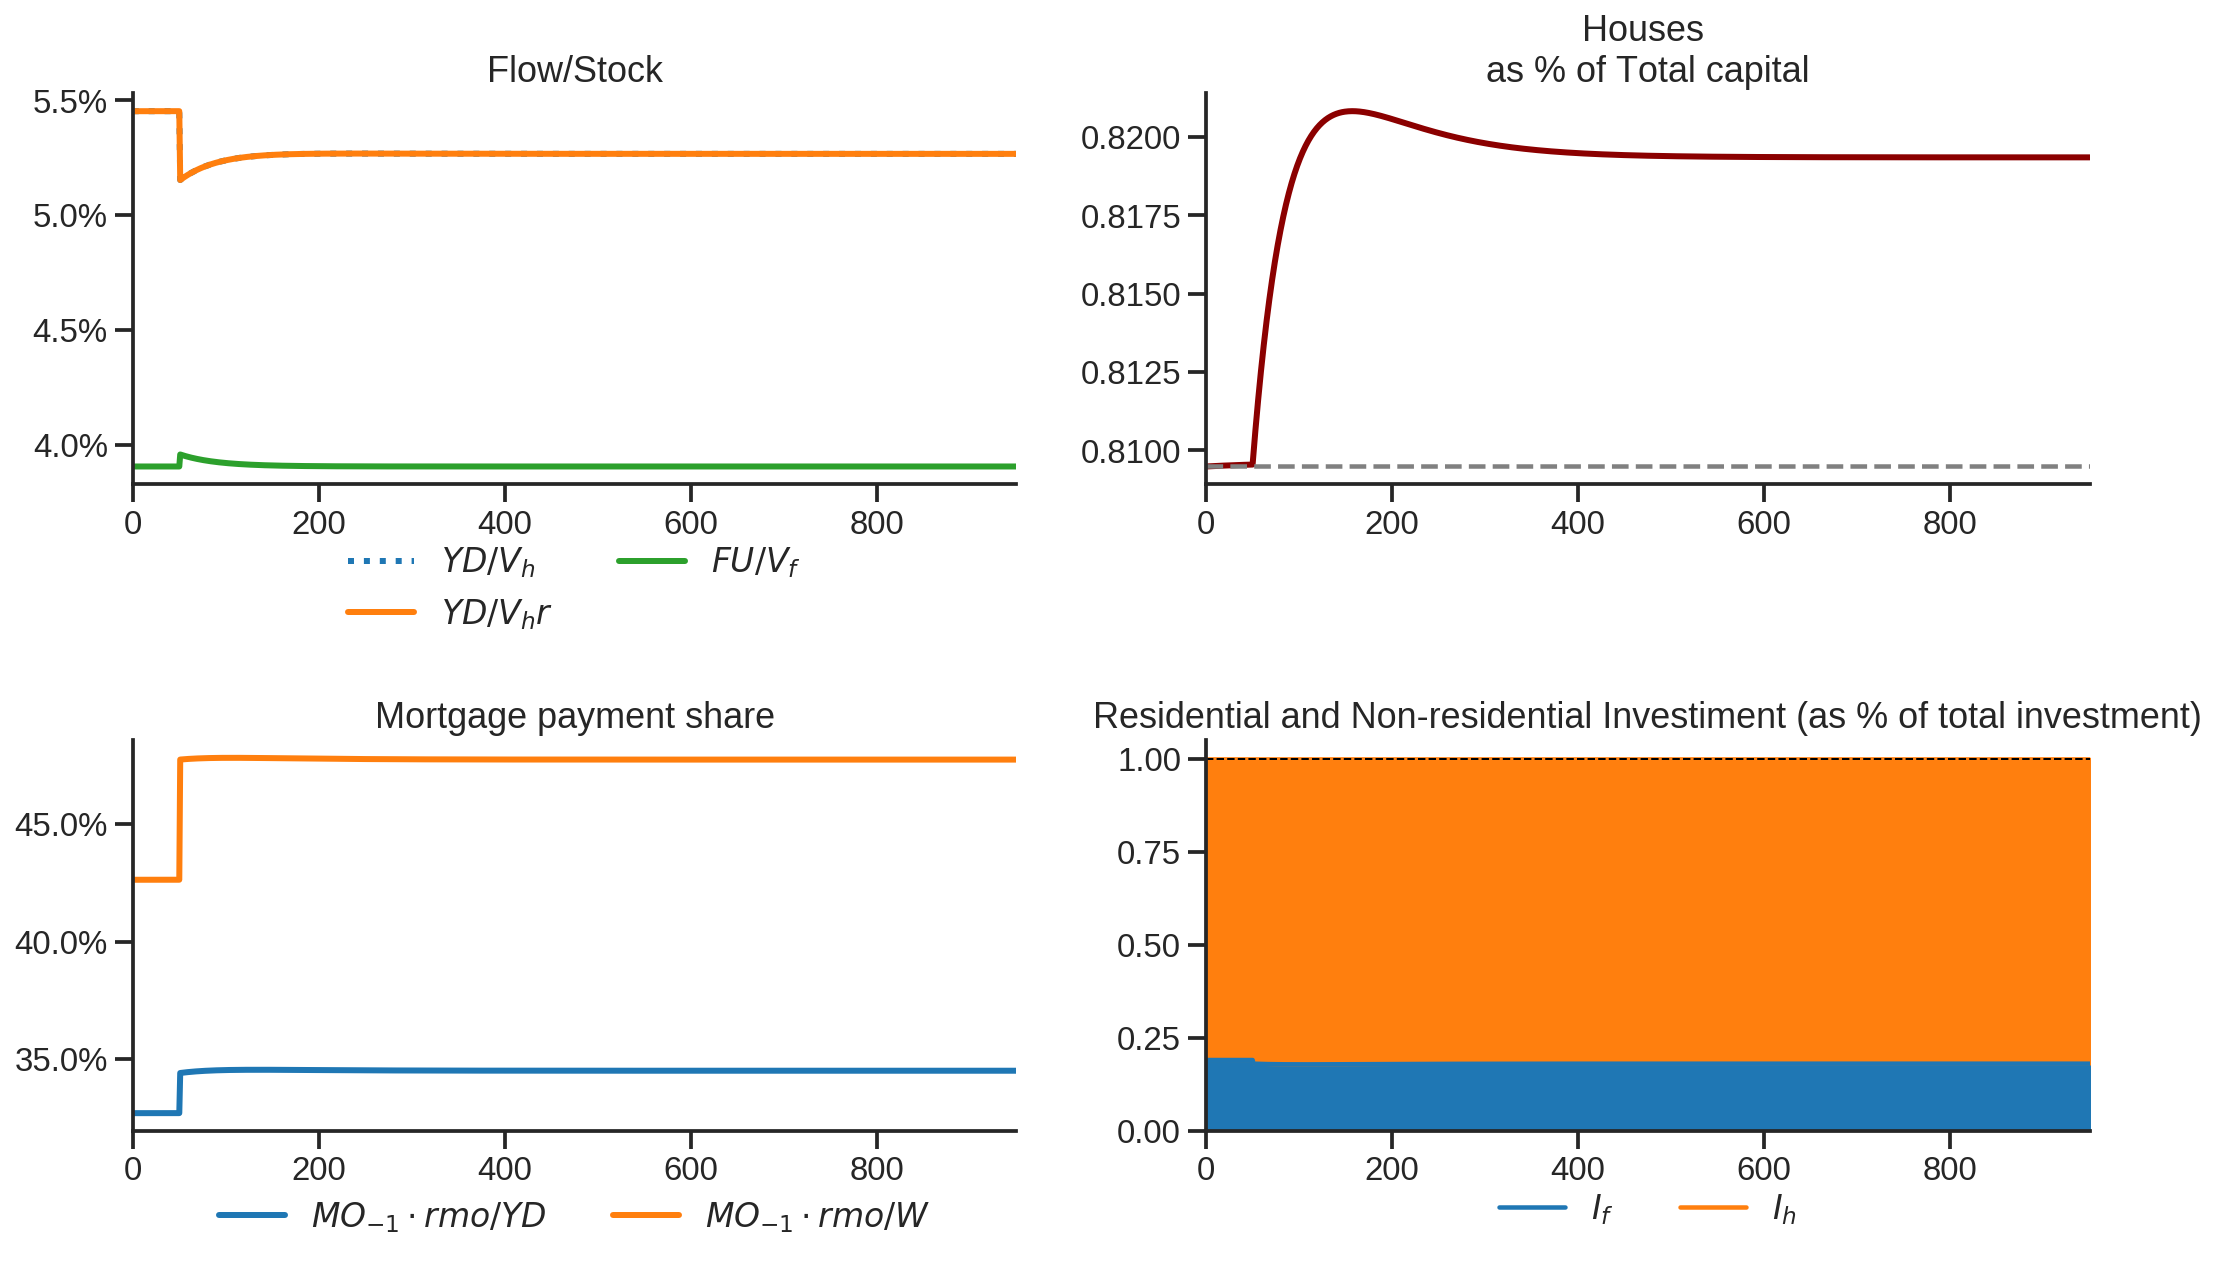

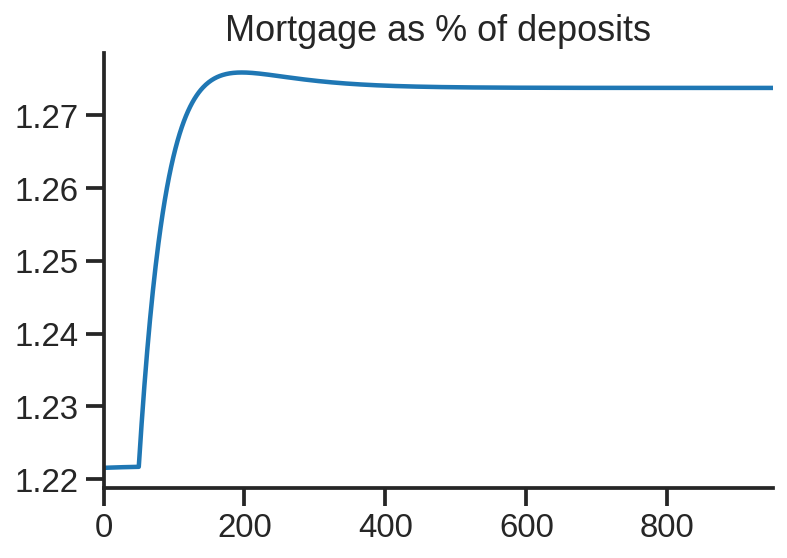

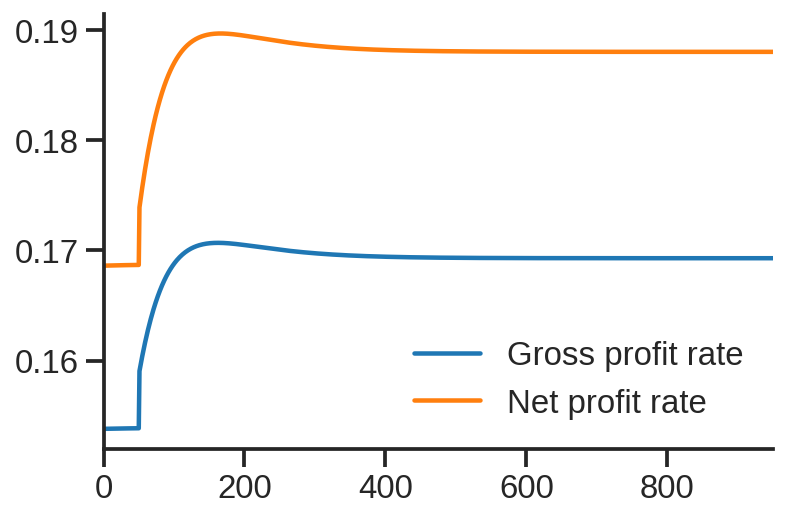

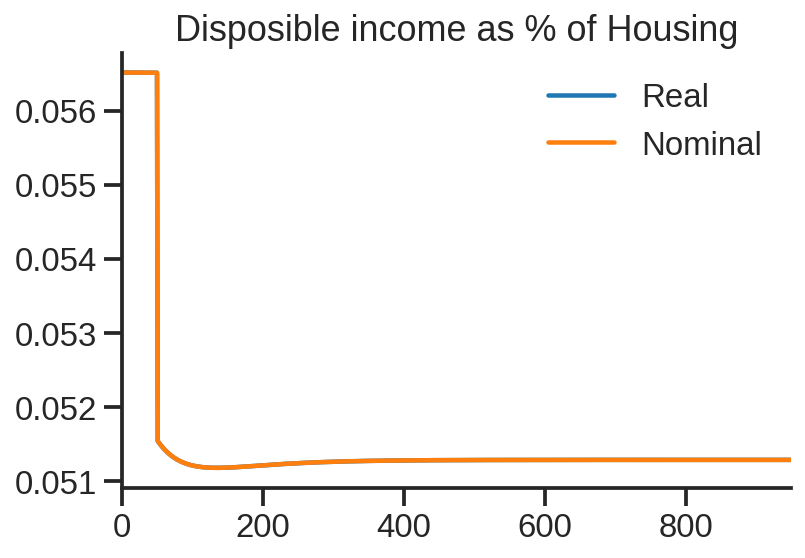

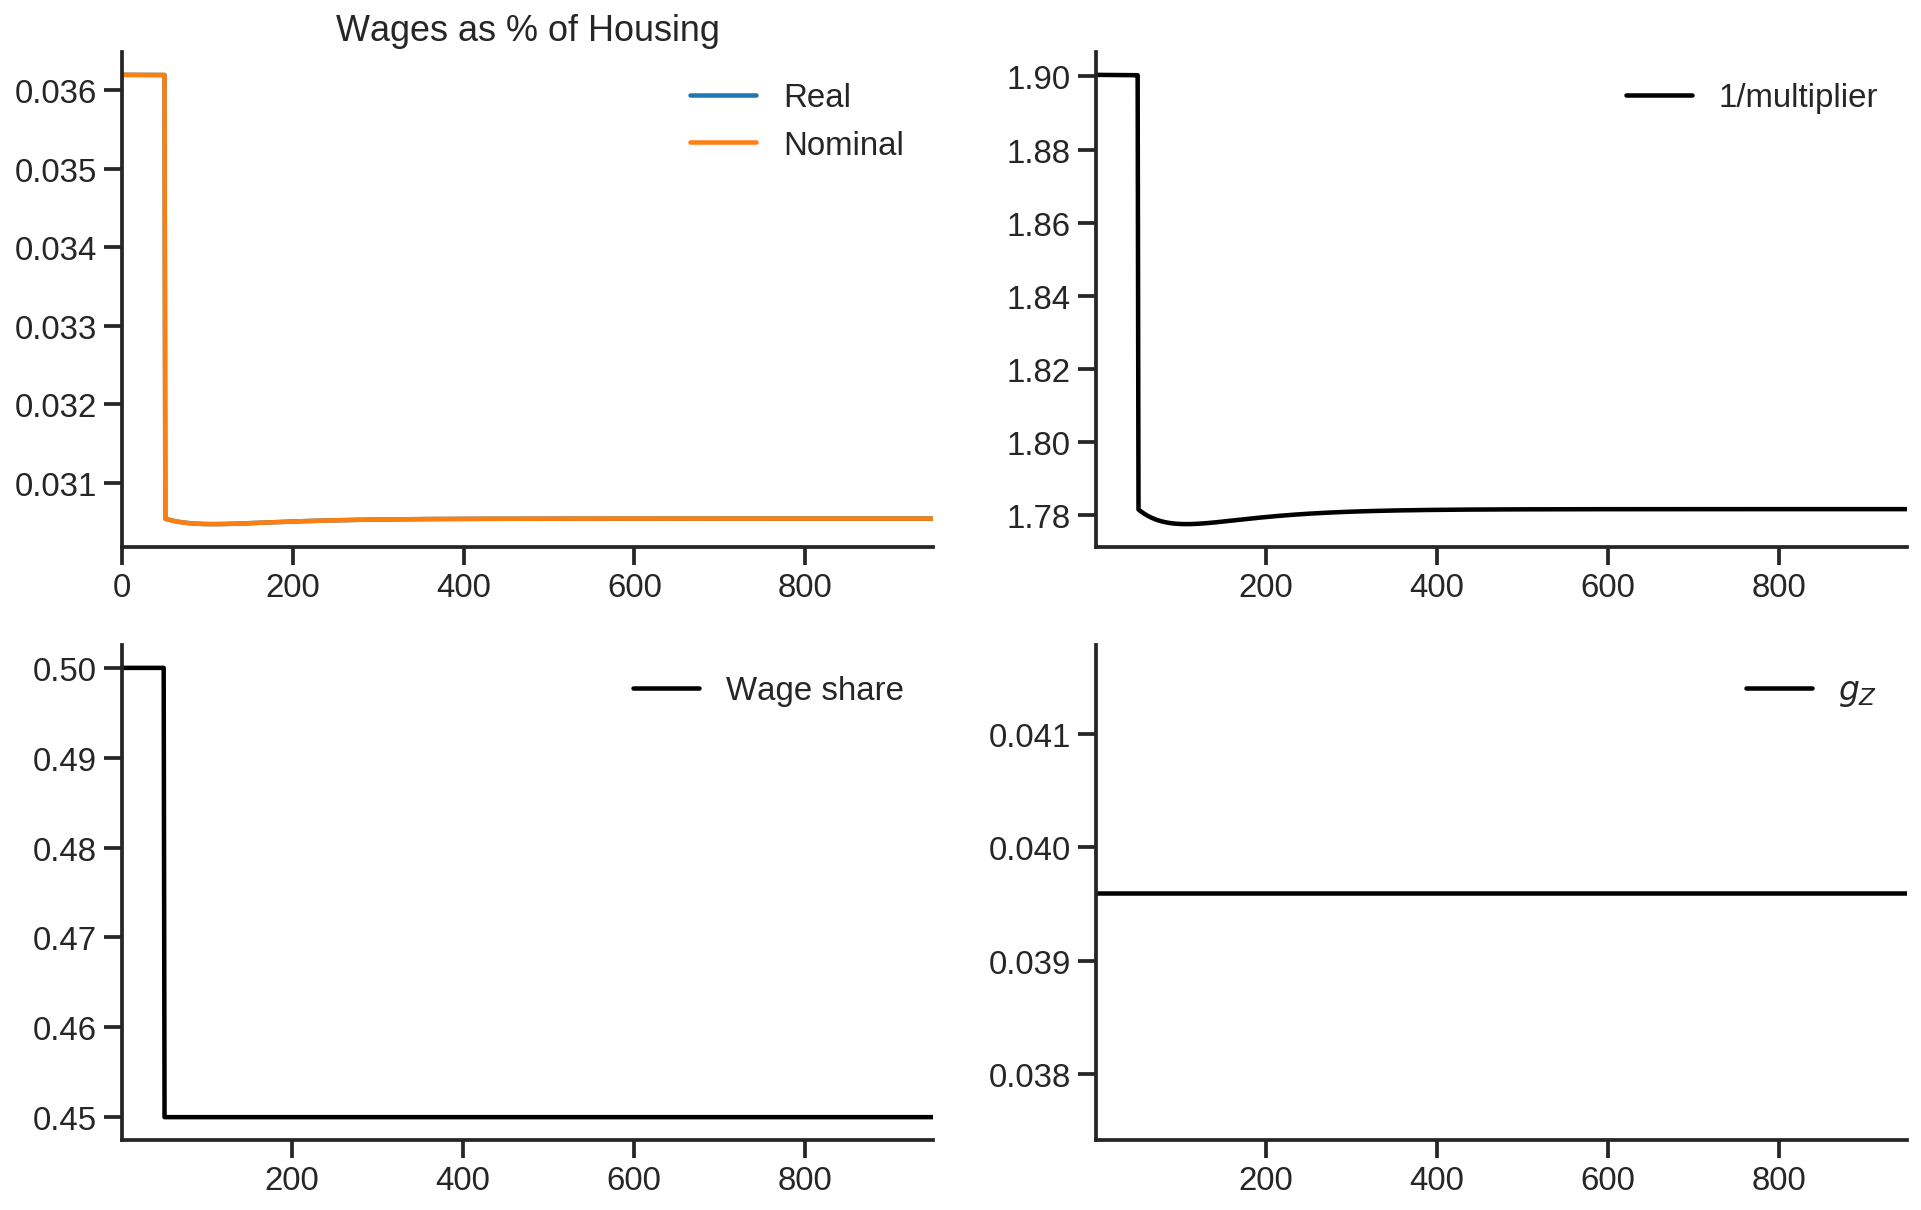

In [35]:
clock_plots(shock = shock, filename = 'Clock_2.png', variable='omega')
plot_shock(shock = shock, filename = 'Shock_2.png')
plot_norms(shock = shock, filename = 'Shock_2Norms.png')
other_plots(shock)

In [36]:
shock2 = shock.round(decimals = 3).tail(1).transpose().loc['alpha':,:]
shock2.columns = ['$\Delta \omega$']
shock2

$\Delta \omega$
alpha         7.000000e-01
gamma_F       4.000000e-01
gamma_u       1.000000e-02
omega         4.500000e-01
rm            2.000000e-02
spread_l      0.000000e+00
spread_mo     0.000000e+00
un            8.000000e-01
v             2.500000e+00
phi_0         4.000000e-02
phi_1         2.000000e-02
phparam       1.000000e+00
infla         0.000000e+00
gZn           3.900000e-02
_K_f__1       3.758722e+30
_M__1         1.338358e+31
_MO__1        1.704715e+31
_Lf__1       -3.663570e+30
_h__1         1.240000e-01
_L__1        -3.663570e+30
_K_HD__1      1.704715e+31
_I_h__1       6.493526e+29
_ph__1        1.000000e+00
TIME          9.510000e+02
Ih/Y          5.610000e-01
I/Y           6.850000e-01
Z/Y           5.610000e-01
gY            4.000000e-02

## Increase in interest rates

In [37]:
base = model()
df = SolveSFC(base, time=1000)
shock = ShockModel(base_model=base, create_function=model(), variable='spread_mo', increase=0.005, time = 1000)
shock.transpose()

0             1             2             3     \
C         4.888186e+18  5.081758e+18  5.282995e+18  5.492202e+18   
FD        4.594266e+18  4.776199e+18  4.965336e+18  5.161964e+18   
Fn        7.657110e+18  7.960332e+18  8.275561e+18  8.603273e+18   
FT        6.983123e+18  7.259654e+18  7.547136e+18  7.846003e+18   
FU        3.062844e+18  3.184133e+18  3.310224e+18  3.441309e+18   
...                ...           ...           ...           ...   
_h__1     1.237512e-01  1.237512e-01  1.237511e-01  1.237511e-01   
_L__1    -3.503387e+19 -3.503387e+19 -3.642122e+19 -3.786352e+19   
_K_HD__1  1.929487e+20  1.929487e+20  2.005895e+20  2.085328e+20   
_I_h__1   7.349721e+18  7.349721e+18  7.640770e+18  7.943344e+18   
_ph__1    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                  4             5             6             7     \
C         5.709693e+18  5.935797e+18  6.170854e+18  6.415220e+18   
FD        5.366378e+18  5.578886e+18  5.799810e+18  6.029482e+18   
Fn        8.943963e+18  9.298143e+18  9.666350e+18  1.004914e+19   
FT        8.156704e+18  8.479709e+18  8.815506e+18  9.164599e+18   
FU        3.577585e+18  3.719257e+18  3.866540e+18  4.019655e+18   
...                ...           ...           ...           ...   
_h__1     1.237511e-01  1.237511e-01  1.237511e-01  1.237511e-01   
_L__1    -3.936292e+19 -4.092170e+19 -4.254222e+19 -4.422690e+19   
_K_HD__1  2.167907e+20  2.253757e+20  2.343005e+20  2.435788e+20   
_I_h__1   8.257900e+18  8.584913e+18  8.924876e+18  9.278301e+18   
_ph__1    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                  8             9     ...          1041          1042  \
C         6.669262e+18  6.933365e+18  ...  1.604262e+36  1.667630e+36   
FD        6.268250e+18  6.516473e+18  ...  1.508770e+36  1.568366e+36   
Fn        1.044708e+19  1.086079e+19  ...  2.514617e+36  2.613943e+36   
FT        9.527517e+18  9.904807e+18  ...  2.291803e+36  2.382328e+36   
FU        4.178833e+18  4.344315e+18  ...  1.005847e+36  1.045577e+36   
...                ...           ...  ...           ...           ...   
_h__1     1.237511e-01  1.237510e-01  ...  1.234375e-01  1.234375e-01   
_L__1    -4.597830e+19 -4.779905e+19  ... -1.114070e+37 -1.158075e+37   
_K_HD__1  2.532246e+20  2.632522e+20  ...  6.110271e+37  6.351627e+37   
_I_h__1   9.645722e+18  1.002769e+19  ...  2.321844e+36  2.413557e+36   
_ph__1    1.000000e+00  1.000000e+00  ...  1.000000e+00  1.000000e+00   

                  1043          1044          1045          1046  \
C         1.733501e+36  1.801975e+36  1.873152e+36  1.947142e+36   
FD        1.630316e+36  1.694715e+36  1.761655e+36  1.831241e+36   
Fn        2.717194e+36  2.824525e+36  2.936092e+36  3.052068e+36   
FT        2.476430e+36  2.574251e+36  2.675932e+36  2.781631e+36   
FU        1.086878e+36  1.129810e+36  1.174437e+36  1.220827e+36   
...                ...           ...           ...           ...   
_h__1     1.234375e-01  1.234375e-01  1.234375e-01  1.234375e-01   
_L__1    -1.203819e+37 -1.251370e+37 -1.300799e+37 -1.352181e+37   
_K_HD__1  6.602516e+37  6.863316e+37  7.134417e+37  7.416226e+37   
_I_h__1   2.508893e+36  2.607994e+36  2.711010e+36  2.818095e+36   
_ph__1    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                  1047          1048          1049          1050  
C         2.024057e+36  2.104004e+36  2.187112e+36  2.273505e+36  
FD        1.903577e+36  1.978766e+36  2.056927e+36  2.138177e+36  
Fn        3.172628e+36  3.297943e+36  3.428212e+36  3.563628e+36  
FT        2.891509e+36  3.005720e+36  3.124446e+36  3.247864e+36  
FU        1.269051e+36  1.319177e+36  1.371285e+36  1.425451e+36  
...                ...           ...           ...           ...  
_h__1     1.234375e-01  1.234375e-01  1.234375e-01  1.234375e-01  
_L__1    -1.405592e+37 -1.461113e+37 -1.518827e+37 -1.578821e+37  
_K_HD__1  7.709167e+37  8.013679e+37  8.330220e+37  8.659263e+37  
_I_h__1   2.929409e+

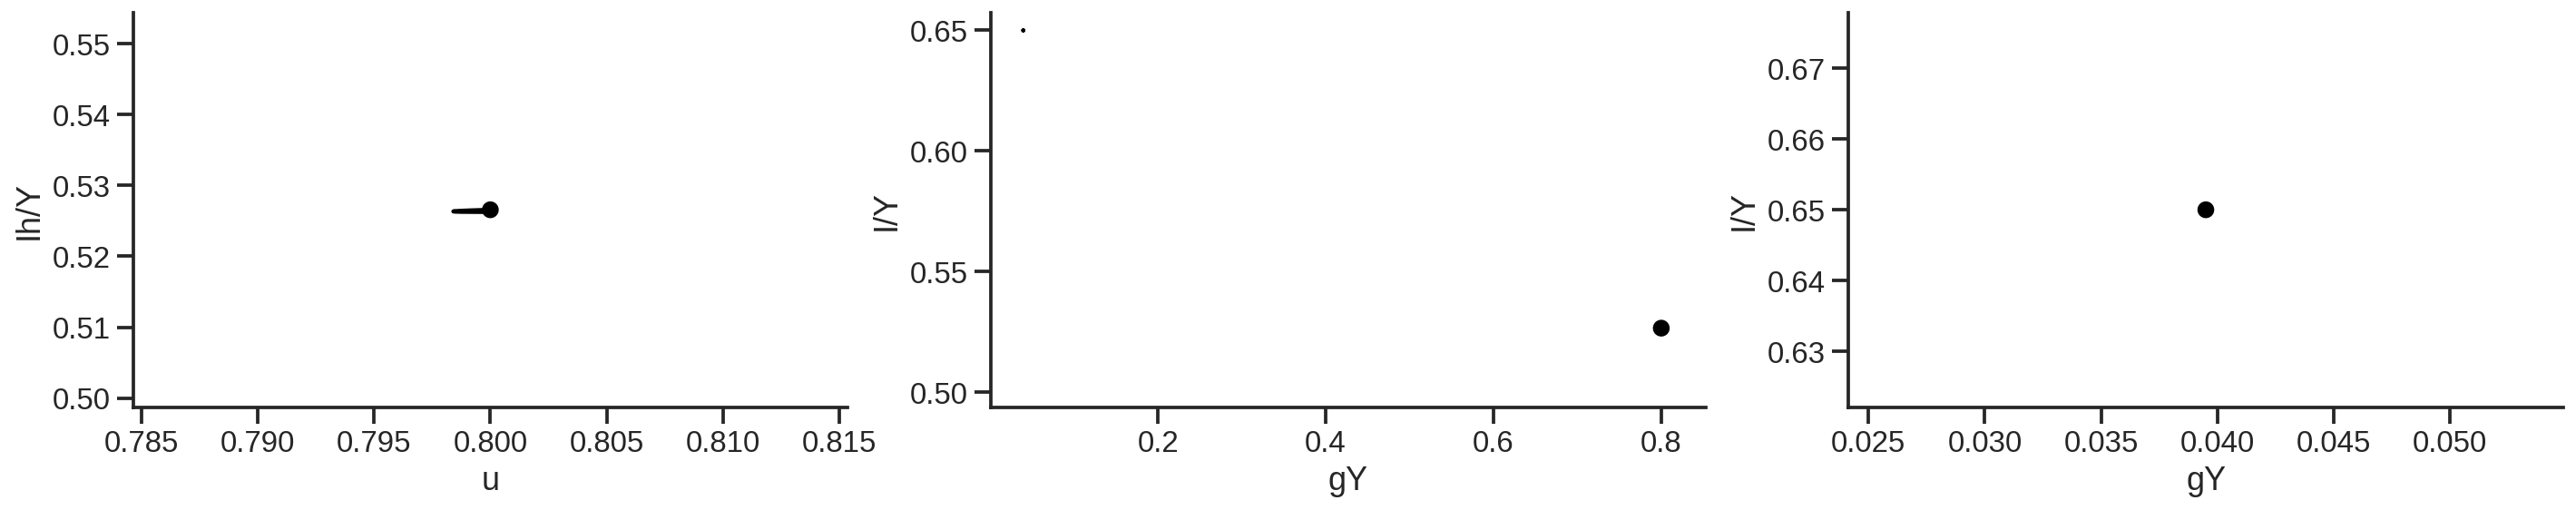

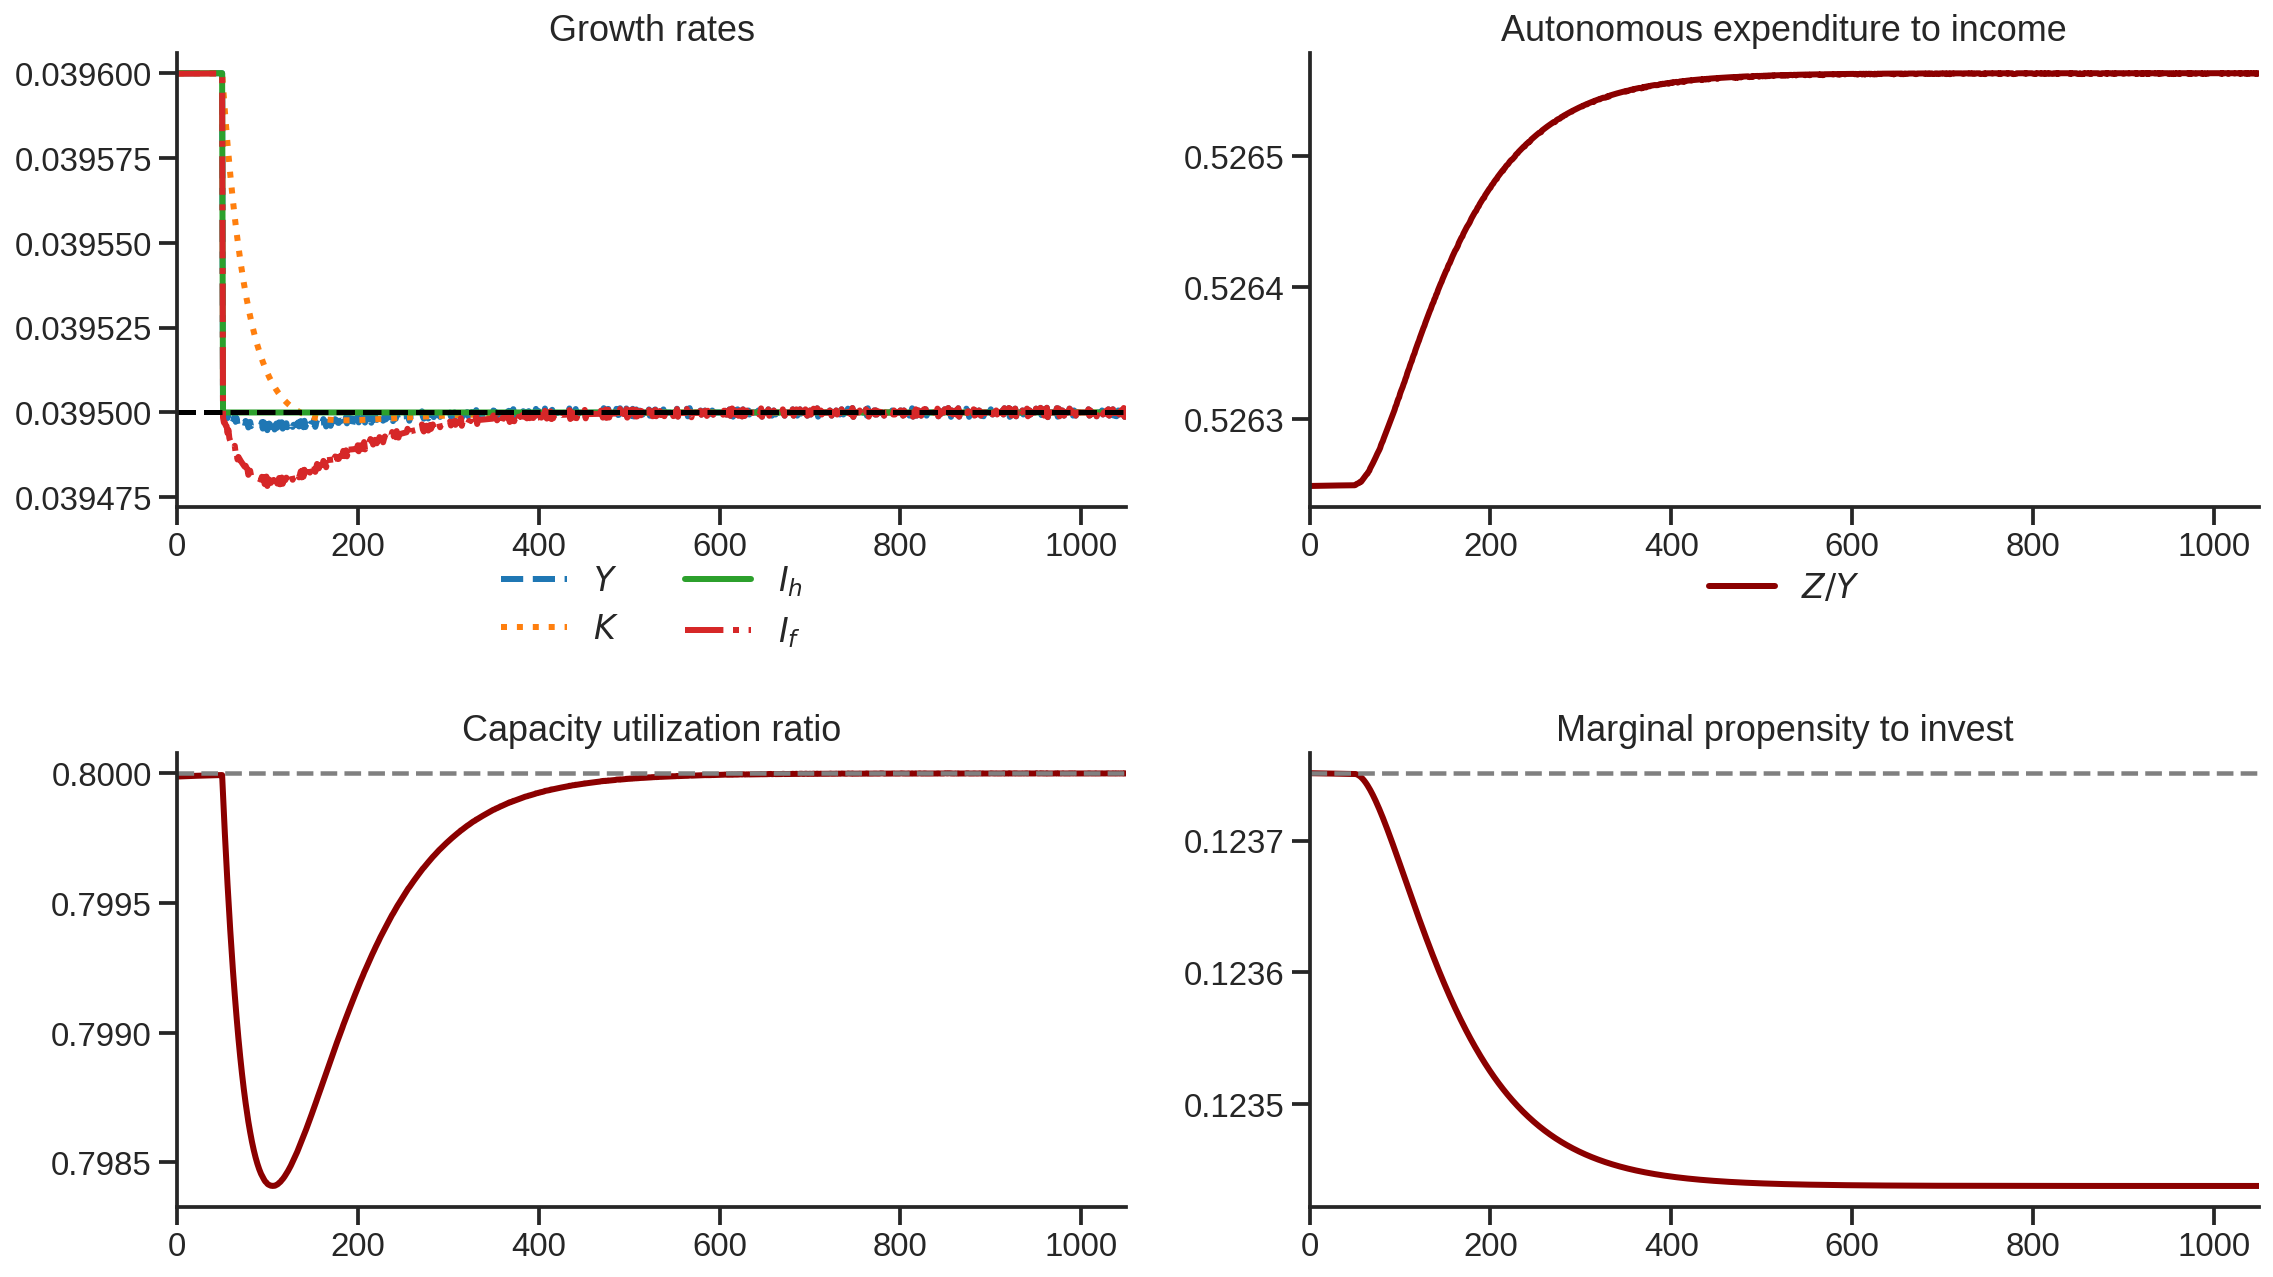

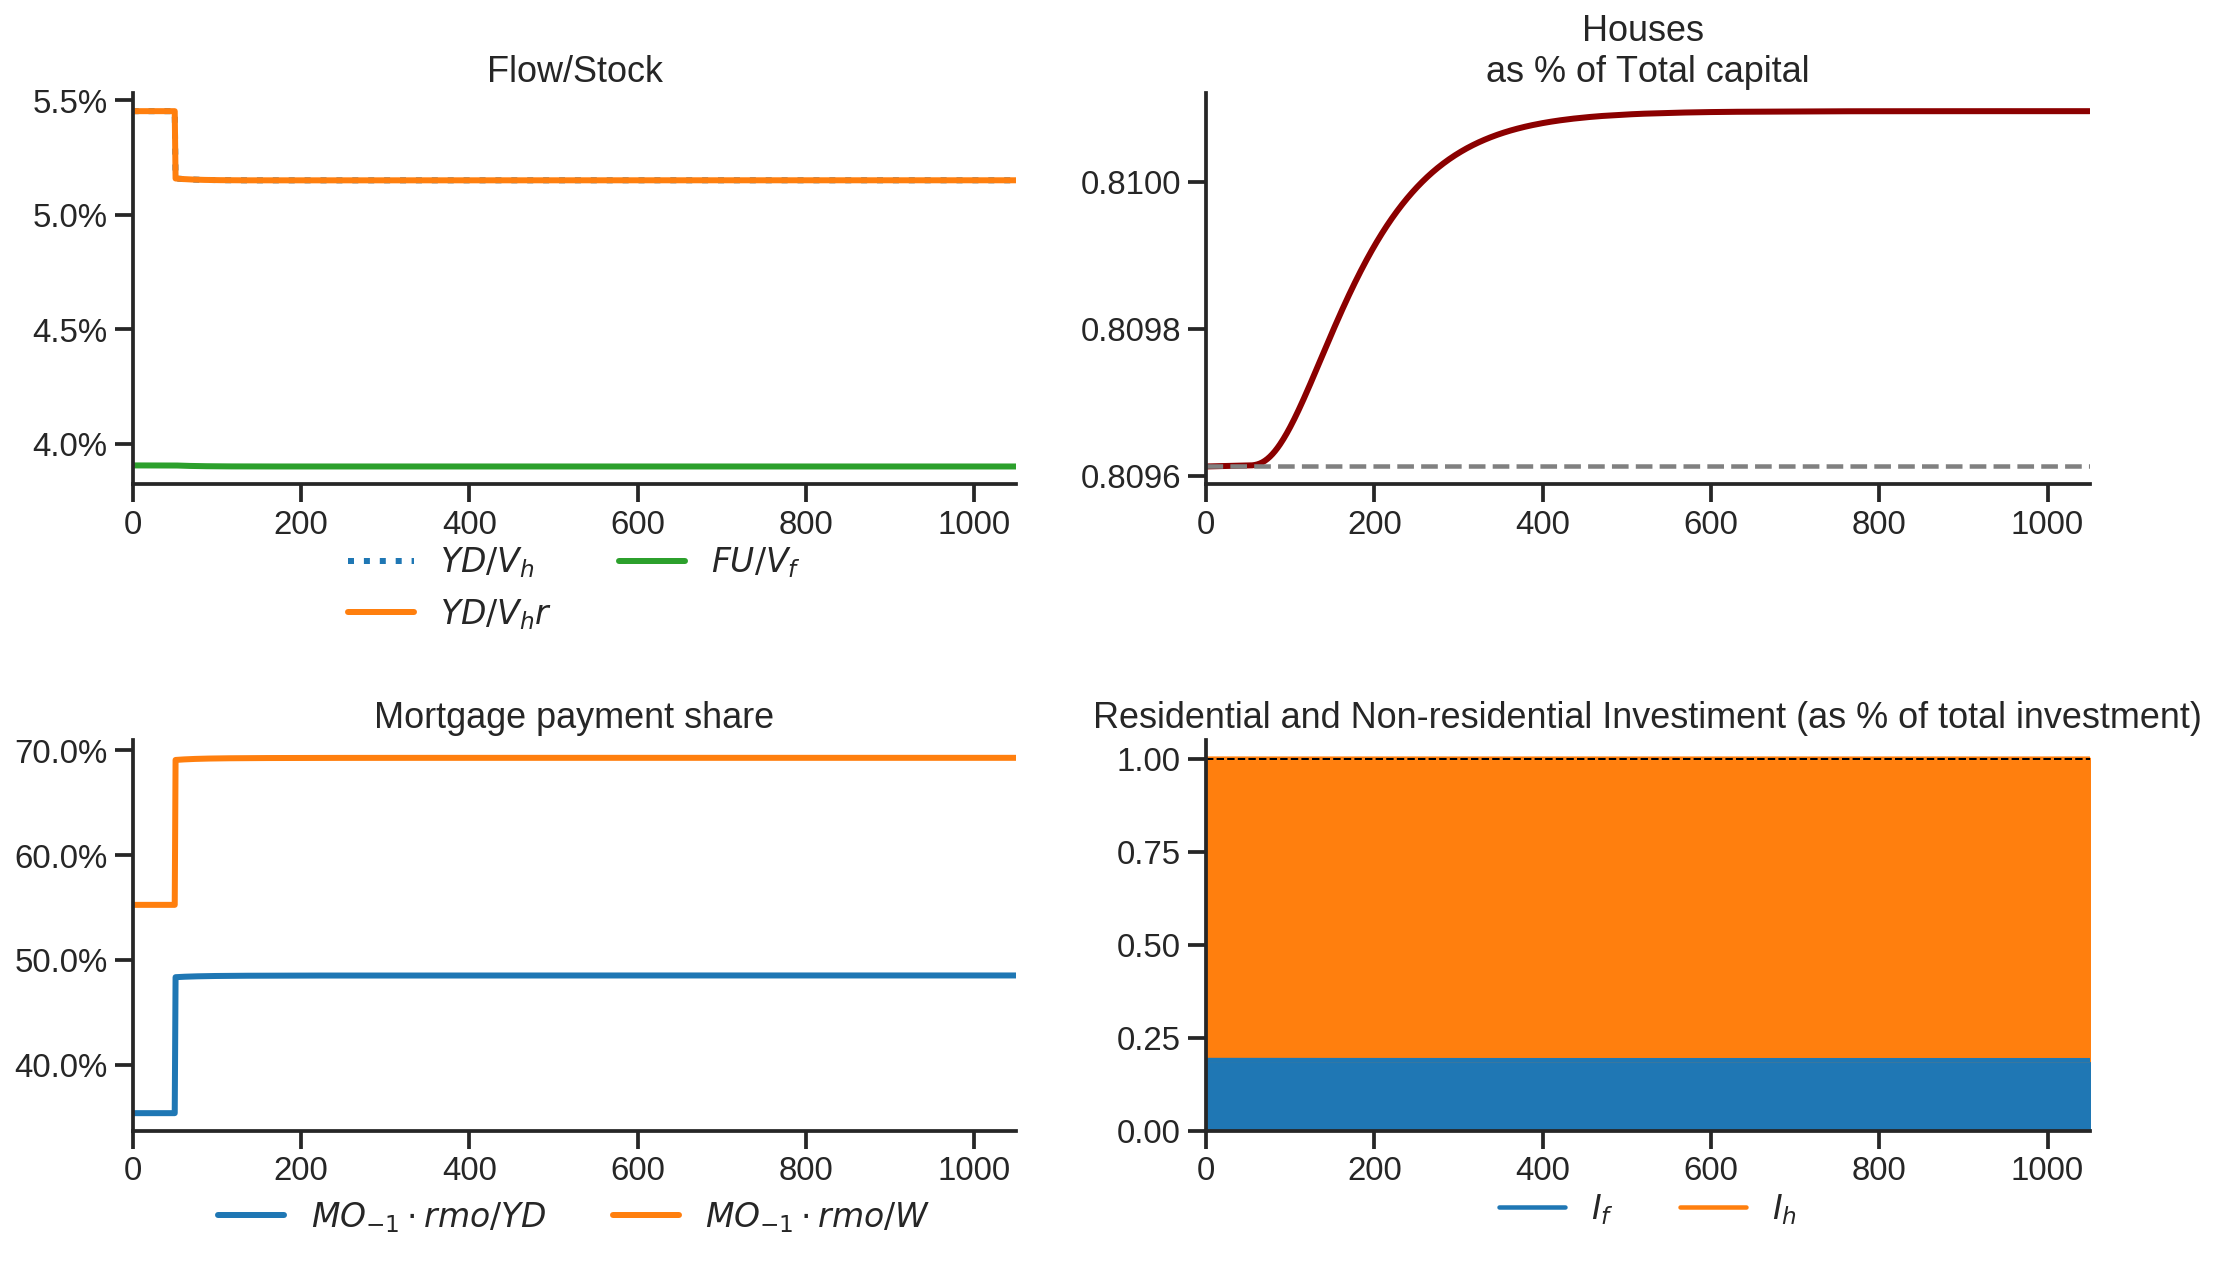

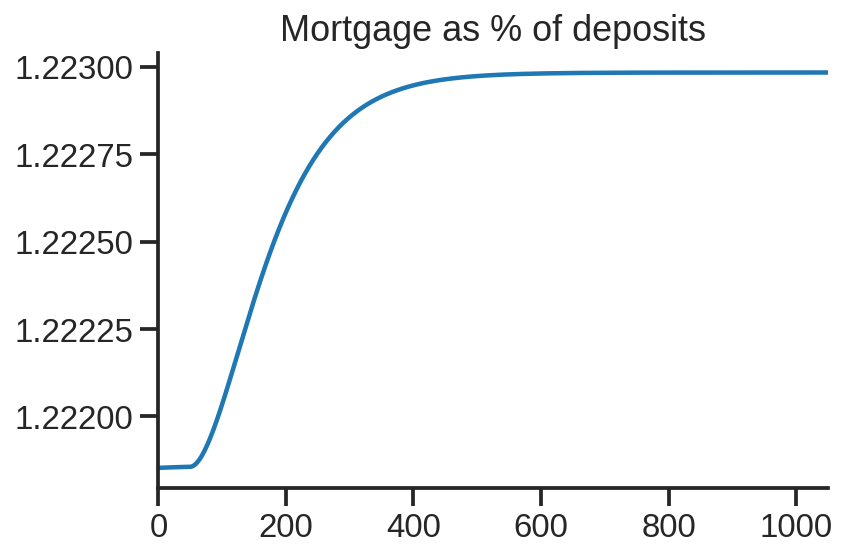

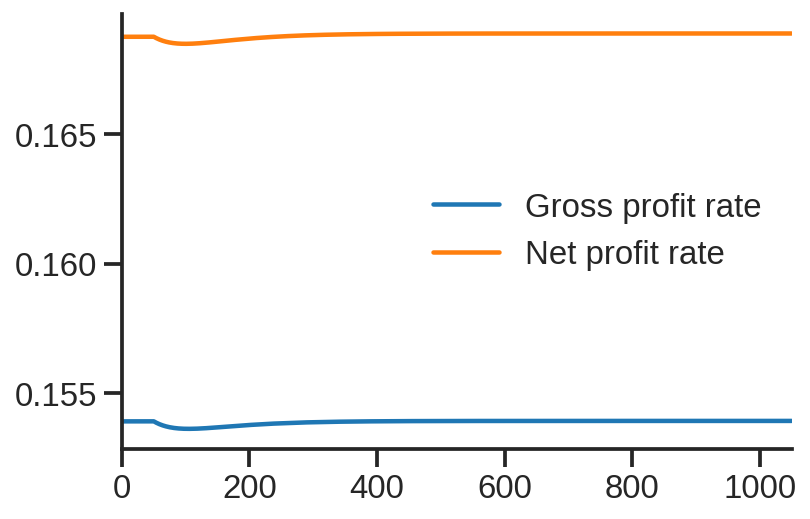

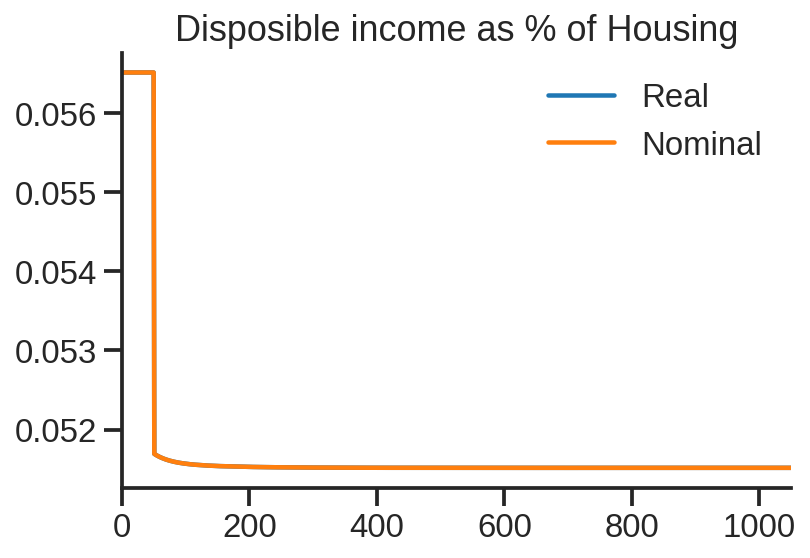

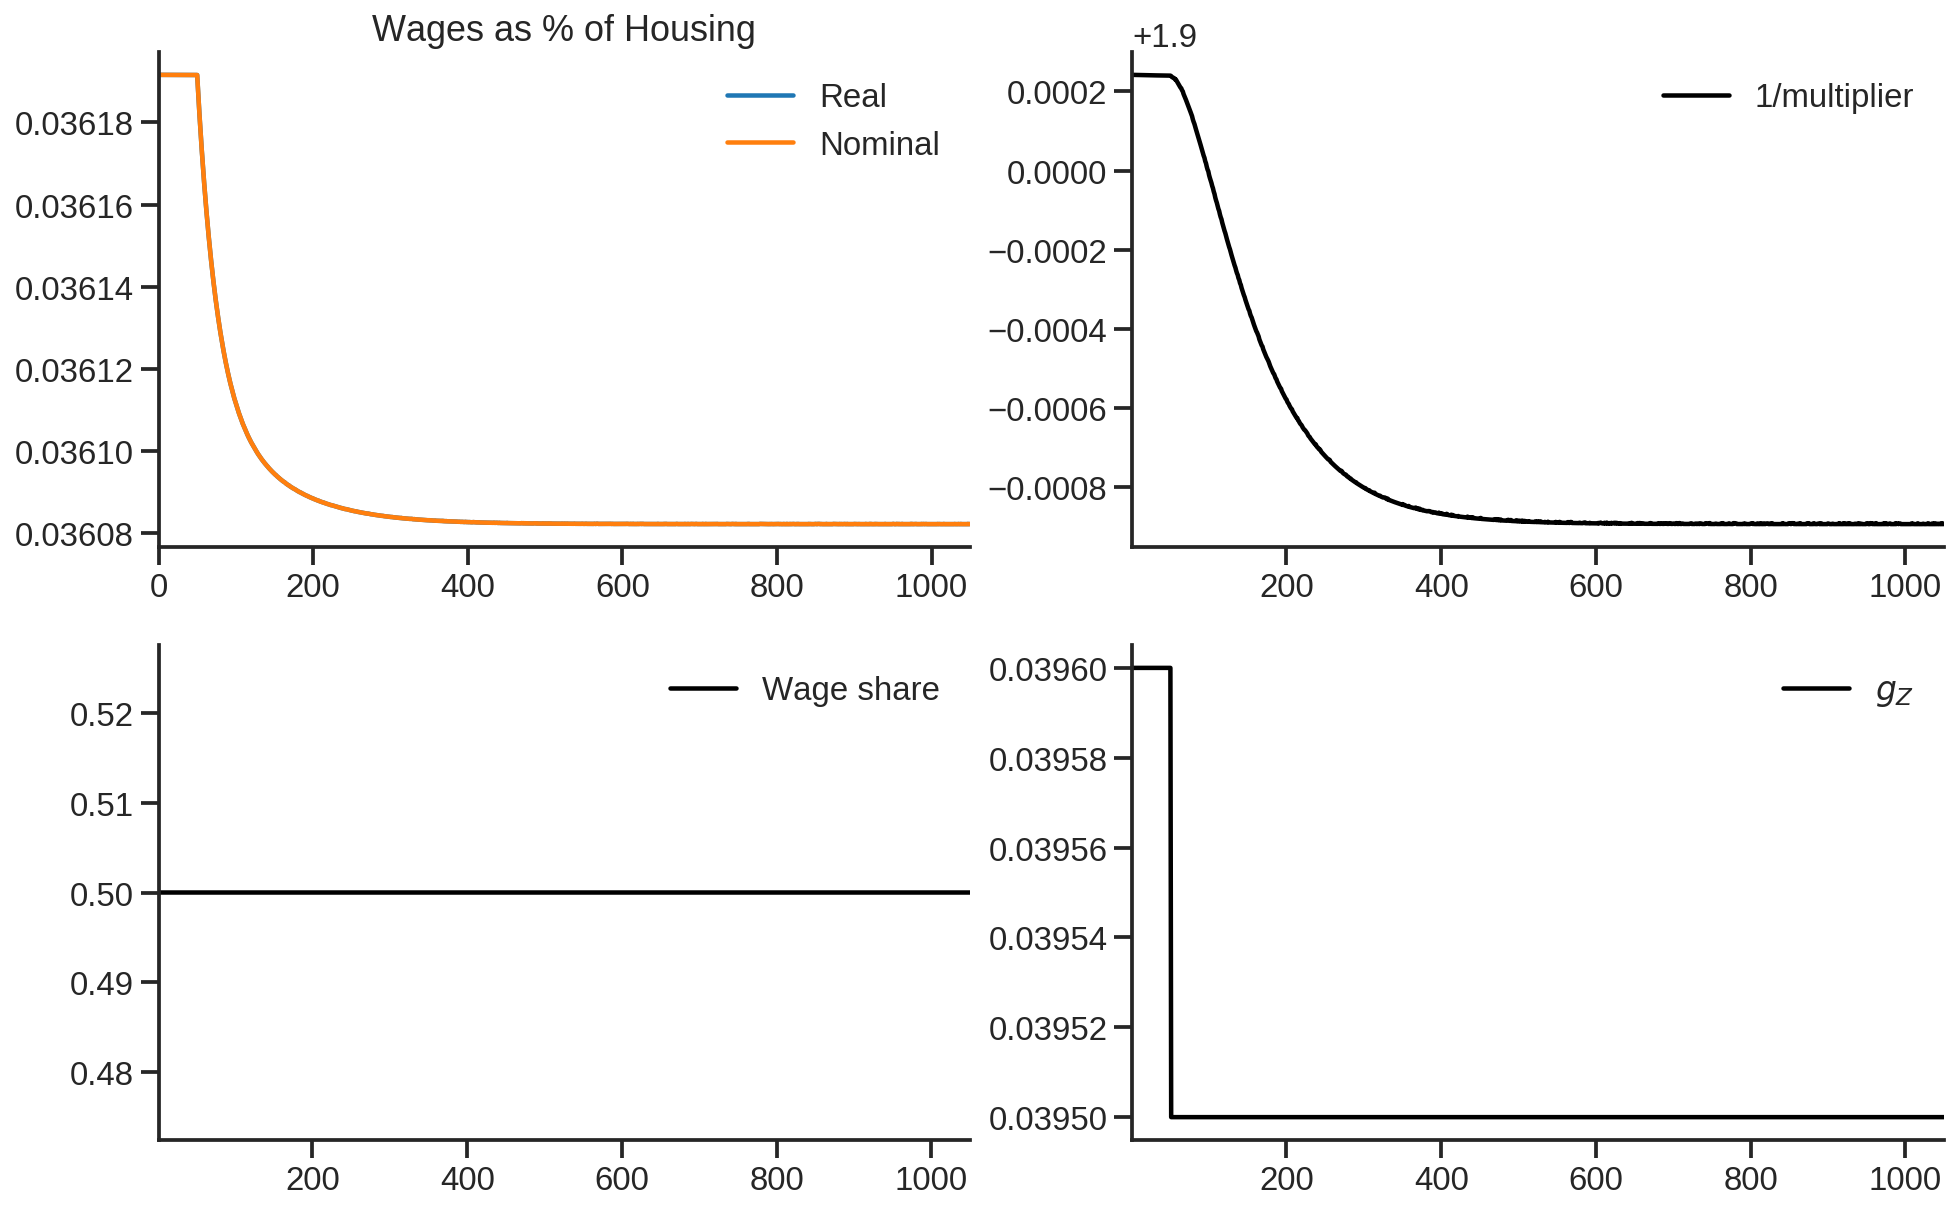

In [38]:
clock_plots(shock = shock, filename = 'Clock_3.png', variable='rmo')
plot_shock(shock = shock, filename = 'Shock_3.png')
plot_norms(shock = shock, filename = 'Shock_3Norms.png')
other_plots(shock)

In [39]:
shock3 = shock.round(decimals = 3).tail(1).transpose().loc['alpha':,:]
shock3.columns = ['$\Delta rm$']
shock3

$\Delta rm$
alpha      7.000000e-01
gamma_F    4.000000e-01
gamma_u    1.000000e-02
omega      5.000000e-01
rm         2.000000e-02
spread_l   0.000000e+00
spread_mo  5.000000e-03
un         8.000000e-01
v          2.500000e+00
phi_0      4.000000e-02
phi_1      2.000000e-02
phparam    1.000000e+00
infla      0.000000e+00
gZn        3.900000e-02
_K_f__1    2.029914e+37
_M__1      7.080443e+37
_MO__1     8.659263e+37
_Lf__1    -1.578821e+37
_h__1      1.230000e-01
_L__1     -1.578821e+37
_K_HD__1   8.659263e+37
_I_h__1    3.290437e+36
_ph__1     1.000000e+00
TIME       1.051000e+03
Ih/Y       5.270000e-01
I/Y        6.500000e-01
Z/Y        5.270000e-01
gY         4.000000e-02

## Increase in inflation

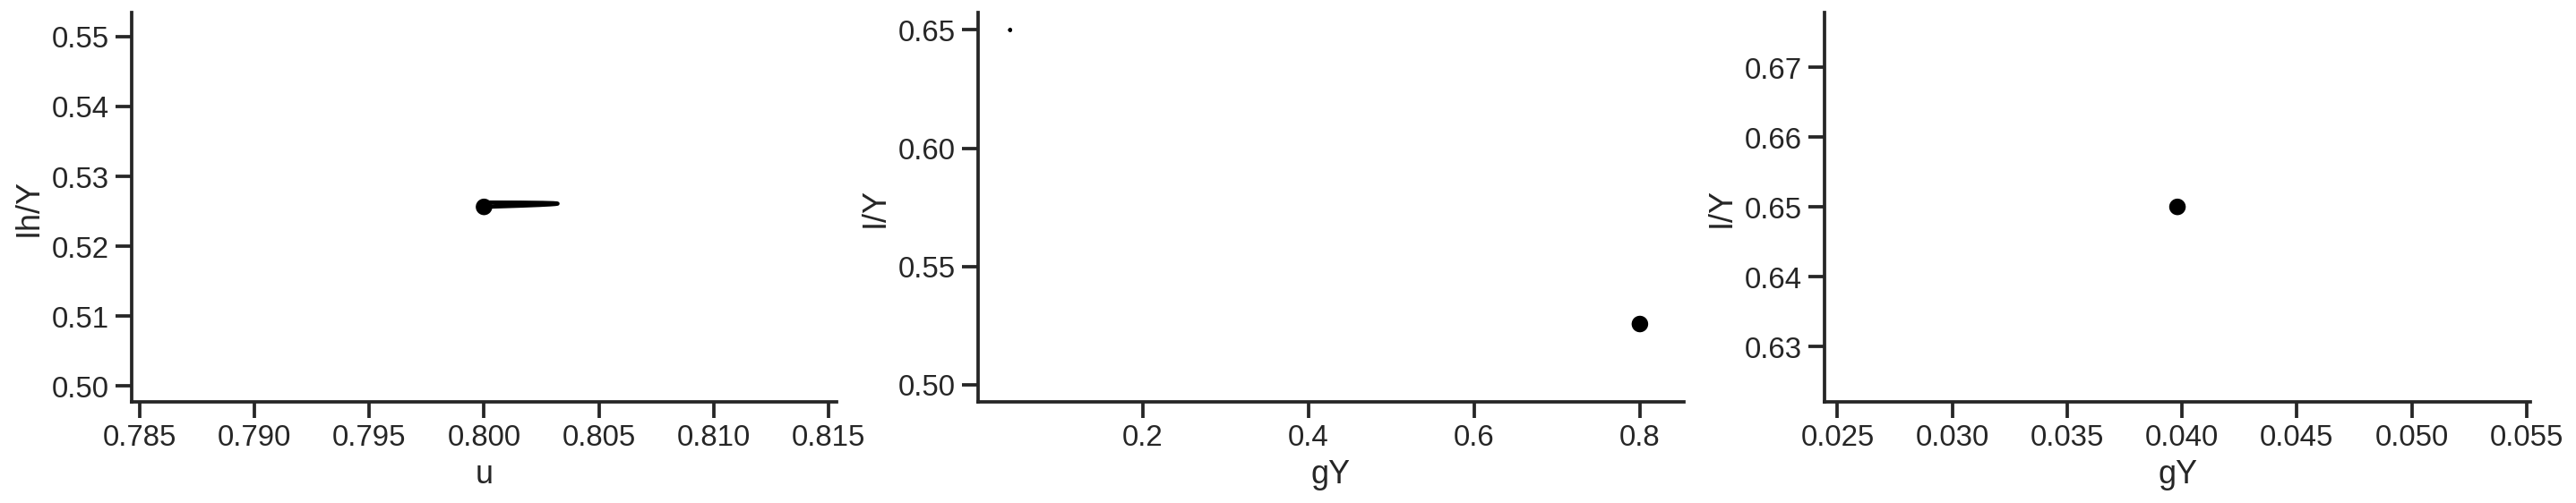

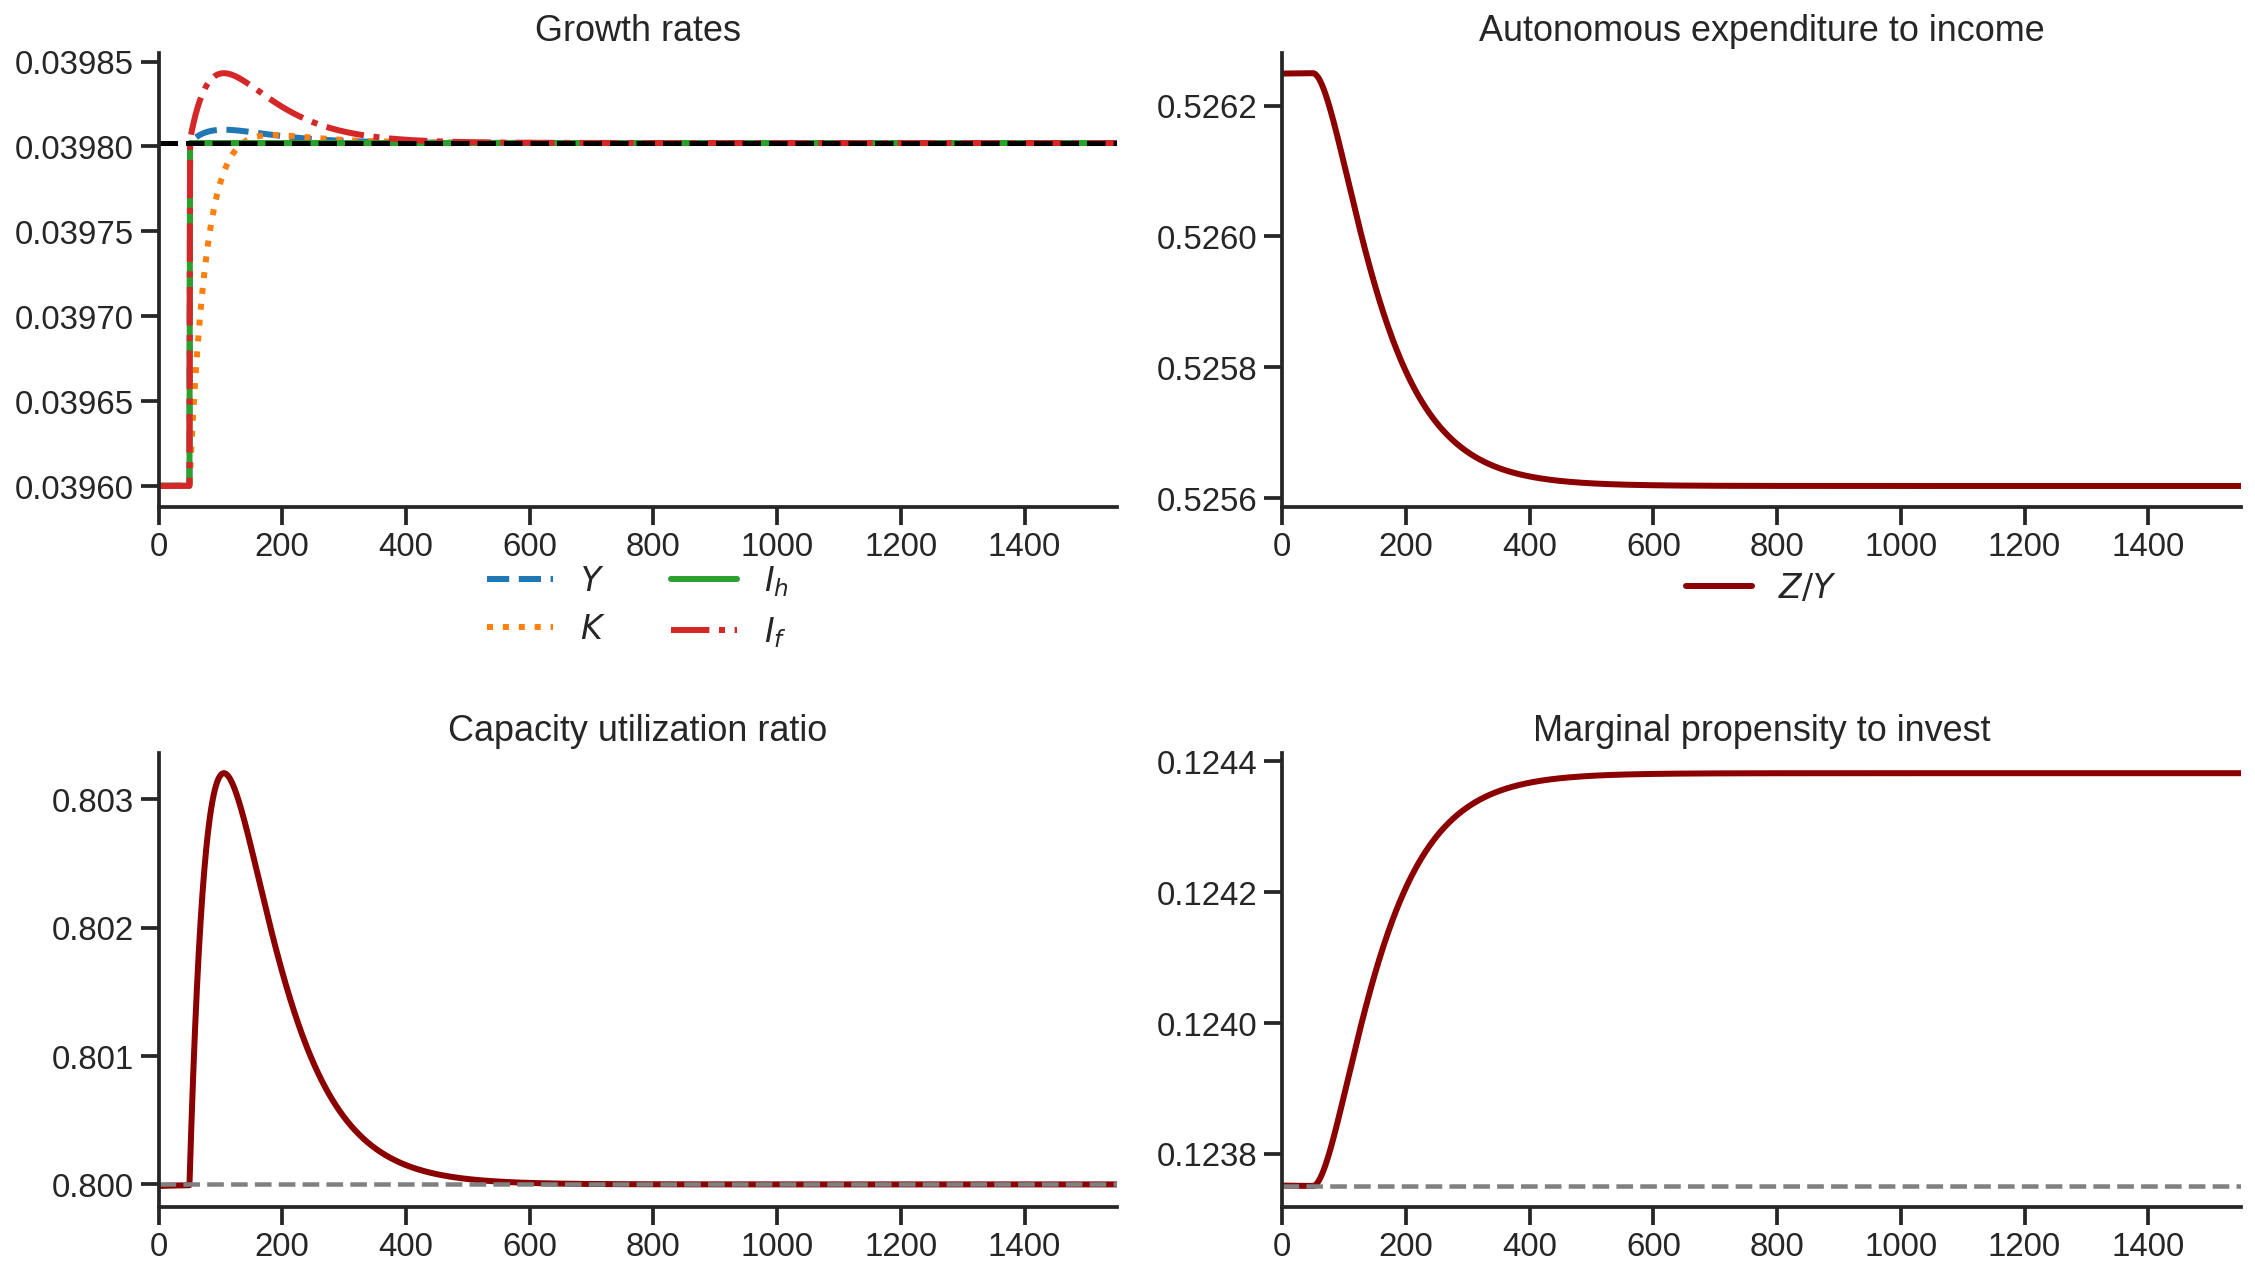

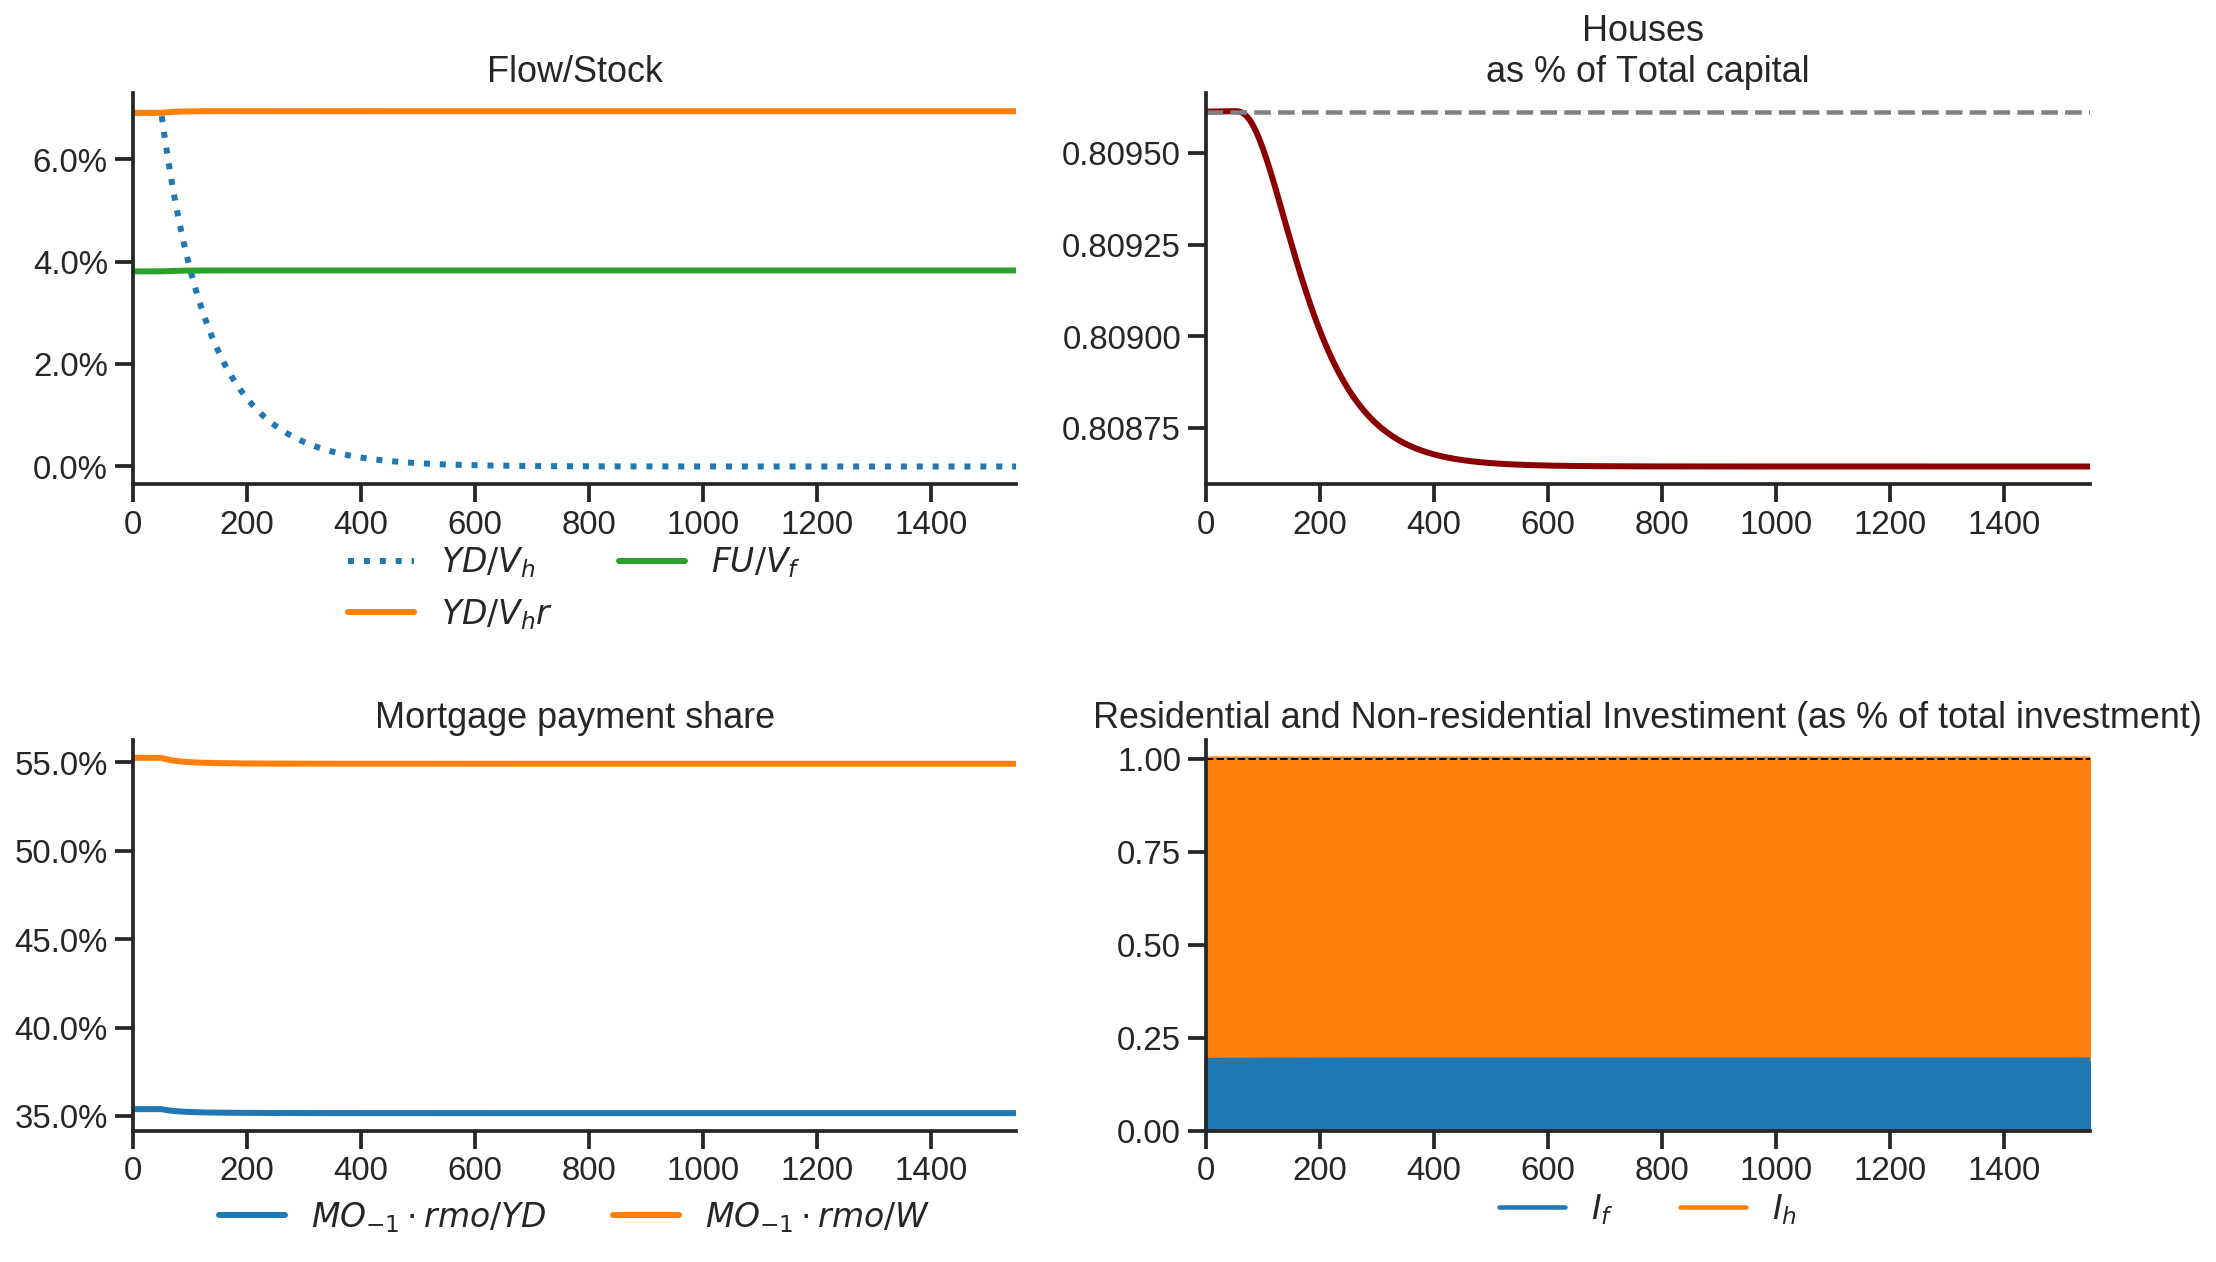

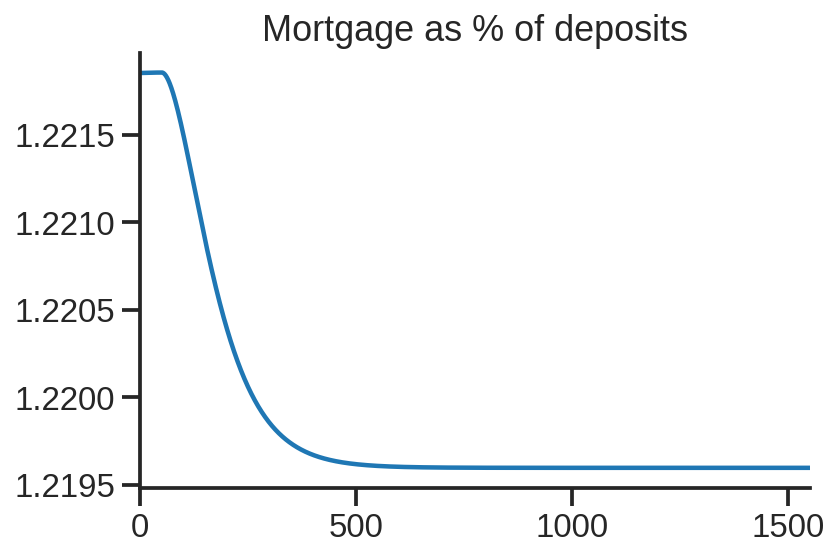

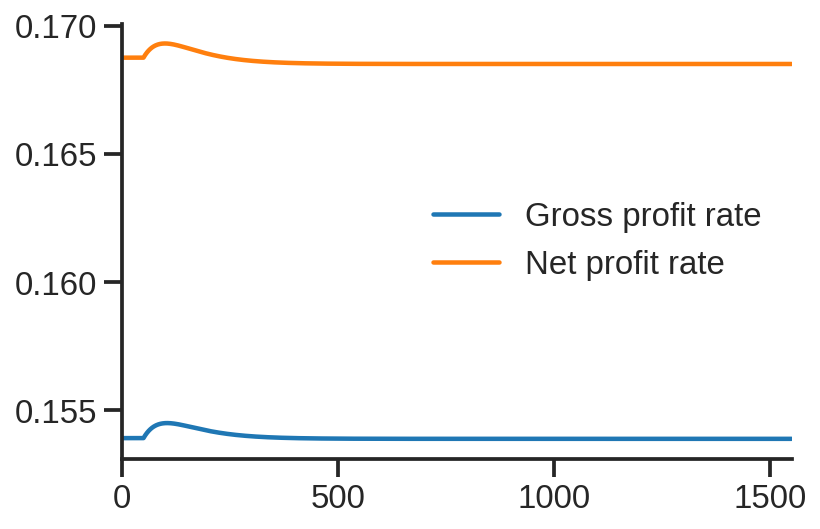

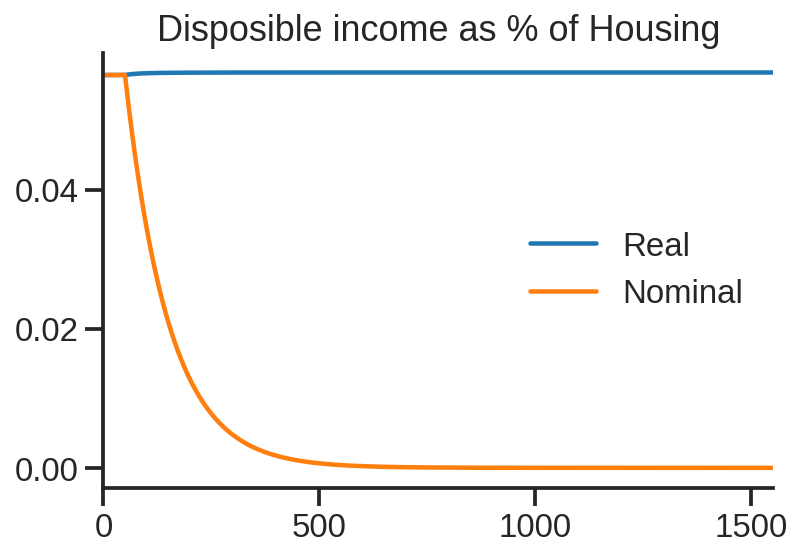

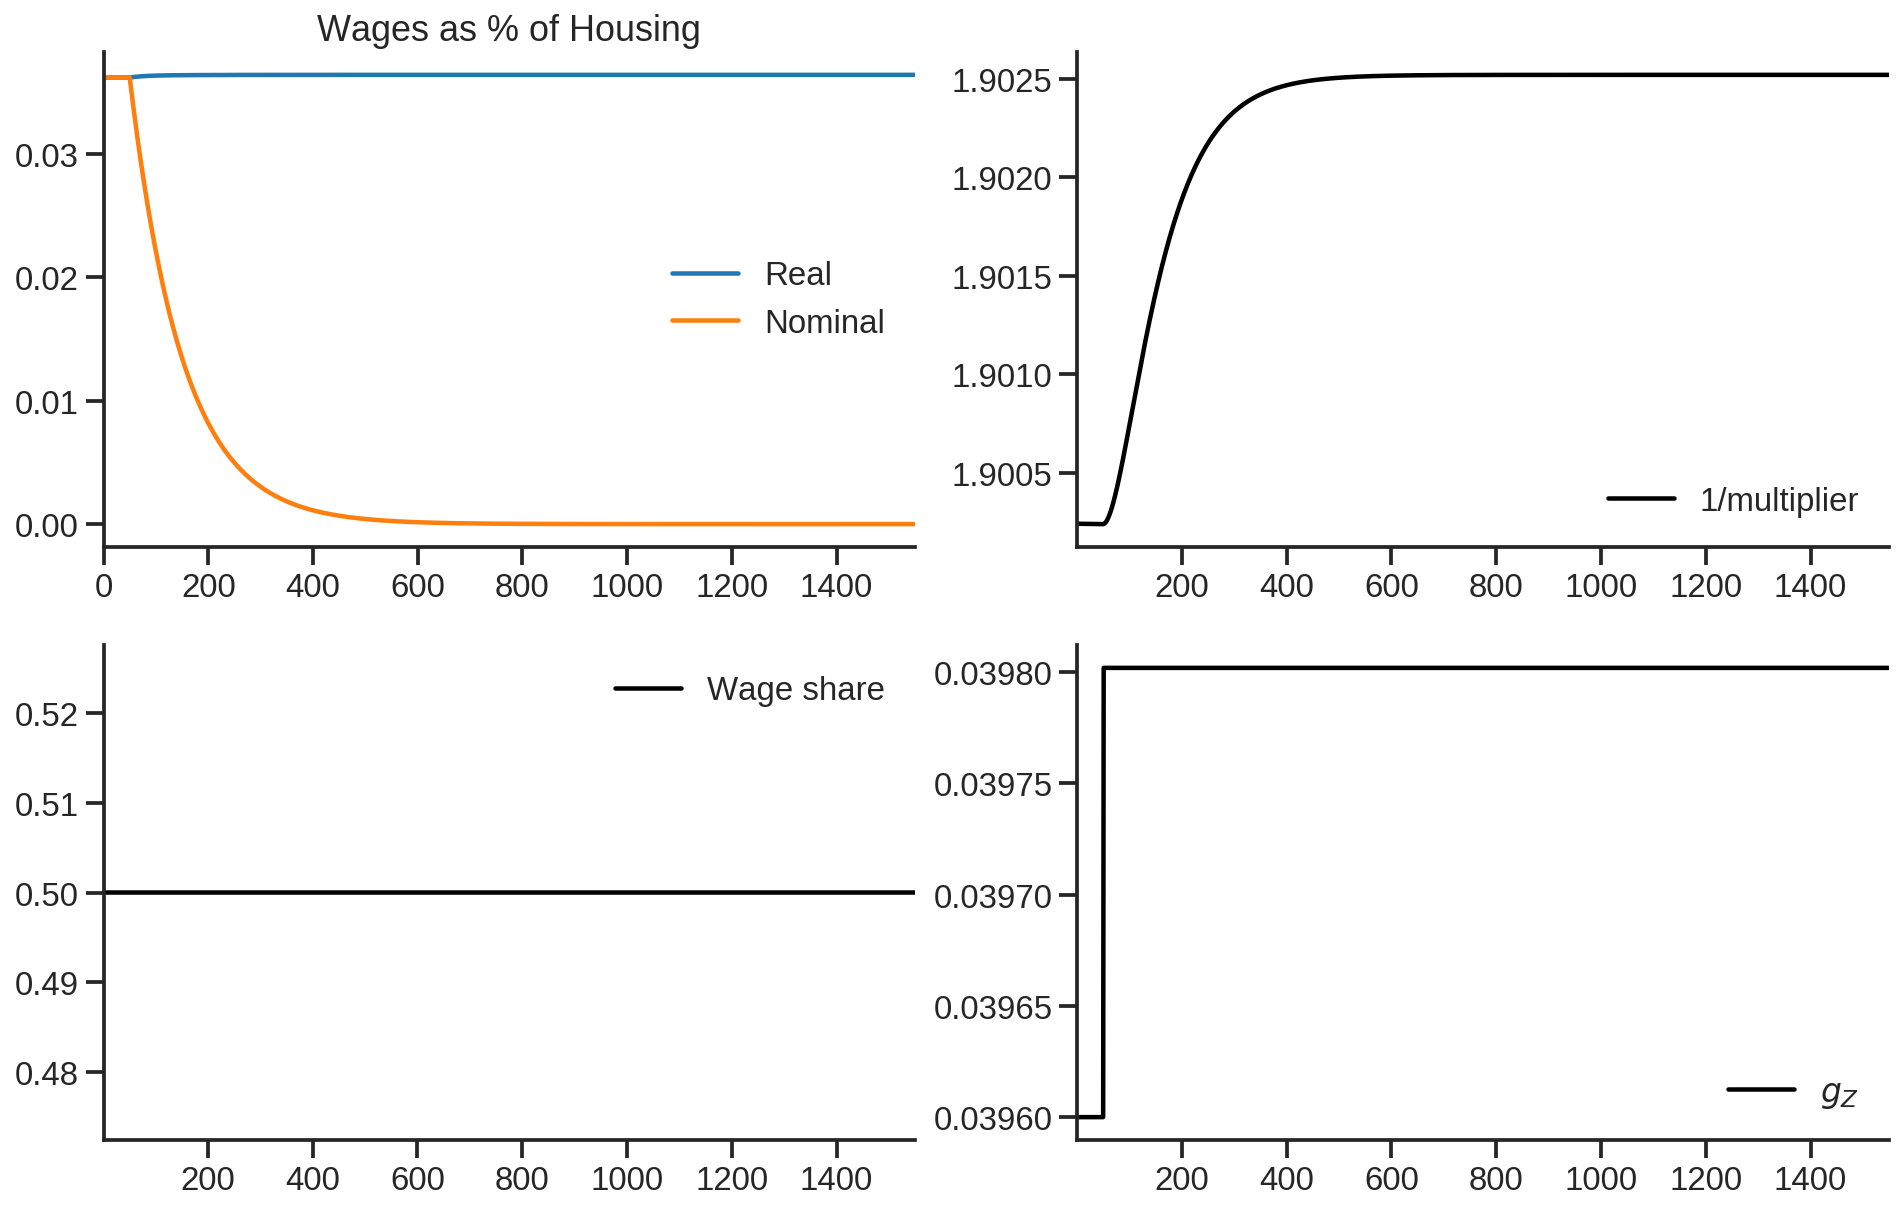

In [40]:
base = model()
df = SolveSFC(base, time=1000)
shock = ShockModel(base_model=base, create_function=model(), variable='infla', increase=0.01, time = 1500)

clock_plots(shock = shock, filename = 'Clock_4.png', variable='infla')
plot_shock(shock = shock, filename = 'Shock_4.png')
plot_norms(shock = shock, filename = 'Shock_4Norms.png')
other_plots(shock)

In [41]:
shock4 = shock.round(decimals = 3).tail(1).transpose().loc['alpha':,:]
shock4.columns = ['$\Delta p_h$']
shock4

$\Delta p_h$
alpha      7.000000e-01
gamma_F    4.000000e-01
gamma_u    1.000000e-02
omega      5.000000e-01
rm         2.000000e-02
spread_l   0.000000e+00
spread_mo  0.000000e+00
un         8.000000e-01
v          2.500000e+00
phi_0      4.000000e-02
phi_1      2.000000e-02
phparam    1.000000e+00
infla      1.000000e-02
gZn        3.900000e-02
_K_f__1    8.123136e+45
_M__1      2.814646e+46
_MO__1     3.432732e+46
_Lf__1    -6.180867e+45
_h__1      1.240000e-01
_L__1     -6.180867e+45
_K_HD__1   3.432732e+46
_I_h__1    1.313996e+45
_ph__1     3.004272e+06
TIME       1.551000e+03
Ih/Y       5.260000e-01
I/Y        6.500000e-01
Z/Y        5.260000e-01
gY         4.000000e-02

## Plugging real data

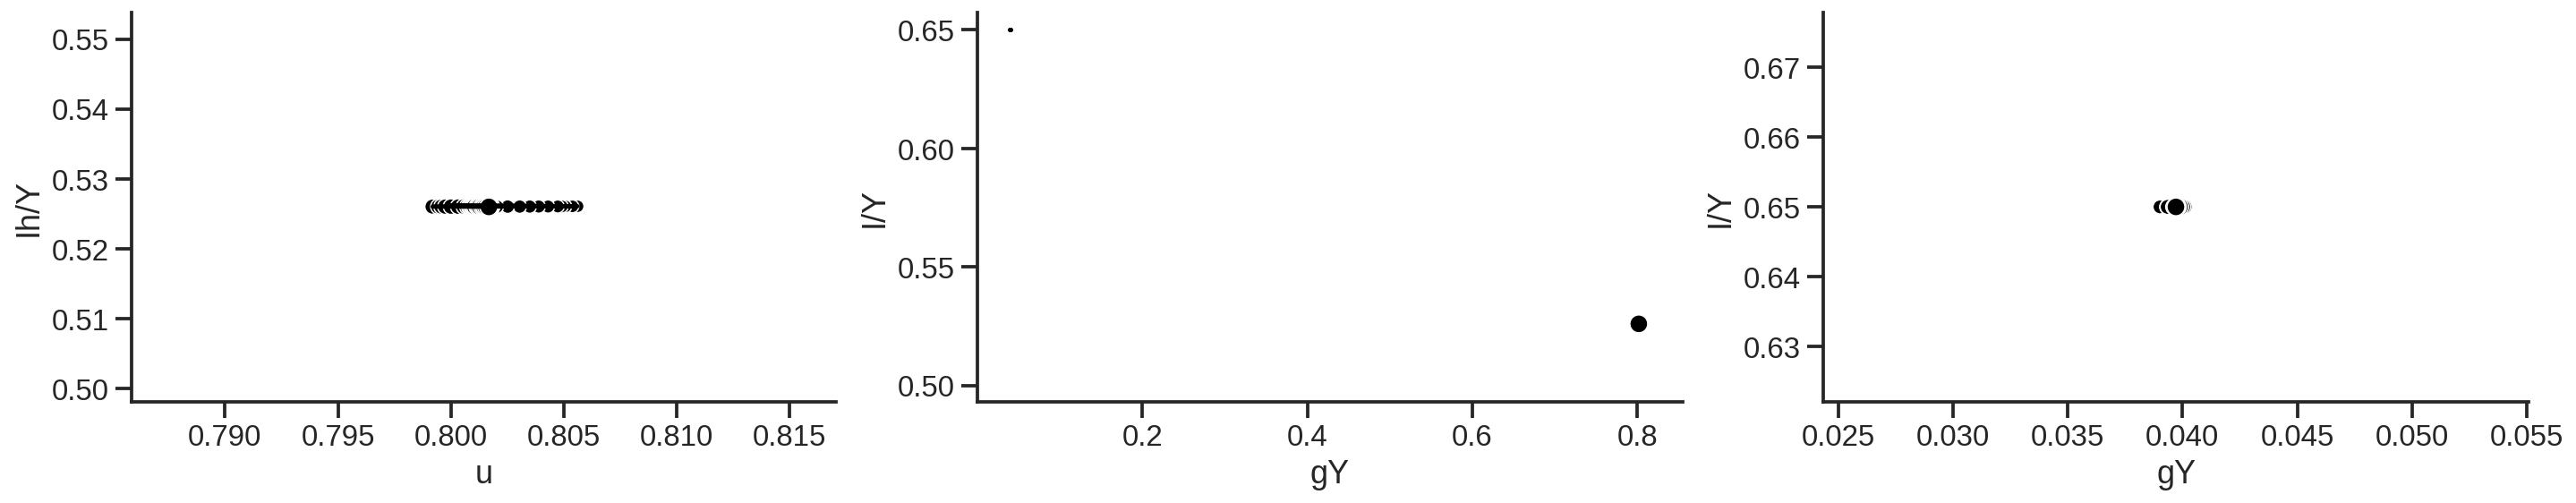

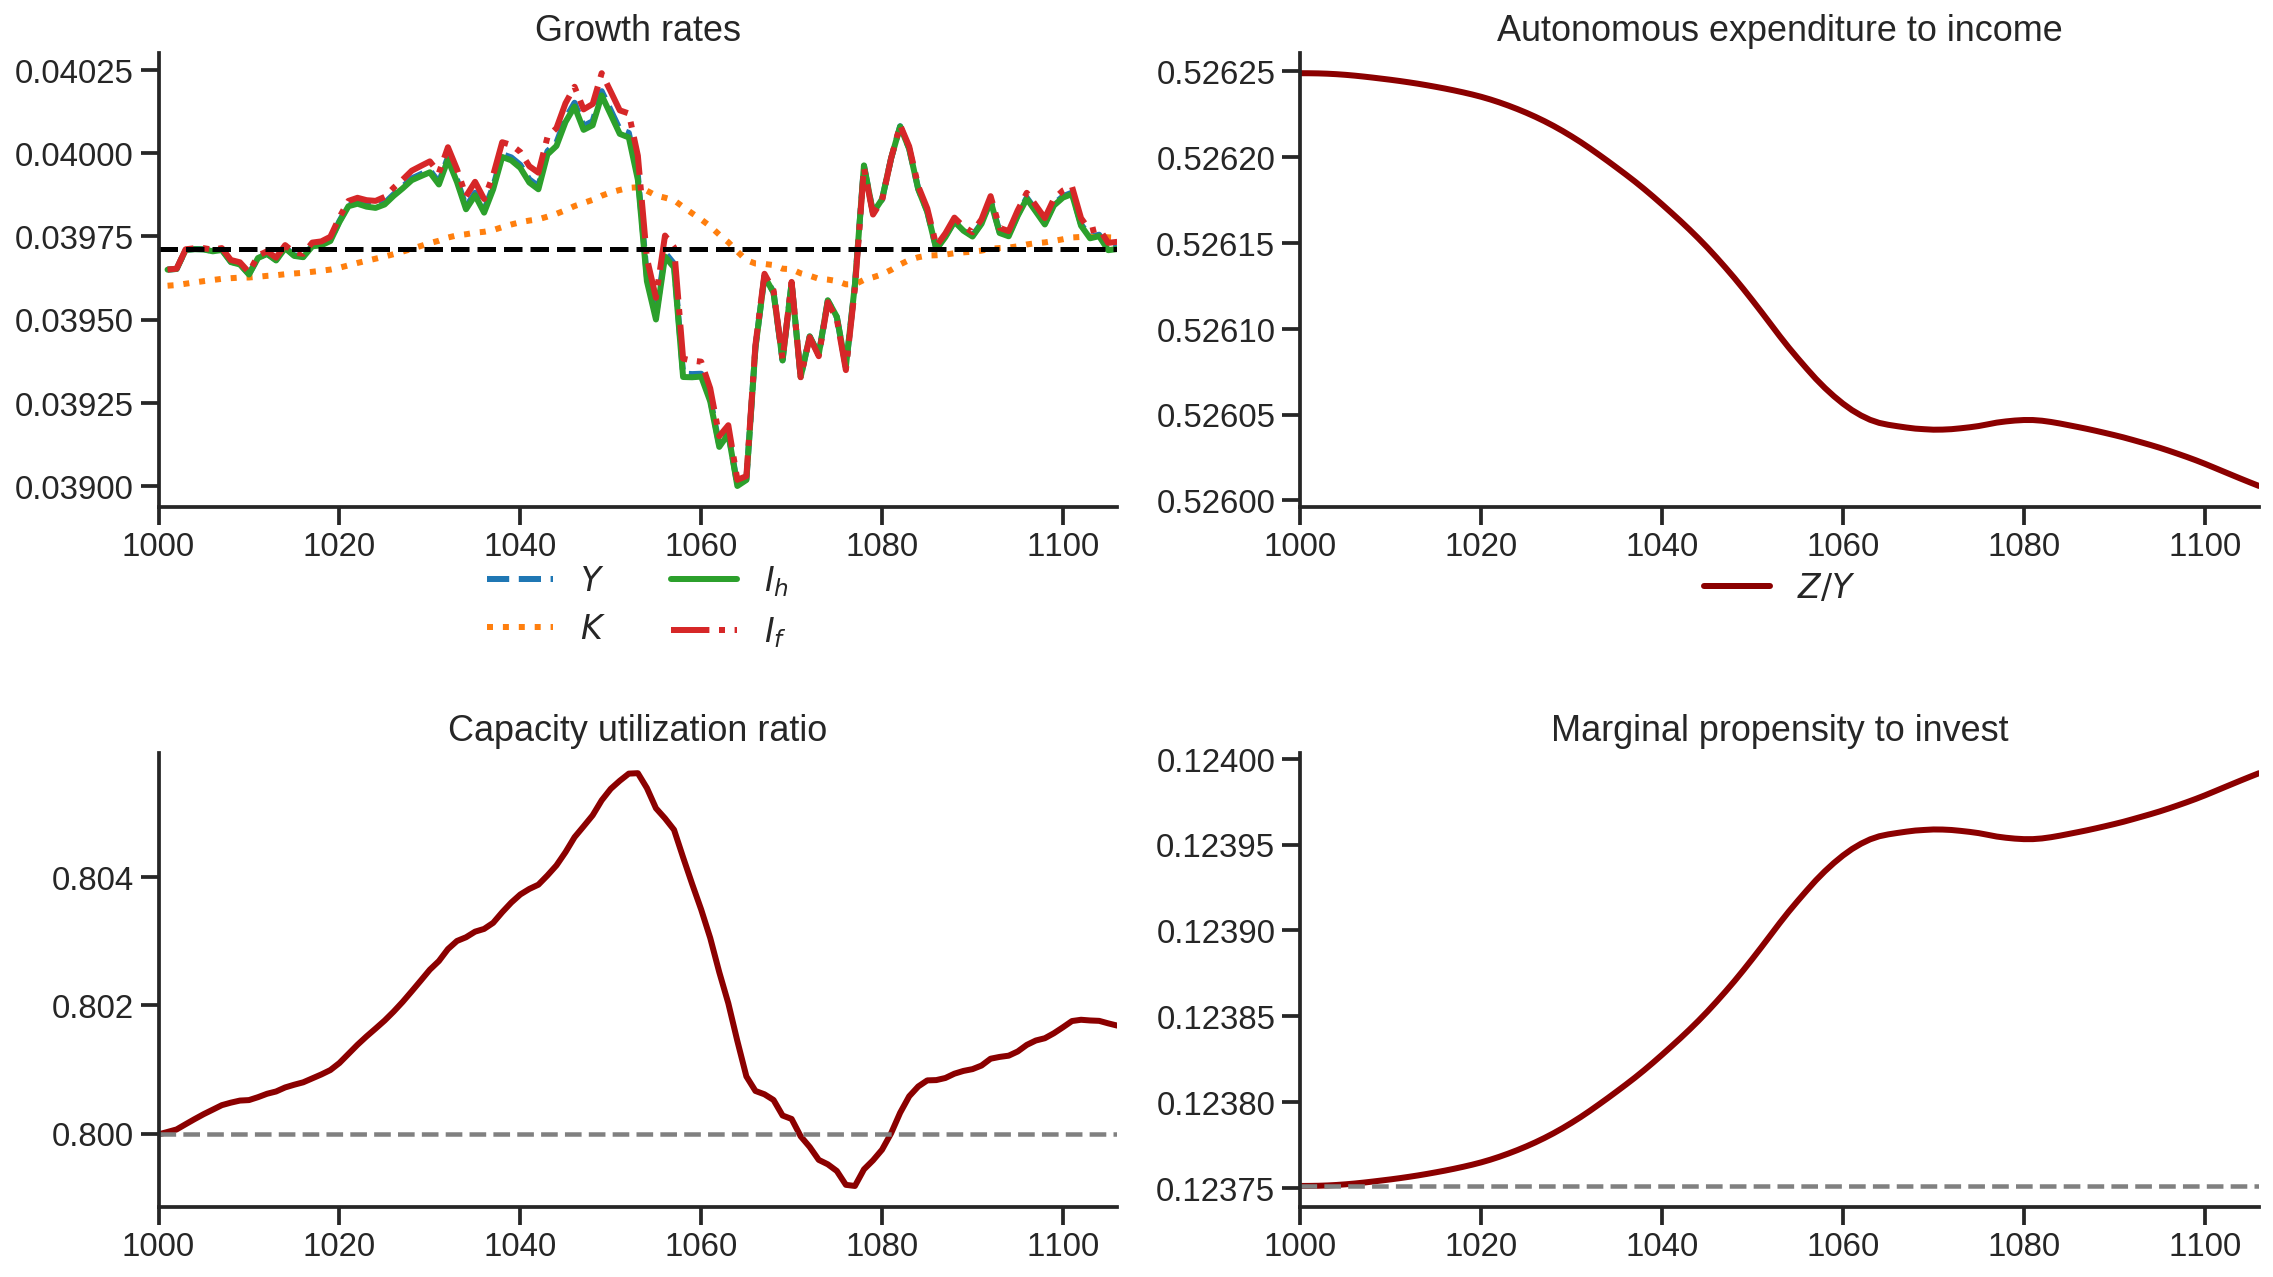

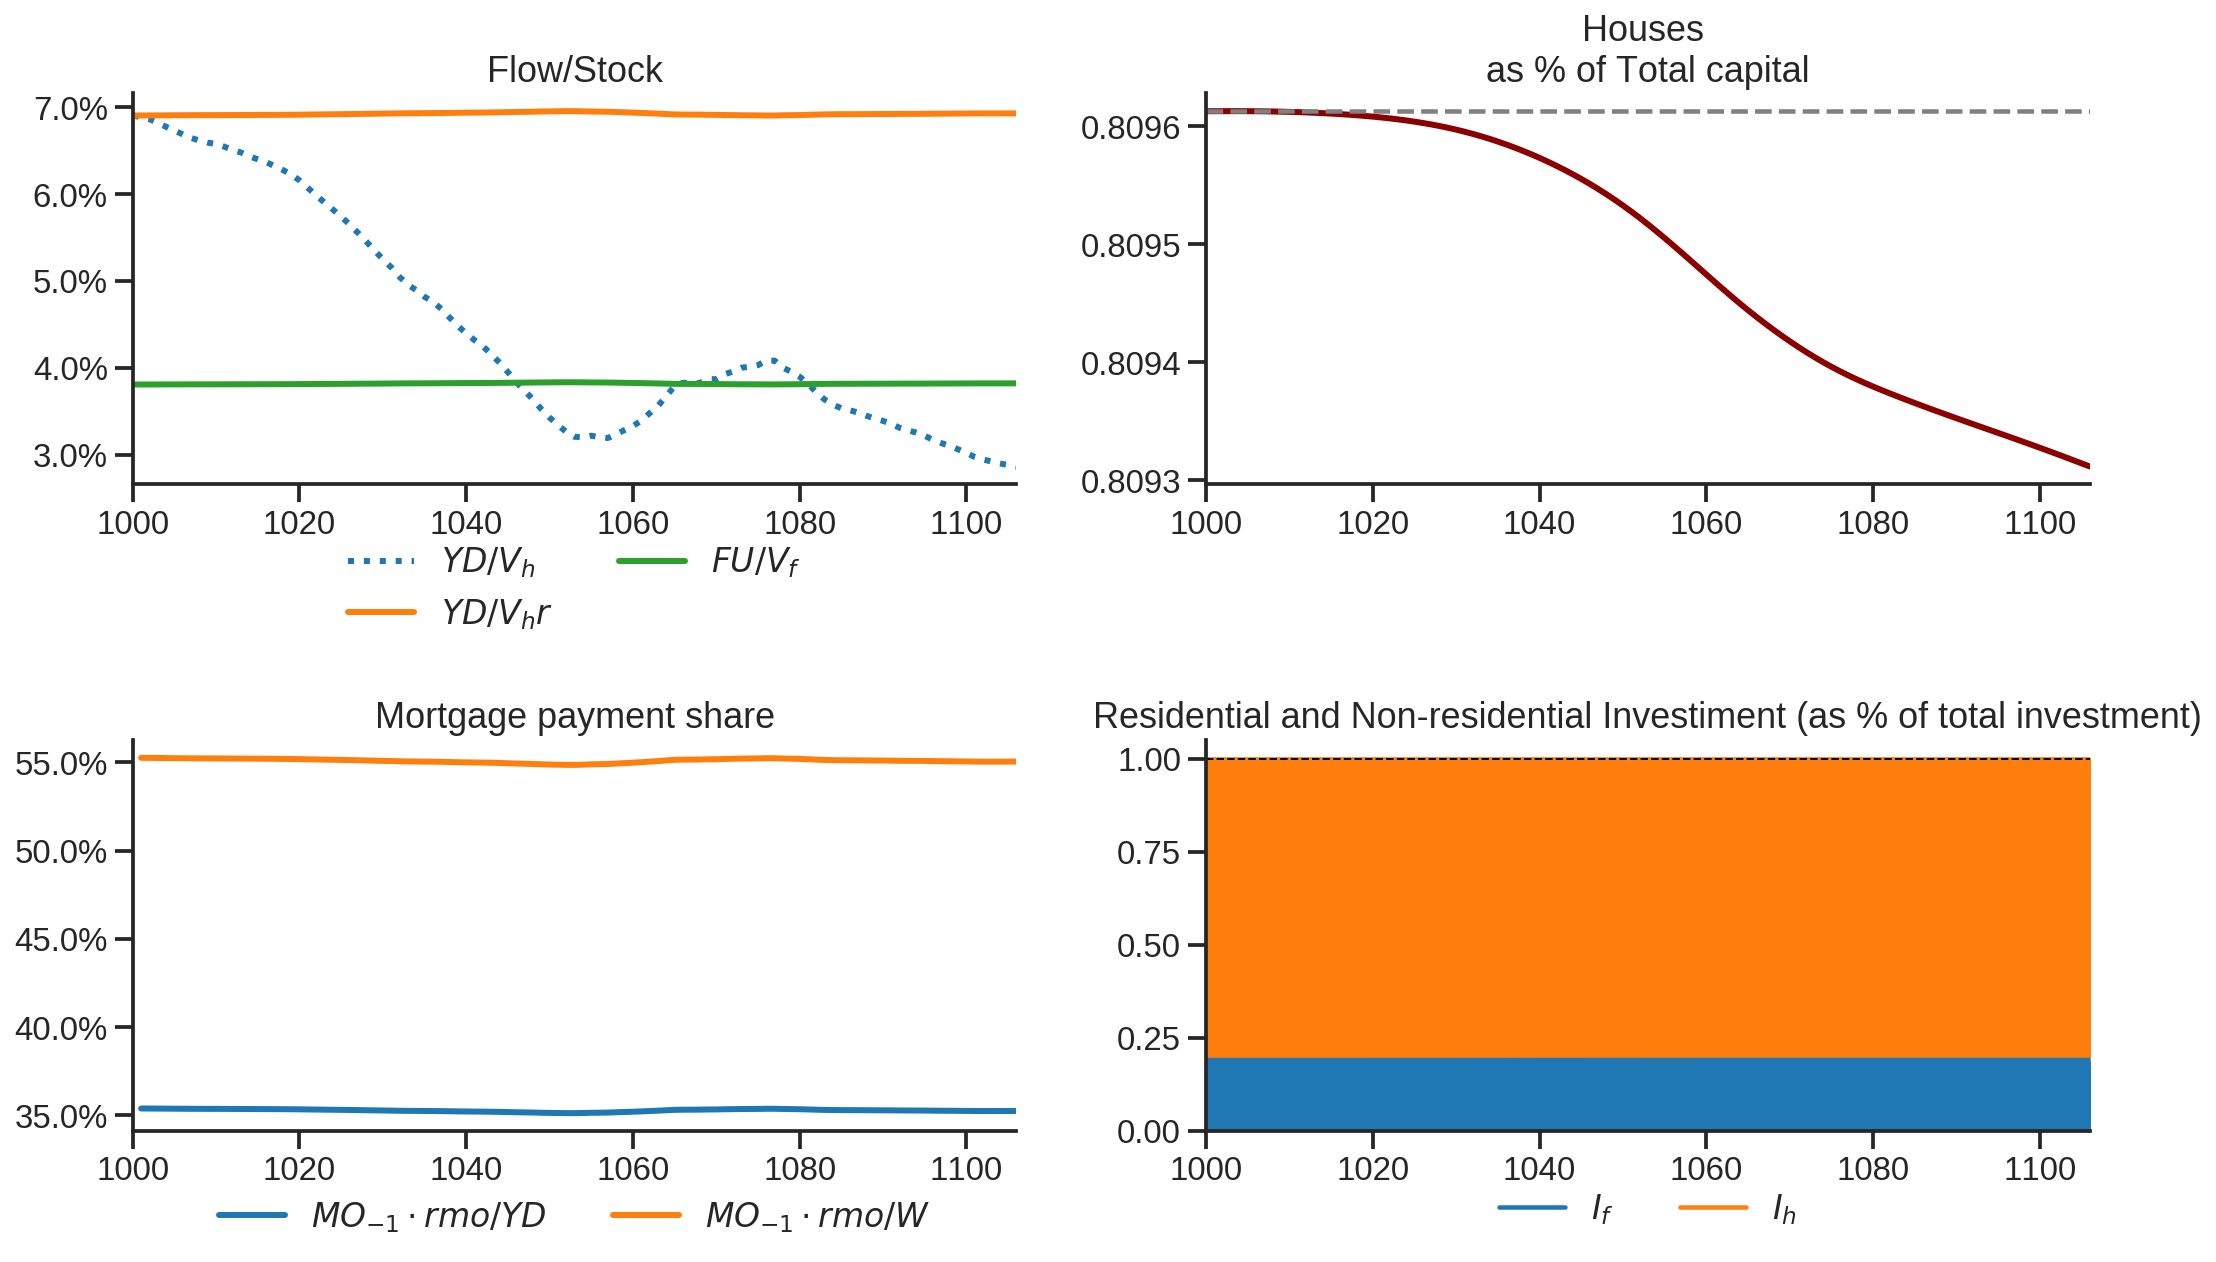

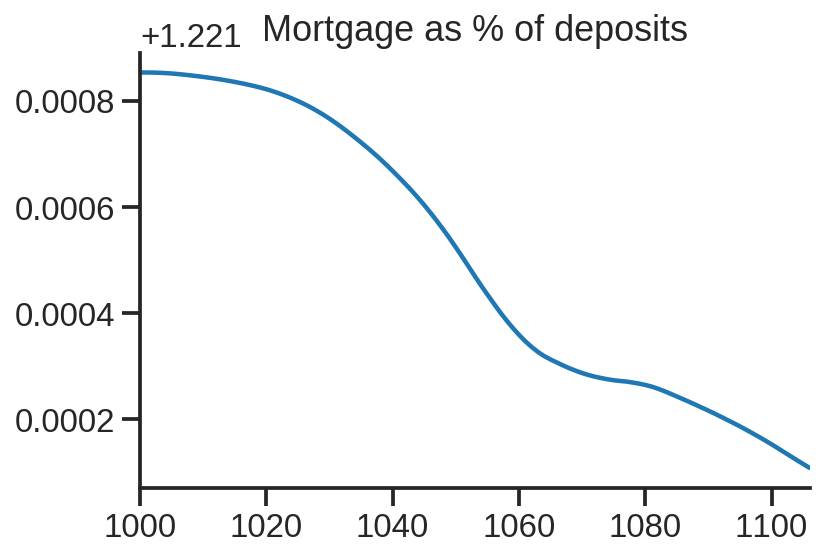

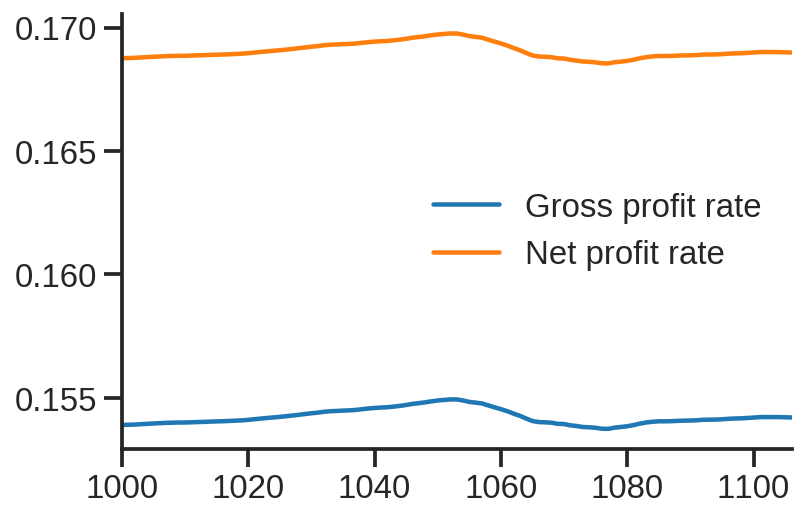

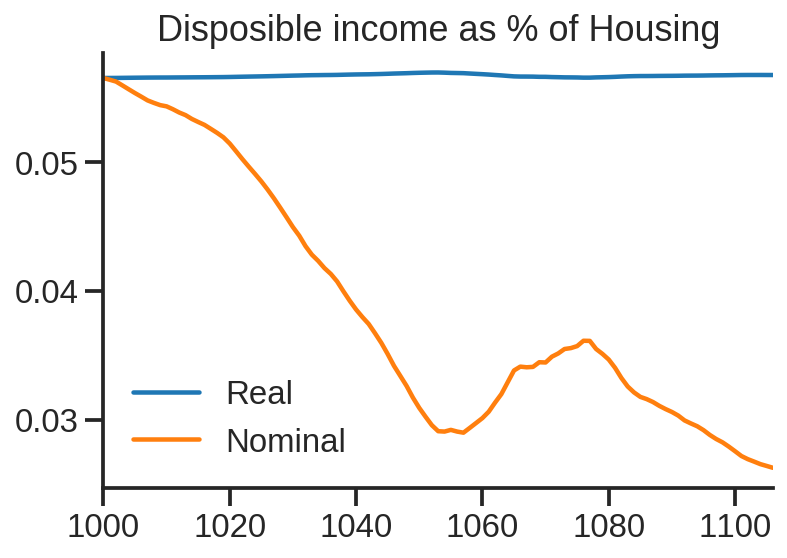

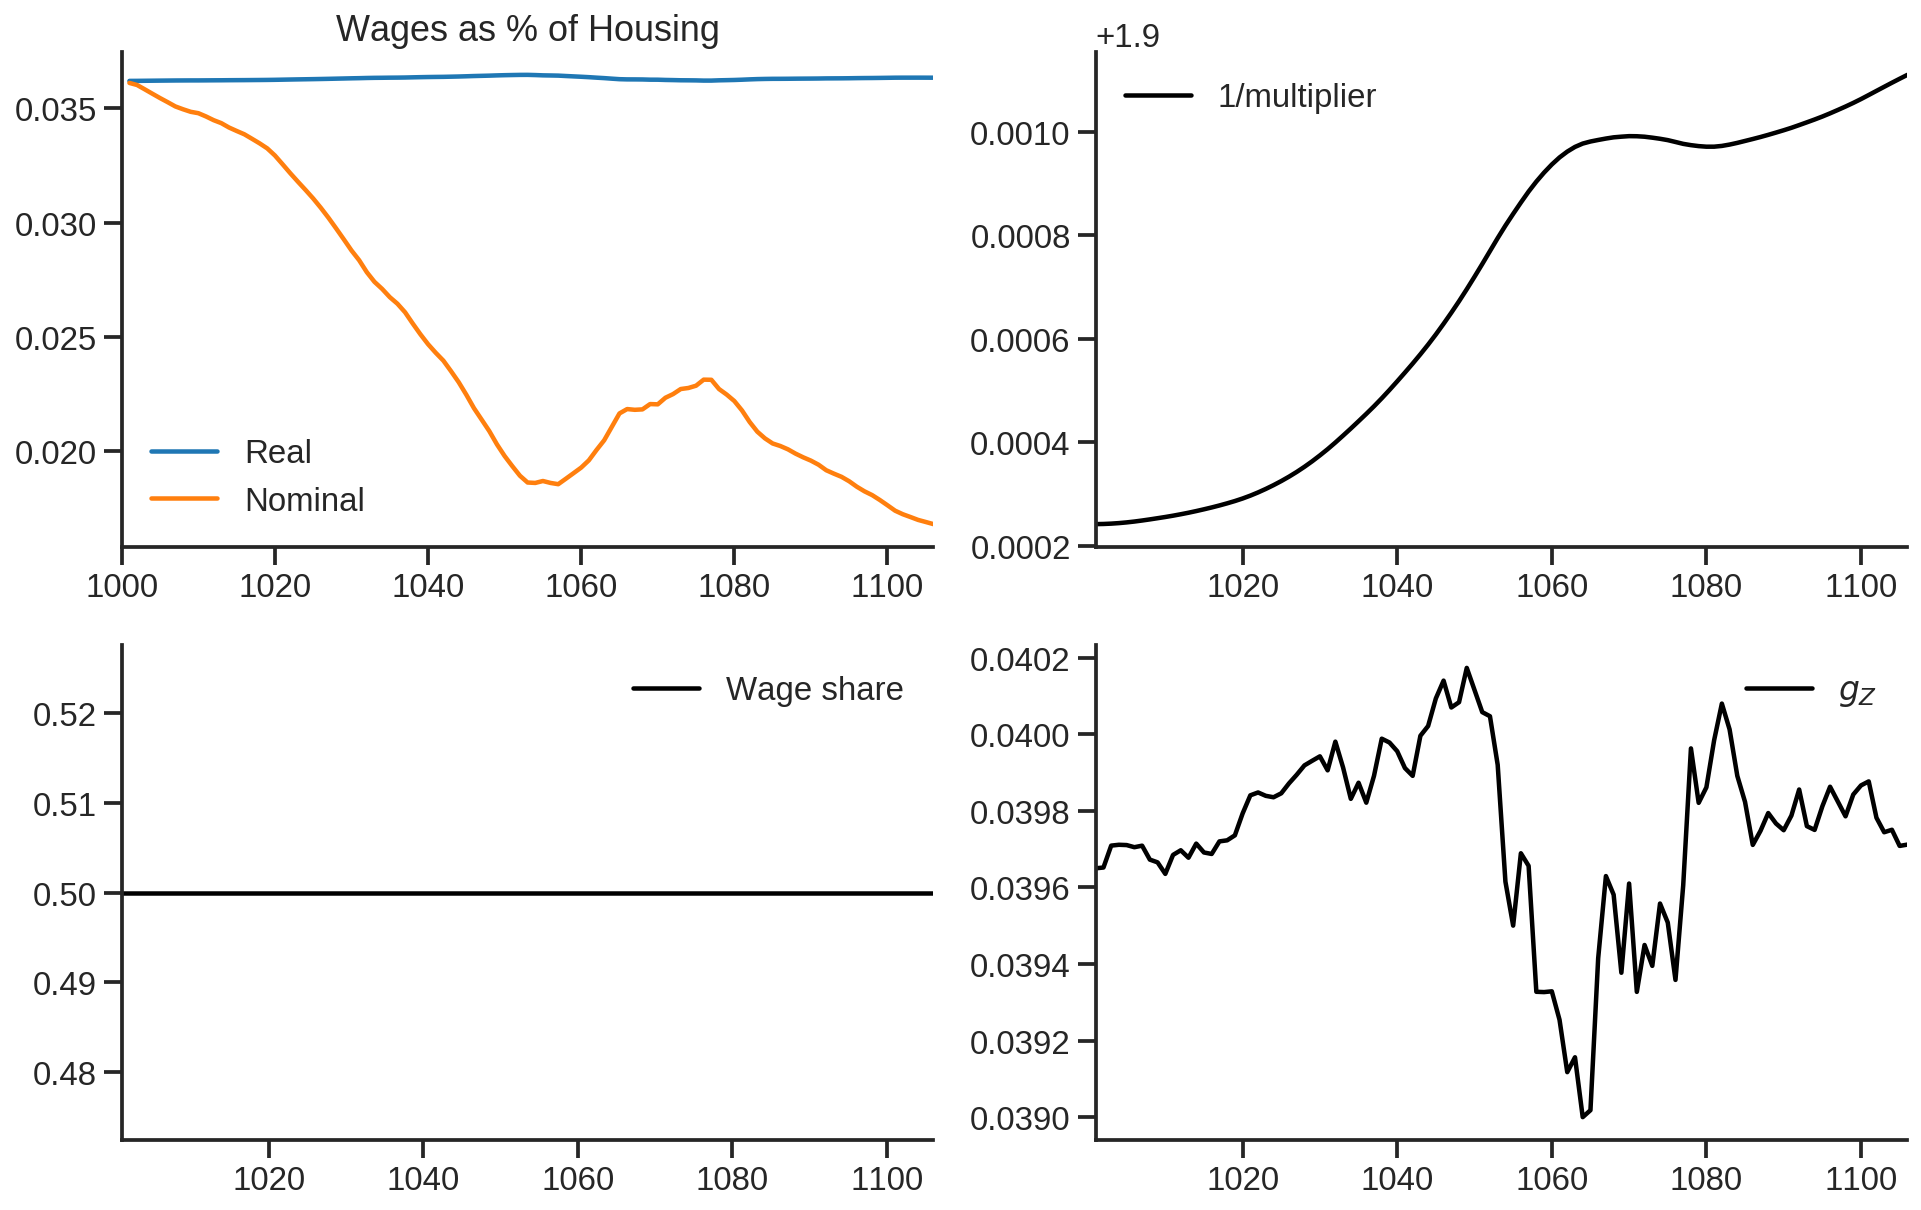

In [42]:
base=model()

initial=1000
shock_duration=1

SolveSFC(base, time=initial, table=False)

for i in data.index:
    lagged = [key for key in base.solutions[-1].keys()]
    lagged = [i for i in lagged if "__" in i]
    for j in lagged:
        del base.solutions[-1][j]
    base.set_values(base.solutions[-1])
    base.set_values({
            'own':data['Taxa Própria'][i],
            'infla':data['Inflação'][i],
        })
    try: 
        SolveSFC(base, time=shock_duration, table=False)
    except Exception as e:
        print(f'For own interest rate = {i}, {e}')
        pass
    
shock = SFCTable(base)[initial:]
clock_plots(shock = shock, filename = 'Clock_5.png', variable='real data')
plot_shock(shock = shock, filename = 'Shock_5.png')
plot_norms(shock = shock, filename = 'Shock_5Norms.png')
other_plots(shock)

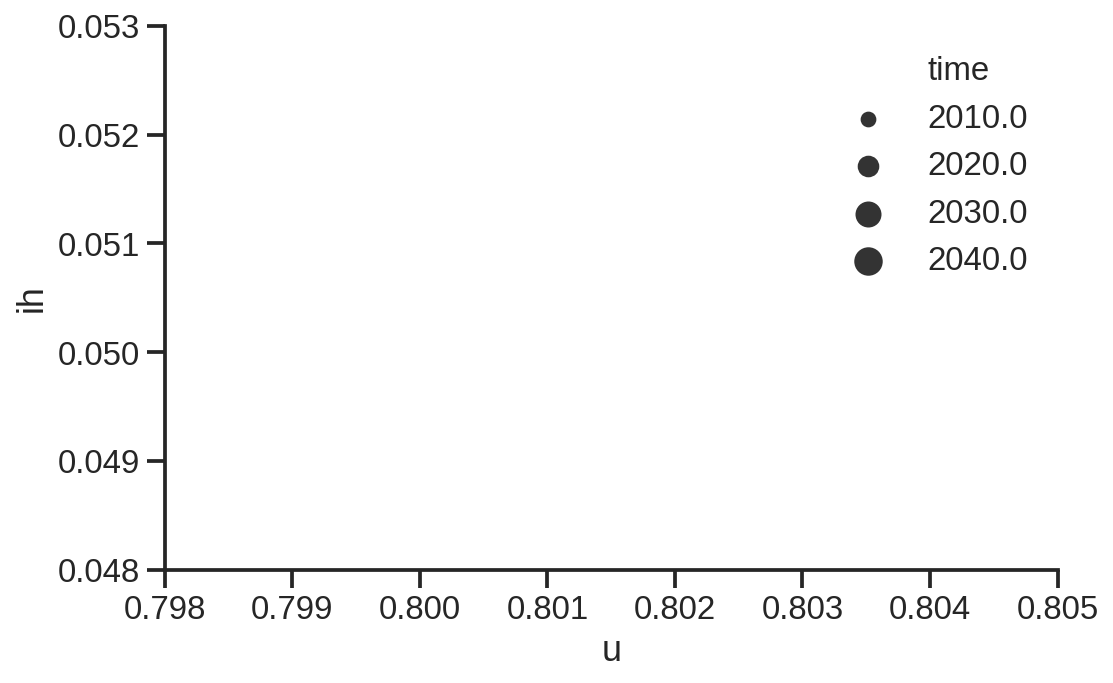

In [43]:
shock['ih'] = shock['I_h']/shock['Y']
shock['time'] = (shock.index/4) - shock.shape[0] + (1987 - 120)

cycle=int(shock.shape[0])

for i in range(0,shock.shape[0],cycle):

    fig, ax = plt.subplots(figsize=(8,5))

    sns.scatterplot(x='u', y='ih', data=shock[i:i+cycle], size='time', color='black')
    sns.lineplot(x = 'u', y='ih', data=shock[i:i+cycle], ax=ax, color = 'black', sort=False,)
    ax.set_xlim(.798,.805)
    ax.set_ylim(.048,.053)
    sns.despine()

# Merging tables

In [44]:
df = df.round(decimals = 3).tail(1).transpose().loc['alpha':,:]
df.columns = ['Base scenario']
df

table = pd.merge(left = df, right = shock1, left_index = True, right_index = True)
table = pd.merge(left = table, right = shock2, left_index = True, right_index = True)
table = pd.merge(left = table, right = shock3, left_index = True, right_index = True)
table = pd.merge(left = table, right = shock4, left_index = True, right_index = True)
table.to_latex("table.tex", bold_rows = True, column_format = 'c', decimal = ',', escape=False,)
table

Base scenario  $\Delta \phi_0$  $\Delta \omega$   $\Delta rm$  \
alpha       7.000000e-01     7.000000e-01     7.000000e-01  7.000000e-01   
gamma_F     4.000000e-01     4.000000e-01     4.000000e-01  4.000000e-01   
gamma_u     1.000000e-02     1.000000e-02     1.000000e-02  1.000000e-02   
omega       5.000000e-01     5.000000e-01     4.500000e-01  5.000000e-01   
rm          2.000000e-02     2.000000e-02     2.000000e-02  2.000000e-02   
spread_l    0.000000e+00     0.000000e+00     0.000000e+00  0.000000e+00   
spread_mo   0.000000e+00     0.000000e+00     0.000000e+00  5.000000e-03   
un          8.000000e-01     8.000000e-01     8.000000e-01  8.000000e-01   
v           2.500000e+00     2.500000e+00     2.500000e+00  2.500000e+00   
phi_0       4.000000e-02     5.000000e-02     4.000000e-02  4.000000e-02   
phi_1       2.000000e-02     2.000000e-02     2.000000e-02  2.000000e-02   
phparam     1.000000e+00     1.000000e+00     1.000000e+00  1.000000e+00   
infla       0.000000e+00     0.000000e+00     0.000000e+00  0.000000e+00   
gZn         3.900000e-02     3.922000e-02     3.900000e-02  3.900000e-02   
_K_f__1     4.364518e+19     1.126648e+44     3.758722e+30  2.029914e+37   
_M__1       1.518996e+20     3.208013e+44     1.338358e+31  7.080443e+37   
_MO__1      1.855990e+20     3.598007e+44     1.704715e+31  8.659263e+37   
_Lf__1     -3.369937e+19    -3.899945e+43    -3.663570e+30 -1.578821e+37   
_h__1       1.240000e-01     1.550000e-01     1.240000e-01  1.230000e-01   
_L__1      -3.369937e+19    -3.899945e+43    -3.663570e+30 -1.578821e+37   
_K_HD__1    1.855990e+20     3.598007e+44     1.704715e+31  8.659263e+37   
_I_h__1     7.069758e+18     1.700278e+43     6.493526e+29  3.290437e+36   
_ph__1      1.000000e+00     1.000000e+00     1.000000e+00  1.000000e+00   

           $\Delta p_h$  
alpha      7.000000e-01  
gamma_F    4.000000e-01  
gamma_u    1.000000e-02  
omega      5.000000e-01  
rm         2.000000e-02  
spread_l   0.000000e+00  
spread_mo  0.000000e+00  
un         8.000000e-01  
v          2.500000e+00  
phi_0      4.000000e-02  
phi_1      2.000000e-02  
phparam    1.000000e+00  
infla      1.000000e-02  
gZn        3.900000e-02  
_K_f__1    8.123136e+45  
_M__1      2.814646e+46  
_MO__1     3.432732e+46  
_Lf__1    -6.180867e+45  
_h__1      1.240000e-01  
_L__1     -6.180867e+45  
_K_HD__1   3.432732e+46  
_I_h__1    1.313996e+45  
_ph__1     3.004272e+06

# Dag

/home/gpetrini/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gpetrini/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


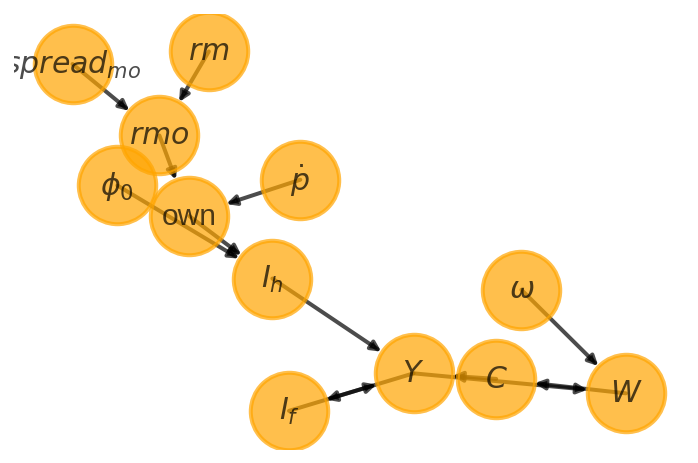

In [45]:
df = pd.DataFrame(
    {
        'Determinada' : [
            '$Y$', # 1
            #'$Y$', # 2
            '$C$', # 3
            '$W$', # 5
            '$Y$', # 7
            '$Y$', # 8
            '$I_h$', # 9
            'own', # 10
            'own', # 11
            '$I_f$', # 12
            '$I_h$', # 13
            '$rmo$', # 14
            '$rmo$', # 15,
            '$W$', # 16
        ], 
        'Determina' : [
            '$C$',  # 1
            #'$It$', # 2
            '$W$', # 3
            '$\omega$', # 5
            '$I_f$', # 7
            '$I_h$', # 8
            'own', # 9
            '$\dot p$', # 10
            '$rmo$', # 11
            '$Y$', # 12,
            '$\phi_0$', # 13
            '$rm$', # 14
            '$spread_{mo}$', # 15
            '$Y$', # 16
        ]
}
)
 
# Build your graph
G=nx.from_pandas_edgelist(
    df, 
    'Determina', 
    'Determinada', 
    create_using=nx.DiGraph() # To use with arrows
)
 
    
fig, ax = plt.subplots()
    
# Plot it
nx.draw(
    G, 
    with_labels=True, 
    node_color='orange', 
    node_size=1500, 
    edge_color='black', 
    linewidths=2,
    width=2,
    arrows=True,
    font_size=15,
    alpha=.7, 
    ax = ax,
    #pos=nx.spring_layout(G),
    pos=nx.fruchterman_reingold_layout(G),
    #pos=nx.shell_layout(G),
)

plt.show()
fig.savefig('Dag.png', dpi = 300)

# Analytical solution

In [46]:
base_eq = model()
SolveSFC(base_eq, time=1, table = False)
t = sp.Symbol('t')
initials = {
    key: base_eq.evaluate(key) for key in base_eq.parameters
}
initials.update({key: base_eq.evaluate(key) for key in base_eq.variables})

for i in base_eq.variables:
  globals()["_" + i] = sp.Function(i)
  
for i in base_eq.parameters:
  globals()[i] = sp.symbols(i, positive=True)
  globals()['infla'] = sp.symbols('infla')

## General equations

In [47]:
Y = _C(t) + _I_t(t)
pprint(sp.Eq(_Y(t), Y))
I = _I_f(t) + _I_h(t)
pprint(sp.Eq(_I_t(t), I))
Yk = _K_f(t)/v
pprint(sp.Eq(_Yk(t), Yk))
u = _Y(t)/_Yk(t)
pprint(sp.Eq(_u(t), u))
Z = _I_h(t)
pprint(sp.Eq(_Z(t), Z))
W = omega*_Y(t)
pprint(sp.Eq(_W(t), W))
K = _K_HD(t) + _K_f(t)
pprint(sp.Eq(_K(t), K))

Y(t) = C(t) + Iₜ(t)
Iₜ(t) = I_f(t) + Iₕ(t)
        K_f(t)
Yk(t) = ──────
          v   
        Y(t)
u(t) = ─────
       Yk(t)
Z(t) = Iₕ(t)
W(t) = ω⋅Y(t)
K(t) = K_HD(t) + K_f(t)


## Households

In [48]:
C = alpha*_W(t)
pprint(sp.Eq(_C(t), C))
YD = _W(t) + _FD(t) + rm*_M(t-1) - _rmo(t)*_MO(t-1)
pprint(sp.Eq(_YD(t), YD))
S_h = _YD(t) - _C(t)
pprint(sp.Eq(_S_h(t), S_h))
dMO = _I_h(t)
pprint(sp.Eq(_MO(t) - _MO(t-1), dMO))
V_h = _M(t) + _K_HD(t) - _MO(t)
pprint(sp.Eq(_V_h(t), V_h))
NFW_h = _S_h(t) - _I_h(t)
pprint(sp.Eq(_NFW_h(t), NFW_h))

C(t) = α⋅W(t)
YD(t) = rm⋅M(t - 1) + FD(t) - MO(t - 1)⋅rmo(t) + W(t)
Sₕ(t) = -C(t) + YD(t)
MO(t) - MO(t - 1) = Iₕ(t)
Vₕ(t) = K_HD(t) + M(t) - MO(t)
NFWₕ(t) = -Iₕ(t) + Sₕ(t)


## Firms

In [49]:
I_f = _h(t)*_Y(t)
pprint(sp.Eq(_I_f(t), I_f))
dK_f = _I_f(t)
pprint(sp.Eq(_K_f(t) - _K_f(t-1), dK_f))
Lf = _I_f(t) - _FU(t) + _L(t-1)
pprint(sp.Eq(_Lf(t), Lf))
FT = _FU(t) + _FD(t)
pprint(sp.Eq(_FT(t), FT))
FU = gamma_F*(_FT(t) - _rl(t)*_L(t-1))
pprint(sp.Eq(_FU(t), FU))
FD = (1 - gamma_F)*(_FT(t) - _rl(t)*_L(t-1))
pprint(sp.Eq(_FD(t), FD))
h = _h(t-1)*gamma_u*(_u(t)-un) + _h(t-1)
pprint(sp.Eq(_h(t), h))
NFW_f = _FU(t) - _I_f(t)
pprint(sp.Eq(_NFW_f(t), NFW_f))
V_f = _K_f(t) - _L(t)
pprint(sp.Eq(_V_f(t), V_f))

I_f(t) = Y(t)⋅h(t)
K_f(t) - K_f(t - 1) = I_f(t)
Lf(t) = -FU(t) + I_f(t) + L(t - 1)
FT(t) = FD(t) + FU(t)
FU(t) = γ_F⋅(FT(t) - L(t - 1)⋅rl(t))
FD(t) = (1 - γ_F)⋅(FT(t) - L(t - 1)⋅rl(t))
h(t) = γᵤ⋅(-un + u(t))⋅h(t - 1) + h(t - 1)
NFW_f(t) = FU(t) - I_f(t)
V_f(t) = K_f(t) - L(t)


## Banks

In [50]:
L = _Lf(t)
pprint(sp.Eq(_L(t), L))
M = (_L(t) - _L(t-1)) + (_MO(t) - _MO(t-1)) + _M(t-1)
pprint(sp.Eq(_M(t), M))
rmo = rm + spread_mo
pprint(sp.Eq(_rmo(t), rmo))
rl = rm + spread_l
pprint(sp.Eq(_rl(t), rl))
V_b = _L(t) + _MO(t) - _M(t)
pprint(sp.Eq(_V_b(t), V_b))
NFW_b = _rl(t)*_L(t-1) + _rmo(t)*_MO(t-1) - rm*_M(t-1)
pprint(sp.Eq(_NFW_b(t), NFW_b))

L(t) = Lf(t)
M(t) = L(t) - L(t - 1) + M(t - 1) + MO(t) - MO(t - 1)
rmo(t) = rm + spreadₘₒ
rl(t) = rm + spreadₗ
V_b(t) = L(t) - M(t) + MO(t)
NFW_b(t) = -rm⋅M(t - 1) + L(t - 1)⋅rl(t) + MO(t - 1)⋅rmo(t)


## Residential Investment

In [51]:
_own = sp.Function('own')

K_HS = _K_HD(t)
pprint(sp.Eq(_K_HS(t), K_HS))
Is = _I_h(t)
pprint(sp.Eq(_Is(t), Is))
dK_HD = _I_h(t)
pprint(sp.Eq(_K_HD(t) - _K_HD(t-1), dK_HD))
I_h = (1+_g_Z(t))*_I_h(t-1)
pprint(sp.Eq(_I_h(t), I_h))
K_k = _K_HD(t)/(_K(t))
pprint(sp.Eq(_K_k(t), K_k))
ph = (1+infla)*_ph(t-1)
pprint(sp.Eq(_ph(t), ph))
own = ((1+_rmo(t))/(1+infla))-1
pprint(sp.Eq(_own(t), own))
g_Z = phi_0 - phi_1*_own(t)
pprint(sp.Eq(_g_Z(t), g_Z))

K_HS(t) = K_HD(t)
Is(t) = Iₕ(t)
K_HD(t) - K_HD(t - 1) = Iₕ(t)
Iₕ(t) = (g_Z(t) + 1)⋅Iₕ(t - 1)
        K_HD(t)
Kₖ(t) = ───────
          K(t) 
ph(t) = (infla + 1)⋅ph(t - 1)
              rmo(t) + 1
own(t) = -1 + ──────────
              infla + 1 
g_Z(t) = φ₀ - φ₁⋅own(t)


### Stability condition

In [52]:
g = sp.Function('g')
gK = sp.Function('g_K')


def replacer(express):
    #print("\nReplacing the initial values.....")
    df = SolveSFC(model(), time=1)
    df = df.iloc[1, :]

    express = express.subs(alpha, df['alpha']).subs(
        omega, df['omega'])
    express = express.subs(un, df['un']).subs(
        gamma_u, df['gamma_u'])
    express = express.subs(
        infla, df['infla'])
    express = express.subs(phi_0, df['phi_0']).subs(
        phi_1,
        df['phi_1']).subs(rm, df['rm']).subs(
            spread_mo, df['spread_mo'])
    express = express.subs(rm, df['rm']).subs(
            spread_mo, df['spread_mo']).subs(v, df['v'])
    return express

In [53]:
EqY = Y - _Y(t)
EqY = EqY.subs(_C(t), C).subs(_I_t(t), I)
EqY = EqY.subs(_I_f(t), I_f)
EqY = EqY.subs(_W(t), W)
EqY = EqY.subs(_I_h(t), _Z(t))

EqY = sp.solve(EqY, _Y(t))[0].collect(alpha).collect(omega)
solY = EqY
pprint(cse(solY, optimizations='basic')[1], use_unicode=True)
print('dY/d alpha = ', EqY.diff(alpha))
print('dY/d omega = ', EqY.diff(omega))

print("\nGowth rate.....")
gY, h_, gz_ = sp.symbols('gY h gZ')
gY_ = alpha * omega * gY + _h(t) * gY + _h(t) - _h(
    t - 1) + (_Z(t) / _Y(t)) * _g_Z(t) - gY
gY_ = gY_.subs(_g_Z(t), gz_).subs(_Y(t), solY).subs(_g_Z(t), gz_)
gY_ = gY_.subs(_h(t) - _h(t - 1), h - _h(t - 1))
gY_ = sp.solve(gY_, gY)[0].collect(gz_)
pprint(sp.Eq(g(t), sp.simplify(gY_)))

print('\nd gY/ d alpha\n')
pprint(gY_.diff(alpha))
print('\nd gY/ d omega\n')
pprint(gY_.diff(omega))

⎡    -Z(t)     ⎤
⎢──────────────⎥
⎣α⋅ω + h(t) - 1⎦
dY/d alpha =  omega*Z(t)/(alpha*omega + h(t) - 1)**2
dY/d omega =  alpha*Z(t)/(alpha*omega + h(t) - 1)**2

Gowth rate.....
       gZ⋅(α⋅ω + h(t) - 1) + γᵤ⋅un⋅h(t - 1) - γᵤ⋅h(t - 1)⋅u(t)
g(t) = ───────────────────────────────────────────────────────
                            α⋅ω + h(t) - 1                    

d gY/ d alpha

     gZ⋅ω        ω⋅(gZ⋅(α⋅ω + h(t) - 1) + γᵤ⋅un⋅h(t - 1) - γᵤ⋅h(t - 1)⋅u(t))
────────────── - ───────────────────────────────────────────────────────────
α⋅ω + h(t) - 1                                        2                     
                                      (α⋅ω + h(t) - 1)                      

d gY/ d omega

     α⋅gZ        α⋅(gZ⋅(α⋅ω + h(t) - 1) + γᵤ⋅un⋅h(t - 1) - γᵤ⋅h(t - 1)⋅u(t))
────────────── - ───────────────────────────────────────────────────────────
α⋅ω + h(t) - 1                                        2                     
                                      (α⋅ω + h(t) - 1)            

### Stability conditon (I)

In [54]:
own_ = sp.Symbol('own')
g_LR = gY_.subs(_u(t), un)
pprint(sp.Eq(g(t), g_LR))

Equ = _u(t)*(g(t) - gK(t)) + _u(t-1)
pprint(sp.Eq(_u(t), Equ))
g_K = (_h(t)*_u(t))/v
pprint(sp.Eq(gK(t), g_K))
Equ = _u(t)*(g(t) - g_K)
Equ = Equ.subs(g(t), gz_)
pprint(sp.Eq(_u(t), Equ))
print(sp.latex(sp.Eq(_u(t), Equ)))

Eqh = _h(t)*gamma_u*(_u(t) - un)
pprint(sp.Eq(_h(t), Eqh))
print(sp.latex(sp.Eq(_h(t), Eqh)))

print('\nBuilding Jacobian matrix and evaluating at u = un\n')
J = sp.Matrix([
        [
            Eqh.diff(_h(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), g_LR*v/un), 
            Eqh.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), g_LR*v/un)
        ], 
        [
            Equ.diff(_h(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), g_LR*v/un), 
            Equ.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), g_LR*v/un)
        ]])
pprint(J)
print(sp.latex(J))
print('\nDeterminant:\n')
pprint(J.det()>0)
print(sp.latex(J.det()>0))
estability = sp.solve(J.det().subs(gz_, g_Z).subs(_own(t), own_)>0, own_)
print("\nStability condition\n")
pprint(estability)
estability = replacer(estability)
pprint(estability)
pprint(sp.Eq(own_, initials['own']))
estability = estability.subs(own_, own)
pprint(estability)
print('Rewriting')
estability = -(1+infla) + (1+rmo) < 2*(1+infla)
pprint(estability)
estability = sp.solve(estability, infla)
pprint(estability)
estability = estability.subs(spread_mo, initials['spread_mo']).subs(rm, initials['rm'])
pprint(estability)

print('\nTrace:\n')
pprint(J.trace()<0)
print(sp.latex(J.trace()<0))
print("\nStability condition\n")
estability = sp.solve(J.trace()<0).subs(gz_, g_Z)
pprint(estability)
estability = estability.subs(_own(t), own).subs(_rmo(t), rmo)
pprint(estability)
estability = estability.subs(spread_mo, initials['spread_mo']).subs(rm, initials['rm'])
estability = estability.subs(phi_0, initials['phi_0']).subs(phi_1, initials['phi_1'])
pprint(estability)

g(t) = gZ
u(t) = (g(t) - g_K(t))⋅u(t) + u(t - 1)
         h(t)⋅u(t)
g_K(t) = ─────────
             v    
       ⎛     h(t)⋅u(t)⎞     
u(t) = ⎜gZ - ─────────⎟⋅u(t)
       ⎝         v    ⎠     
u{\left(t \right)} = \left(gZ - \frac{h{\left(t \right)} u{\left(t \right)}}{v}\right) u{\left(t \right)}
h(t) = γᵤ⋅(-un + u(t))⋅h(t)
h{\left(t \right)} = \gamma_{u} \left(- un + u{\left(t \right)}\right) h{\left(t \right)}

Building Jacobian matrix and evaluating at u = un

⎡       gZ⋅γᵤ⋅v⎤
⎢  0    ───────⎥
⎢          un  ⎥
⎢              ⎥
⎢   2          ⎥
⎢-un           ⎥
⎢─────    -gZ  ⎥
⎣  v           ⎦
\left[\begin{matrix}0 & \frac{gZ \gamma_{u} v}{un}\\- \frac{un^{2}}{v} & - gZ\end{matrix}\right]

Determinant:

gZ⋅γᵤ⋅un > 0
gZ \gamma_{u} un > 0

Stability condition

      φ₀
own < ──
      φ₁
own < 2.0
own = 0.02
     rmo(t) + 1      
-1 + ────────── < 2.0
     infla + 1       
Rewriting
-infla + rm + spreadₘₒ < 2⋅infla + 2
        rm   spreadₘₒ   2
infla > ── + ──────── - ─
        3     

### Stability condition (II)

In [55]:
print('d gY/d u < d gK/ d u')
print('d gY/ d u :')
pprint(gY_.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un))

print('d gK/ d u :')
pprint(g_K.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un))

print('Solving the inequality')
pprint(sp.solve(gY_.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un)< g_K.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un), gamma_u))
print(sp.latex(sp.solve(gY_.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un)< g_K.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un), gamma_u)))

d gY/d u < d gK/ d u
d gY/ d u :
     -gZ⋅γᵤ⋅v      
───────────────────
   ⎛      gZ⋅v    ⎞
un⋅⎜α⋅ω + ──── - 1⎟
   ⎝       un     ⎠
d gK/ d u :
gZ
──
un
Solving the inequality
    -gZ⋅γᵤ⋅v         gZ
────────────────── < ──
α⋅ω⋅un + gZ⋅v - un   un
- \frac{gZ \gamma_{u} v}{\alpha \omega un + gZ v - un} < \frac{gZ}{un}


## Capacity utilization on the long-run

Consider $k$ as the fraction between real housing and total capital (including households' capital):

$$
k = \frac{K_h}{K}
$$

The capacity utilization ration can be definede as:

$$
u = \frac{Y\cdot v}{K \cdot (1-k)}
$$

So, dividing Y by houseolds' capital is the same as:

$$
\frac{Y}{k\cdot K}
$$

Multiplying by $v$:


$$
\frac{Y}{k\cdot K}\cdot v = \frac{Y\cdot v}{K}\cdot \left(\frac{1}{k}\right)
$$

Multiplying and dividing by $1-k$:

$$
\frac{Y\cdot v}{K\cdot (1-k)}\cdot \left(\frac{1-k}{k}\right) = u \cdot \left(\frac{1-k}{k}\right)
$$

Therefore,

$$
Y\frac{v}{K_h} =  u \cdot \left(\frac{1-k}{k}\right)
$$

$$
u = Y\frac{v}{K_h} \cdot \left(\frac{k}{1-k}\right)
$$

In [56]:
k = sp.Symbol('K_k')

rel = solY*(v/_K_HD(t))*(k/(1-k))
rel = rel.subs(_Z(t), Z)
rel = rel.subs(_I_h(t)/_K_HD(t), g_Z)
rel = rel.subs(_h(t), h)

pprint(rel)
print('\nFor the long run...\n')

rel = rel.subs(_u(t), un).subs(_h(t-1), _h(t))
rel = rel.subs(_h(t), g_Z*v/un)
rel = rel.subs(_own(t), own)
rel = rel.subs(_rmo(t), rmo)

pprint(sp.Eq(_u(t), rel))
print(sp.latex(sp.Eq(_u(t), rel)))

def collector(express):
    express = express.simplify().collect(phi_0).collect(phi_1).collect(v)
    express = express.collect(omega).collect(alpha).collect(un).collect(infla+1)
    express = express.simplify()
    return express


rel = rel - un
rel = sp.solve(rel,k/(1-k))[0]
pprint(sp.Eq(k/(1-k), collector(rel)))
print(sp.latex(sp.Eq(k/(1-k), collector(rel))))
pprint(sp.Eq(k/(1-k), replacer(rel)))
print(f"Error = {replacer(rel) - base.evaluate('K_k/(1-K_k)')}")

print('\n' + '='*70)
print('\nChange in income distribution:\n')
result = collector(rel.diff(omega))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd (k/1-k)/ d omega > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in spread:\n')
result = collector(rel.diff(spread_mo))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd (k/1-k)/ d spread > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in inflation:\n')
result = collector(rel.diff(infla))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd (k/1-k)/ d inflation > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in autonomous component:\n')
result = collector(rel.diff(phi_0))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd (k/1-k)/ d phi_0 > 0? {result > 0}')

print('\n' + '='*70)
print('\nHousing as % of total Capital\n')
rel = rel*(1-k) - k
rel = sp.solve(rel, k)[0]
pprint(sp.Eq(k, collector(rel)))
print(sp.latex(sp.Eq(k, collector(rel))))
print(f"Error = {replacer(rel) - base.evaluate('K_k')}")
print(f"Error = {replacer(1-rel) - base.evaluate('(g_Z*v/un)/(1-alpha*omega)')}")

print('\n' + '='*70)
print('\nChange in income distribution:\n')
result = collector(rel.diff(omega))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d omega > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in spread:\n')
result = collector(rel.diff(spread_mo))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d spread > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in inflation:\n')
result = collector(rel.diff(infla))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d inflation > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in autonomous component:\n')
result = collector(rel.diff(phi_0))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d phi_0 > 0? {result > 0}')

print('\n' + '='*70)
print('\nFirms capital as % of total Capital:\n')
rel = (g_Z*v/un)/(1-omega*alpha)
rel = rel.subs(_own(t), own).subs(_rmo(t), rmo)
pprint(sp.Eq(1-k, rel))

print('\n' + '='*70)
print('\nChange in income distribution:\n')
result = collector(rel.diff(omega))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d omega > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in spread:\n')
result = collector(rel.diff(spread_mo))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d spread > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in inflation:\n')
result = collector(rel.diff(infla))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d inflation > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in autonomous component:\n')
result = collector(rel.diff(phi_0))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d phi_0 > 0? {result > 0}')

print('\n' + '='*70)
print('\nRevisiting Houses as % of total Capital:\n')
rel = 1 - rel
pprint(sp.Eq(k, rel))
print(sp.latex(sp.Eq(k, rel)))

print('\n' + '='*70)
print('\nChange in income distribution:\n')
result = collector(rel.diff(omega))
pprint(result)
print(sp.latex(result))
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d omega > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in spread:\n')
result = collector(rel.diff(spread_mo))
pprint(result)
print(sp.latex(result))
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d spread > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in inflation:\n')
result = collector(rel.diff(infla))
pprint(result)
print(sp.latex(result))
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d inflation > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in autonomous component:\n')
result = collector(rel.diff(phi_0))
pprint(result)
print(sp.latex(result))
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d phi_0 > 0? {result > 0}')

                -Kₖ⋅v⋅(φ₀ - φ₁⋅own(t))                  
────────────────────────────────────────────────────────
(1 - Kₖ)⋅(α⋅ω + γᵤ⋅(-un + u(t))⋅h(t - 1) + h(t - 1) - 1)

For the long run...

                     ⎛        ⎛     rm + spreadₘₒ + 1⎞⎞         
               -Kₖ⋅v⋅⎜φ₀ - φ₁⋅⎜-1 + ─────────────────⎟⎟         
                     ⎝        ⎝         infla + 1    ⎠⎠         
u(t) = ─────────────────────────────────────────────────────────
                ⎛            ⎛        ⎛     rm + spreadₘₒ + 1⎞⎞⎞
                ⎜          v⋅⎜φ₀ - φ₁⋅⎜-1 + ─────────────────⎟⎟⎟
                ⎜            ⎝        ⎝         infla + 1    ⎠⎠⎟
       (1 - Kₖ)⋅⎜α⋅ω - 1 + ────────────────────────────────────⎟
                ⎝                           un                 ⎠
u{\left(t \right)} = - \frac{K_{k} v \left(\phi_{0} - \phi_{1} \left(-1 + \frac{rm + spread_{mo} + 1}{infla + 1}\right)\right)}{\left(1 - K_{k}\right) \left(\alpha \omega - 1 + \frac{v \left(\phi_{0} - \phi_{1} \left(-1 + 

0.0961538461538461
d k/ d spread > 0? True


Change in inflation:

 φ₁⋅v⋅(rm + spreadₘₒ + 1)
─────────────────────────
              2          
un⋅(infla + 1) ⋅(α⋅ω - 1)
\frac{\phi_{1} v \left(rm + spread_{mo} + 1\right)}{un \left(infla + 1\right)^{2} \left(\alpha \omega - 1\right)}

Replacing ...

-0.0980769230769231
d k/ d inflation > 0? False


Change in autonomous component:

     v      
────────────
un⋅(α⋅ω - 1)
\frac{v}{un \left(\alpha \omega - 1\right)}

Replacing ...

-4.80769230769231
d k/ d phi_0 > 0? False


# Steady State

In [57]:
#pprint(sp.Eq(Y / _K_f(t), I_f / K_HS))
#pprint(sp.Eq(K_HS / _K_f(t), I_f / Y))
#pprint(sp.Eq(rel, I_f / Y))
#flow = I_f / Y
#flow = flow.subs(_Y(t), Y).subs(_h(t), (g_Z.subs(_own(t), own).subs(_rmo(t), rmo))*v/un)
#pprint(sp.Eq(rel, flow))
#ss = sp.solve(sp.Eq(rel, flow), omega)[0]
#pprint(sp.Eq(omega, ss))
#pprint(sp.Eq(omega, replacer(ss)))

# Sobol

In [58]:
t2 = datetime.now()

In [59]:
parameters = [
    'gamma_u',
    'omega',
    'gamma_F',
    'alpha',
    'spread_mo',
    'phi_0',
    'phi_1',
    'infla',
]

def sobol(
    bound = np.linspace(0,1,101),
    time = 10,
    skip = 10,
    parameters = parameters
):
    t2 = datetime.now()
    bound = bound
    df = pd.DataFrame()
    empty_list = [i for i in range(len(bound))]  
    
    for param in parameters:
        for i in range(len(bound)):
            base = model()
            base.set_values({param:bound[i]})
            try:
                empty_list[i] = np.log(SolveSFC(base,time=time+skip)["u"][skip:].std())
            except Exception as e:
                empty_list[i] = np.infty
                pass
        df[param] = empty_list ################### Replace here
############################### End #####################################################
    df.index = bound
    
    sns.set_context('talk')
    fig, ax = plt.subplots()

    df.plot(
        ax = ax,
        lw = 2.5
    )
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\log(std(i))$")
    ax.set_xlabel("Valor dos parâmetros")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.suptitle("Análise de sensibilidade", fontsize = 14, weight="bold")
    ax.set_title("Simulado para {} perídos descartados os {} períodos iniciais".format(time+skip,skip), fontsize = 12, y = .98)

    sns.despine(offset=10, trim=True);

    ylim = ax.get_ylim()

    plt.show()
    print("Total running time: ", datetime.now()-t2)
    return df


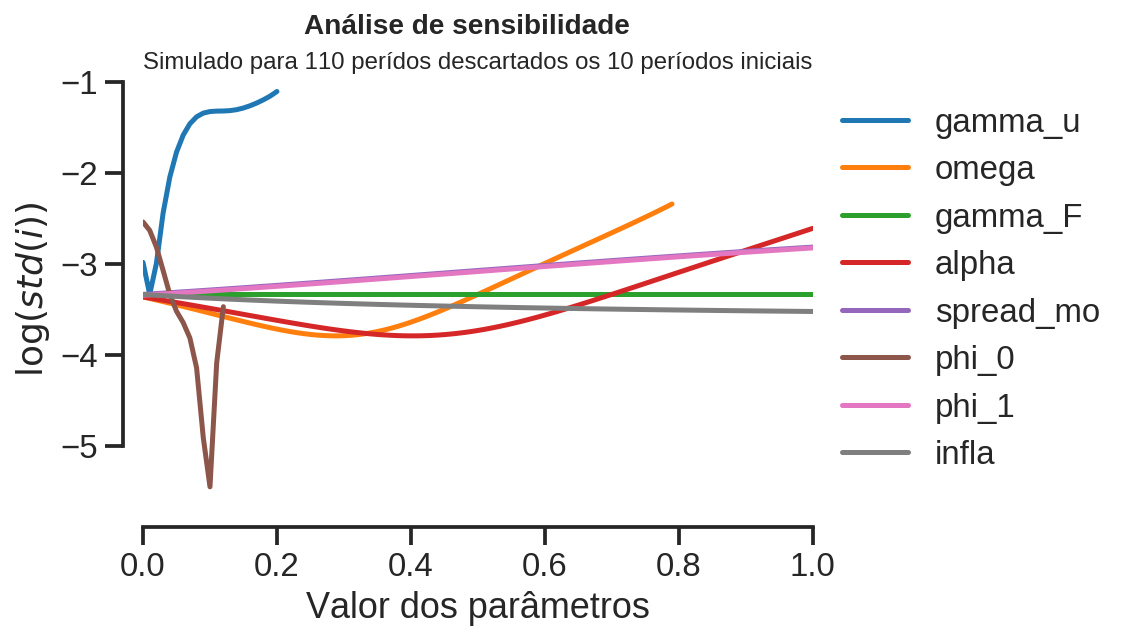

Total running time:  0:07:29.942885


gamma_u     omega   gamma_F     alpha  spread_mo     phi_0     phi_1  \
0.00 -2.986351 -3.365761 -3.337992 -3.365762  -3.337992 -2.542548 -3.347220   
0.01 -3.337992 -3.382585 -3.337992 -3.377752  -3.333329 -2.635066 -3.342624   
0.02 -2.996314 -3.399662 -3.337992 -3.389873  -3.328611 -2.818313 -3.337992   
0.03 -2.443917 -3.416985 -3.337992 -3.402122  -3.323878 -3.075393 -3.333324   
0.04 -2.049284 -3.434541 -3.337992 -3.414496  -3.319126 -3.337992 -3.328621   
...        ...       ...       ...       ...        ...       ...       ...   
0.96       inf       inf -3.337992 -2.709504  -2.836732       inf -2.846077   
0.97       inf       inf -3.337992 -2.685456  -2.832088       inf -2.841374   
0.98       inf       inf -3.337992 -2.661364  -2.827477       inf -2.836701   
0.99       inf       inf -3.337992 -2.637213  -2.822894       inf -2.832058   
1.00       inf       inf -3.337992 -2.612988  -2.818344       inf -2.827446   

         infla  
0.00 -3.337992  
0.01 -3.342670  
0.02 -3.347220  
0.03 -3.351647  
0.04 -3.355955  
...        ...  
0.96 -3.522498  
0.97 -3.523241  
0.98 -3.523974  
0.99 -3.524698  
1.00 -3.525413  

[101 rows x 8 columns]

In [60]:
sobol(time=100)

# Finishing

In [61]:
print("Total running time: ", datetime.now() - t1)
print("Simulation running time: ", t2 - t1)
print("Sobol running time: ", datetime.now() - t2)

Total running time:  0:10:10.390659
Simulation running time:  0:02:40.405256
Sobol running time:  0:07:29.986230


# Shock yourself

In [62]:
base = model()
df = SolveSFC(base, time=1000)

@interact(variable = (df.transpose().loc['alpha':,:].index), increase = (-1,1,0.01))
def shock_yourself(variable, increase):
  shock = ShockModel(base_model = base, create_function = model(), variable = variable, increase = increase)
  clock_plots(shock, 'SelfClock.png', variable=variable)
  plot_shock(shock=shock, filename='SelfShock.png')
  plot_norms(shock=shock, filename='SelfShock.png')
  other_plots(shock)

Widget Javascript not detected.  It may not be installed or enabled properly.
